In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [2]:
lr_tune = np.array([8e-6,8e-5,8e-4,8e-3,8e-2])

In [3]:
def true_disc(x): #[-4,3.75]
    y  = np.zeros((np.shape(x)[0],))
    
    y = 0.2*np.sin(6*x)*np.exp(-1*x)
    y[x>0] = 1 + 0.1*x[x>0]*np.exp(x[x>0]) + 10
    
    return 50*y

In [4]:
# Domain bounds
label = "Regr_disc_swish"
loss_thresh = 0.1

lb = np.array(-4.0)  # [-1. 0.]
ub = np.array(3.75) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_disc(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [5]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_disc(x_train)

    return x_train, u_train

In [6]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Sigmoid()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [7]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(model_NN.beta.cpu().detach().numpy())
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [8]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [9]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    nan_flag = 0 
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
        if(np.isnan(loss_np)):
            nan_flag =1
            print("NAN BREAK!")
            break
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))
    
    return nan_flag

In [10]:
nan_tune = []

for tune_reps in range(5):
    label = "Regr_disc_swish_tune"+str(tune_reps) 
    max_reps = 10
    max_iter = 500
    layers = np.array([1,50,50,50,50,1])

    train_loss_full = []
    test_mse_full = []
    test_re_full = []
    beta_full = []
    elapsed_time= np.zeros((max_reps,1))

    time_threshold = np.empty((max_reps,1))
    time_threshold[:] = np.nan
    epoch_threshold = max_iter*np.ones((max_reps,1))


    for reps in range(max_reps):
        print(label)
        print(reps)

        train_loss = []
        test_mse_loss = []
        test_re_loss = []
        beta_val = []
        'Generate Training data'
        N_train = 300

        x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

        'Convert to tensor and send to GPU'
        x_train = torch.from_numpy(x_train_np_array).float().to(device)
        u_train = torch.from_numpy(u_train_np_array).float().to(device)

        x_test_tensor = torch.from_numpy(x_test).float().to(device)


        model_NN = Sequentialmodel(layers)
        model_NN.to(device)
        print(model_NN)
        params = list(model_NN.parameters())
        #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        optimizer = optim.Adam(model_NN.parameters(), lr=lr_tune[tune_reps])

        nan_flag = train_model(max_iter,reps)

        torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
        train_loss_full.append(train_loss)
        test_mse_full.append(test_mse_loss)
        test_re_full.append(test_re_loss)
        beta_full.append(beta_val)
        
        if(nan_flag == 1):
            nan_tune.append(tune_reps)
            break


    mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"beta": beta_full, "label": label}
    savemat(label+'.mat', mdic) 

Regr_disc_swish_tune0
0
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 290535.5 Test MSE 273359.093779683 Test RE 0.9999879457089105
1 Train Loss 290535.4 Test MSE 273358.9970072752 Test RE 0.9999877687050133
2 Train Loss 290535.3 Test MSE 273358.9002178583 Test RE 0.9999875916699739
3 Train Loss 290535.22 Test MSE 273358.8034082258 Test RE 0.9999874145979275
4 Train Loss 290535.1 Test MSE 273358.7065790403 Test RE 0.9999872374900853
5 Train Loss 290535.0 Test MSE 273358.6097285497 Test RE 0.9999870603432436
6 Train Loss 290534.88 Test MSE 273358.5128574208 Test RE 0.9999868831586214
7 Train Loss 290534.78 Test MSE 273358.4

142 Train Loss 290520.53 Test MSE 273344.97326109733 Test RE 0.9999621179039324
143 Train Loss 290520.44 Test MSE 273344.8700109911 Test RE 0.9999619290469667
144 Train Loss 290520.3 Test MSE 273344.7666966851 Test RE 0.9999617400725357
145 Train Loss 290520.2 Test MSE 273344.66331672575 Test RE 0.9999615509779811
146 Train Loss 290520.1 Test MSE 273344.5598706298 Test RE 0.9999613617624185
147 Train Loss 290519.97 Test MSE 273344.45635735325 Test RE 0.9999611724239391
148 Train Loss 290519.84 Test MSE 273344.3527791551 Test RE 0.9999609829666738
149 Train Loss 290519.78 Test MSE 273344.2491340673 Test RE 0.9999607933870236
150 Train Loss 290519.62 Test MSE 273344.14542103617 Test RE 0.9999606036830605
151 Train Loss 290519.53 Test MSE 273344.04164330213 Test RE 0.9999604138607118
152 Train Loss 290519.4 Test MSE 273343.9377972608 Test RE 0.9999602239133839
153 Train Loss 290519.3 Test MSE 273343.8338847479 Test RE 0.999960033844436
154 Train Loss 290519.22 Test MSE 273343.7299045268 T

297 Train Loss 290502.6 Test MSE 273328.05147046427 Test RE 0.9999311654205413
298 Train Loss 290502.47 Test MSE 273327.93534999335 Test RE 0.9999309530155399
299 Train Loss 290502.3 Test MSE 273327.8191292886 Test RE 0.9999307404271484
300 Train Loss 290502.22 Test MSE 273327.7028061671 Test RE 0.9999305276513726
301 Train Loss 290502.1 Test MSE 273327.5863827472 Test RE 0.9999303146920883
302 Train Loss 290501.97 Test MSE 273327.469856675 Test RE 0.999930101544989
303 Train Loss 290501.8 Test MSE 273327.35322683054 Test RE 0.9999298882080258
304 Train Loss 290501.72 Test MSE 273327.23649650346 Test RE 0.9999296746872164
305 Train Loss 290501.6 Test MSE 273327.1196622897 Test RE 0.999929460976334
306 Train Loss 290501.47 Test MSE 273327.0027265613 Test RE 0.9999292470797169
307 Train Loss 290501.34 Test MSE 273326.88568862935 Test RE 0.9999290329961055
308 Train Loss 290501.22 Test MSE 273326.7685467251 Test RE 0.999928818722264
309 Train Loss 290501.1 Test MSE 273326.65130211617 Test

451 Train Loss 290482.25 Test MSE 273308.8603346161 Test RE 0.999896060806167
452 Train Loss 290482.1 Test MSE 273308.7263898839 Test RE 0.9998958157888151
453 Train Loss 290481.97 Test MSE 273308.5923186886 Test RE 0.9998955705400709
454 Train Loss 290481.8 Test MSE 273308.4581132623 Test RE 0.9998953250457261
455 Train Loss 290481.66 Test MSE 273308.32377760985 Test RE 0.9998950793131054
456 Train Loss 290481.53 Test MSE 273308.1893190428 Test RE 0.9998948333555835
457 Train Loss 290481.4 Test MSE 273308.054723365 Test RE 0.9998945871471918
458 Train Loss 290481.22 Test MSE 273307.92000038666 Test RE 0.9998943407058757
459 Train Loss 290481.12 Test MSE 273307.78515027696 Test RE 0.9998940940319442
460 Train Loss 290480.97 Test MSE 273307.650164715 Test RE 0.9998938471101769
461 Train Loss 290480.8 Test MSE 273307.5150487986 Test RE 0.9998935999498975
462 Train Loss 290480.7 Test MSE 273307.37980605825 Test RE 0.9998933525575654
463 Train Loss 290480.53 Test MSE 273307.2444255085 Test

96 Train Loss 292753.34 Test MSE 273358.52259431203 Test RE 0.9999869009681333
97 Train Loss 292753.22 Test MSE 273358.41956115986 Test RE 0.9999867125126735
98 Train Loss 292753.12 Test MSE 273358.3165085424 Test RE 0.9999865240215746
99 Train Loss 292753.0 Test MSE 273358.2134351752 Test RE 0.9999863354924872
100 Train Loss 292752.88 Test MSE 273358.110339844 Test RE 0.9999861469231901
101 Train Loss 292752.75 Test MSE 273358.0072243972 Test RE 0.9999859583170647
102 Train Loss 292752.7 Test MSE 273357.9040847465 Test RE 0.9999857696666331
103 Train Loss 292752.53 Test MSE 273357.8009254156 Test RE 0.9999855809801688
104 Train Loss 292752.44 Test MSE 273357.6977428788 Test RE 0.9999853922512241
105 Train Loss 292752.3 Test MSE 273357.5945383315 Test RE 0.9999852034819844
106 Train Loss 292752.22 Test MSE 273357.4913127292 Test RE 0.999985014674198
107 Train Loss 292752.1 Test MSE 273357.38806281704 Test RE 0.9999848258219112
108 Train Loss 292751.97 Test MSE 273357.28478956537 Test R

221 Train Loss 292739.03 Test MSE 273345.40567628824 Test RE 0.9999629088433707
222 Train Loss 292738.88 Test MSE 273345.29816664563 Test RE 0.9999627121953507
223 Train Loss 292738.78 Test MSE 273345.1906073199 Test RE 0.9999625154564158
224 Train Loss 292738.7 Test MSE 273345.0829959833 Test RE 0.9999623186223082
225 Train Loss 292738.53 Test MSE 273344.9753339623 Test RE 0.9999621216954536
226 Train Loss 292738.44 Test MSE 273344.867619999 Test RE 0.9999619246735516
227 Train Loss 292738.3 Test MSE 273344.7598548322 Test RE 0.9999617275579532
228 Train Loss 292738.2 Test MSE 273344.6520388588 Test RE 0.999961530349385
229 Train Loss 292738.1 Test MSE 273344.5441691945 Test RE 0.9999613330425697
230 Train Loss 292737.97 Test MSE 273344.4362496372 Test RE 0.9999611356444559
231 Train Loss 292737.8 Test MSE 273344.3282787481 Test RE 0.9999609381524105
232 Train Loss 292737.72 Test MSE 273344.2202533132 Test RE 0.9999607405605555
233 Train Loss 292737.6 Test MSE 273344.1121752009 Test R

358 Train Loss 292722.3 Test MSE 273330.11793620046 Test RE 0.9999349453464857
359 Train Loss 292722.2 Test MSE 273330.0015548777 Test RE 0.9999347324651453
360 Train Loss 292722.1 Test MSE 273329.88509187504 Test RE 0.9999345194343522
361 Train Loss 292721.97 Test MSE 273329.76855210913 Test RE 0.9999343062631009
362 Train Loss 292721.8 Test MSE 273329.65193146263 Test RE 0.9999340929438597
363 Train Loss 292721.72 Test MSE 273329.5352292765 Test RE 0.9999338794754232
364 Train Loss 292721.56 Test MSE 273329.4184510499 Test RE 0.9999336658678492
365 Train Loss 292721.44 Test MSE 273329.30158999044 Test RE 0.9999334521087143
366 Train Loss 292721.3 Test MSE 273329.18464967737 Test RE 0.9999332382045651
367 Train Loss 292721.2 Test MSE 273329.0676278159 Test RE 0.9999330241512039
368 Train Loss 292721.06 Test MSE 273328.9505252525 Test RE 0.9999328099501791
369 Train Loss 292720.94 Test MSE 273328.8333440128 Test RE 0.9999325956051953
370 Train Loss 292720.8 Test MSE 273328.71608014323 

11 Train Loss 279584.16 Test MSE 273360.2572220135 Test RE 0.9999900737286005
12 Train Loss 279584.06 Test MSE 273360.1802739798 Test RE 0.9999899329852533
13 Train Loss 279584.0 Test MSE 273360.10330953065 Test RE 0.9999897922118612
14 Train Loss 279583.9 Test MSE 273360.0263283608 Test RE 0.9999896514078657
15 Train Loss 279583.84 Test MSE 273359.9493311606 Test RE 0.9999895105745297
16 Train Loss 279583.78 Test MSE 273359.87231640663 Test RE 0.9999893697090667
17 Train Loss 279583.7 Test MSE 273359.79528387176 Test RE 0.9999892288110617
18 Train Loss 279583.6 Test MSE 273359.7182343786 Test RE 0.9999890878820186
19 Train Loss 279583.53 Test MSE 273359.64116564504 Test RE 0.9999889469177639
20 Train Loss 279583.44 Test MSE 273359.5640794114 Test RE 0.9999888059214799
21 Train Loss 279583.38 Test MSE 273359.4869756385 Test RE 0.999988664893096
22 Train Loss 279583.28 Test MSE 273359.40985153266 Test RE 0.9999885238275014
23 Train Loss 279583.22 Test MSE 273359.3327083277 Test RE 0.999

163 Train Loss 279571.9 Test MSE 273348.1948468467 Test RE 0.9999680105570489
164 Train Loss 279571.78 Test MSE 273348.11205160216 Test RE 0.9999678591154011
165 Train Loss 279571.72 Test MSE 273348.0291999277 Test RE 0.9999677075705132
166 Train Loss 279571.62 Test MSE 273347.94629148697 Test RE 0.9999675559217713
167 Train Loss 279571.6 Test MSE 273347.8633286442 Test RE 0.9999674041734985
168 Train Loss 279571.47 Test MSE 273347.78030904225 Test RE 0.999967252321384
169 Train Loss 279571.38 Test MSE 273347.6972337687 Test RE 0.9999671003674162
170 Train Loss 279571.3 Test MSE 273347.61410178355 Test RE 0.9999669483096945
171 Train Loss 279571.22 Test MSE 273347.5309139357 Test RE 0.9999667961497692
172 Train Loss 279571.16 Test MSE 273347.4476710313 Test RE 0.9999666438891173
173 Train Loss 279571.03 Test MSE 273347.3643689611 Test RE 0.9999664915202209
174 Train Loss 279570.97 Test MSE 273347.2810121262 Test RE 0.9999663390511303
175 Train Loss 279570.88 Test MSE 273347.19759633794

318 Train Loss 279558.1 Test MSE 273334.59748781525 Test RE 0.999943139177961
319 Train Loss 279557.97 Test MSE 273334.5041186424 Test RE 0.9999429683911805
320 Train Loss 279557.88 Test MSE 273334.41066612303 Test RE 0.999942797451917
321 Train Loss 279557.78 Test MSE 273334.31713521463 Test RE 0.9999426263692387
322 Train Loss 279557.72 Test MSE 273334.2235235165 Test RE 0.9999424551387537
323 Train Loss 279557.6 Test MSE 273334.129828421 Test RE 0.9999422837556924
324 Train Loss 279557.53 Test MSE 273334.0360547358 Test RE 0.9999421122288491
325 Train Loss 279557.4 Test MSE 273333.9421997517 Test RE 0.9999419405532678
326 Train Loss 279557.34 Test MSE 273333.84826146706 Test RE 0.9999417687252871
327 Train Loss 279557.22 Test MSE 273333.754244403 Test RE 0.9999415967531767
328 Train Loss 279557.12 Test MSE 273333.6601429324 Test RE 0.9999414246266438
329 Train Loss 279557.03 Test MSE 273333.5659625922 Test RE 0.9999412523558164
330 Train Loss 279556.9 Test MSE 273333.4717000374 Test

474 Train Loss 279542.2 Test MSE 273318.96392345784 Test RE 0.9999145425438344
475 Train Loss 279542.1 Test MSE 273318.8561154934 Test RE 0.9999143453406097
476 Train Loss 279541.97 Test MSE 273318.7481975785 Test RE 0.999914147936224
477 Train Loss 279541.88 Test MSE 273318.6401736915 Test RE 0.999913950337954
478 Train Loss 279541.75 Test MSE 273318.5320475368 Test RE 0.9999137525525761
479 Train Loss 279541.62 Test MSE 273318.42381195555 Test RE 0.9999135545669945
480 Train Loss 279541.53 Test MSE 273318.3154694065 Test RE 0.9999133563857074
481 Train Loss 279541.44 Test MSE 273318.207023901 Test RE 0.999913158016052
482 Train Loss 279541.3 Test MSE 273318.09846691746 Test RE 0.9999129594424403
483 Train Loss 279541.2 Test MSE 273317.9898021103 Test RE 0.999912760671557
484 Train Loss 279541.06 Test MSE 273317.8810328793 Test RE 0.9999125617096208
485 Train Loss 279540.97 Test MSE 273317.7721535046 Test RE 0.9999123625461687
486 Train Loss 279540.88 Test MSE 273317.66316744505 Test 

128 Train Loss 305580.5 Test MSE 273359.3370447891 Test RE 0.9999883906586583
129 Train Loss 305580.38 Test MSE 273359.2317111124 Test RE 0.9999881979956509
130 Train Loss 305580.28 Test MSE 273359.12633618654 Test RE 0.9999880052571584
131 Train Loss 305580.16 Test MSE 273359.02092026884 Test RE 0.9999878124436516
132 Train Loss 305580.03 Test MSE 273358.9154606632 Test RE 0.9999876195501993
133 Train Loss 305579.9 Test MSE 273358.80996024405 Test RE 0.9999874265820591
134 Train Loss 305579.78 Test MSE 273358.70441973535 Test RE 0.9999872335405545
135 Train Loss 305579.7 Test MSE 273358.59883597074 Test RE 0.9999870404198943
136 Train Loss 305579.6 Test MSE 273358.49320997304 Test RE 0.9999868472219494
137 Train Loss 305579.44 Test MSE 273358.38754050113 Test RE 0.9999866539444496
138 Train Loss 305579.34 Test MSE 273358.28182804334 Test RE 0.9999864605882877
139 Train Loss 305579.22 Test MSE 273358.17607245455 Test RE 0.999986267153199
140 Train Loss 305579.1 Test MSE 273358.07027174

283 Train Loss 305561.7 Test MSE 273342.3571340071 Test RE 0.9999573326792144
284 Train Loss 305561.56 Test MSE 273342.24233908055 Test RE 0.999957122704365
285 Train Loss 305561.44 Test MSE 273342.1274658015 Test RE 0.9999569125861543
286 Train Loss 305561.28 Test MSE 273342.01251438376 Test RE 0.9999567023249738
287 Train Loss 305561.2 Test MSE 273341.89748553024 Test RE 0.9999564919221086
288 Train Loss 305561.03 Test MSE 273341.7823734055 Test RE 0.9999562813668854
289 Train Loss 305560.9 Test MSE 273341.6671848743 Test RE 0.99995607067186
290 Train Loss 305560.78 Test MSE 273341.55191234656 Test RE 0.9999558598231499
291 Train Loss 305560.66 Test MSE 273341.43656088697 Test RE 0.9999556488300178
292 Train Loss 305560.53 Test MSE 273341.3211311249 Test RE 0.999955437693616
293 Train Loss 305560.38 Test MSE 273341.2056188152 Test RE 0.9999552264061788
294 Train Loss 305560.28 Test MSE 273341.0900272949 Test RE 0.9999550149738103
295 Train Loss 305560.16 Test MSE 273340.97435712384 T

440 Train Loss 305540.47 Test MSE 273323.2416816602 Test RE 0.9999223674233054
441 Train Loss 305540.3 Test MSE 273323.11206107837 Test RE 0.9999221303221103
442 Train Loss 305540.16 Test MSE 273322.98232963466 Test RE 0.9999218930180713
443 Train Loss 305540.06 Test MSE 273322.8524868952 Test RE 0.9999216555103941
444 Train Loss 305539.9 Test MSE 273322.7225353243 Test RE 0.9999214178035869
445 Train Loss 305539.75 Test MSE 273322.5924729105 Test RE 0.9999211798939693
446 Train Loss 305539.6 Test MSE 273322.4622995637 Test RE 0.9999209417813771
447 Train Loss 305539.47 Test MSE 273322.3320182738 Test RE 0.9999207034712793
448 Train Loss 305539.3 Test MSE 273322.201624359 Test RE 0.9999204649551108
449 Train Loss 305539.2 Test MSE 273322.0711197973 Test RE 0.9999202262364909
450 Train Loss 305539.03 Test MSE 273321.9405072382 Test RE 0.9999199873202653
451 Train Loss 305538.88 Test MSE 273321.8097802581 Test RE 0.999919748194684
452 Train Loss 305538.72 Test MSE 273321.6789443653 Test 

97 Train Loss 258335.77 Test MSE 273333.0049344805 Test RE 0.9999402261455181
98 Train Loss 258335.66 Test MSE 273332.87822510256 Test RE 0.99993999437362
99 Train Loss 258335.53 Test MSE 273332.751436999 Test RE 0.9999397624576664
100 Train Loss 258335.42 Test MSE 273332.6245763856 Test RE 0.9999395304090267
101 Train Loss 258335.28 Test MSE 273332.4976369449 Test RE 0.9999392982161452
102 Train Loss 258335.16 Test MSE 273332.37062243593 Test RE 0.9999390658858973
103 Train Loss 258335.05 Test MSE 273332.24352917547 Test RE 0.9999388334115465
104 Train Loss 258334.94 Test MSE 273332.1163615852 Test RE 0.9999386008011802
105 Train Loss 258334.81 Test MSE 273331.9891156142 Test RE 0.9999383680473882
106 Train Loss 258334.67 Test MSE 273331.861791237 Test RE 0.9999381351501245
107 Train Loss 258334.56 Test MSE 273331.7343910437 Test RE 0.999937902114126
108 Train Loss 258334.45 Test MSE 273331.6069088837 Test RE 0.9999376689281428
109 Train Loss 258334.33 Test MSE 273331.47935298487 Test

248 Train Loss 258316.52 Test MSE 273312.8758616679 Test RE 0.9999034061496893
249 Train Loss 258316.38 Test MSE 273312.73490595684 Test RE 0.9999031483094515
250 Train Loss 258316.27 Test MSE 273312.59383036016 Test RE 0.9999028902498486
251 Train Loss 258316.14 Test MSE 273312.4526425537 Test RE 0.9999026319849224
252 Train Loss 258316.0 Test MSE 273312.31134420104 Test RE 0.9999023735177144
253 Train Loss 258315.84 Test MSE 273312.16992669844 Test RE 0.999902114832487
254 Train Loss 258315.72 Test MSE 273312.0283970049 Test RE 0.9999018559419695
255 Train Loss 258315.61 Test MSE 273311.8867605142 Test RE 0.9999015968560282
256 Train Loss 258315.47 Test MSE 273311.74500090553 Test RE 0.9999013375448084
257 Train Loss 258315.31 Test MSE 273311.6031256164 Test RE 0.9999010780219146
258 Train Loss 258315.17 Test MSE 273311.46113975235 Test RE 0.9999008182966866
259 Train Loss 258315.05 Test MSE 273311.3190355826 Test RE 0.9999005583549821
260 Train Loss 258314.89 Test MSE 273311.1768138

404 Train Loss 258294.1 Test MSE 273289.37769348564 Test RE 0.9998604217067345
405 Train Loss 258293.92 Test MSE 273289.21633600804 Test RE 0.9998601265343044
406 Train Loss 258293.77 Test MSE 273289.0548274154 Test RE 0.9998598310853514
407 Train Loss 258293.61 Test MSE 273288.89316718775 Test RE 0.9998595353589238
408 Train Loss 258293.45 Test MSE 273288.73135993123 Test RE 0.9998592393634472
409 Train Loss 258293.28 Test MSE 273288.56939743826 Test RE 0.9998589430839077
410 Train Loss 258293.12 Test MSE 273288.4072850803 Test RE 0.9998586465301307
411 Train Loss 258293.0 Test MSE 273288.24502581207 Test RE 0.9998583497075211
412 Train Loss 258292.86 Test MSE 273288.0826126523 Test RE 0.999858052603308
413 Train Loss 258292.67 Test MSE 273287.92004717886 Test RE 0.9998577552203773
414 Train Loss 258292.52 Test MSE 273287.7573329819 Test RE 0.9998574575652962
415 Train Loss 258292.36 Test MSE 273287.5944616565 Test RE 0.9998571596226898
416 Train Loss 258292.22 Test MSE 273287.4314420

52 Train Loss 263845.94 Test MSE 273367.1669430824 Test RE 1.0000027120120296
53 Train Loss 263845.84 Test MSE 273367.0692616154 Test RE 1.0000025333480338
54 Train Loss 263845.78 Test MSE 273366.97157127416 Test RE 1.0000023546677752
55 Train Loss 263845.66 Test MSE 273366.87387099996 Test RE 1.0000021759693158
56 Train Loss 263845.56 Test MSE 273366.77616077807 Test RE 1.0000019972526308
57 Train Loss 263845.44 Test MSE 273366.6784394549 Test RE 1.0000018185156083
58 Train Loss 263845.38 Test MSE 273366.580707446 Test RE 1.0000016397590095
59 Train Loss 263845.28 Test MSE 273366.4829652786 Test RE 1.0000014609837986
60 Train Loss 263845.2 Test MSE 273366.38521173317 Test RE 1.0000012821877442
61 Train Loss 263845.1 Test MSE 273366.2874490567 Test RE 1.000001103374957
62 Train Loss 263845.0 Test MSE 273366.1896752394 Test RE 1.0000009245417607
63 Train Loss 263844.9 Test MSE 273366.0918899933 Test RE 1.0000007456876285
64 Train Loss 263844.8 Test MSE 273365.9940935612 Test RE 1.000000

192 Train Loss 263832.7 Test MSE 273353.3105159086 Test RE 0.9999773676363661
193 Train Loss 263832.56 Test MSE 273353.2095892742 Test RE 0.9999771830321275
194 Train Loss 263832.5 Test MSE 273353.1086222437 Test RE 0.9999769983539666
195 Train Loss 263832.38 Test MSE 273353.00762026594 Test RE 0.99997681361185
196 Train Loss 263832.28 Test MSE 273352.9065779182 Test RE 0.9999766287958584
197 Train Loss 263832.16 Test MSE 273352.8054986954 Test RE 0.9999764439123846
198 Train Loss 263832.1 Test MSE 273352.70438081917 Test RE 0.9999762589581761
199 Train Loss 263831.97 Test MSE 273352.60322443594 Test RE 0.9999760739335002
200 Train Loss 263831.9 Test MSE 273352.50203000335 Test RE 0.9999758888391941
201 Train Loss 263831.78 Test MSE 273352.40079611 Test RE 0.9999757036726766
202 Train Loss 263831.7 Test MSE 273352.2995239646 Test RE 0.9999755184361576
203 Train Loss 263831.6 Test MSE 273352.19821434893 Test RE 0.9999753331310677
204 Train Loss 263831.5 Test MSE 273352.0968662833 Test R

331 Train Loss 263818.78 Test MSE 273338.82977121224 Test RE 0.9999508806537982
332 Train Loss 263818.72 Test MSE 273338.72157590697 Test RE 0.9999506827492386
333 Train Loss 263818.56 Test MSE 273338.6133135034 Test RE 0.9999504847219075
334 Train Loss 263818.5 Test MSE 273338.50497938803 Test RE 0.9999502865633659
335 Train Loss 263818.38 Test MSE 273338.3965795341 Test RE 0.9999500882845397
336 Train Loss 263818.3 Test MSE 273338.2881102316 Test RE 0.9999498898786433
337 Train Loss 263818.2 Test MSE 273338.1795710369 Test RE 0.999949691344864
338 Train Loss 263818.1 Test MSE 273338.070963629 Test RE 0.9999494926862742
339 Train Loss 263817.97 Test MSE 273337.9622855285 Test RE 0.9999492938983372
340 Train Loss 263817.88 Test MSE 273337.853537551 Test RE 0.999949094982546
341 Train Loss 263817.78 Test MSE 273337.74472247926 Test RE 0.9999488959439902
342 Train Loss 263817.66 Test MSE 273337.6358330102 Test RE 0.9999486967693108
343 Train Loss 263817.56 Test MSE 273337.52687544853 Tes

486 Train Loss 263801.84 Test MSE 273321.0994839315 Test RE 0.9999184489207875
487 Train Loss 263801.72 Test MSE 273320.97786280175 Test RE 0.9999182264512724
488 Train Loss 263801.6 Test MSE 273320.85613889253 Test RE 0.9999180037937032
489 Train Loss 263801.5 Test MSE 273320.73431032716 Test RE 0.9999177809446477
490 Train Loss 263801.38 Test MSE 273320.6123740052 Test RE 0.9999175578984331
491 Train Loss 263801.22 Test MSE 273320.49033469864 Test RE 0.9999173346637895
492 Train Loss 263801.16 Test MSE 273320.36818735994 Test RE 0.9999171112314834
493 Train Loss 263801.03 Test MSE 273320.2459344149 Test RE 0.9999168876059519
494 Train Loss 263800.9 Test MSE 273320.1235768378 Test RE 0.9999166637889769
495 Train Loss 263800.78 Test MSE 273320.00111262396 Test RE 0.999916439776891
496 Train Loss 263800.66 Test MSE 273319.8785409893 Test RE 0.9999162155682604
497 Train Loss 263800.53 Test MSE 273319.75586524804 Test RE 0.9999159911691472
498 Train Loss 263800.44 Test MSE 273319.63307980

138 Train Loss 310683.2 Test MSE 273358.07151805126 Test RE 0.9999860759151339
139 Train Loss 310683.1 Test MSE 273357.97588703805 Test RE 0.9999859009986045
140 Train Loss 310682.97 Test MSE 273357.8802149887 Test RE 0.999985726006987
141 Train Loss 310682.88 Test MSE 273357.78450148256 Test RE 0.9999855509395111
142 Train Loss 310682.75 Test MSE 273357.6887463805 Test RE 0.9999853757959222
143 Train Loss 310682.66 Test MSE 273357.59294991154 Test RE 0.9999852005766391
144 Train Loss 310682.56 Test MSE 273357.497112102 Test RE 0.9999850252817102
145 Train Loss 310682.47 Test MSE 273357.4012313121 Test RE 0.9999848499081363
146 Train Loss 310682.34 Test MSE 273357.30530761083 Test RE 0.9999846744560433
147 Train Loss 310682.22 Test MSE 273357.2093413062 Test RE 0.9999844989259941
148 Train Loss 310682.1 Test MSE 273357.11333200725 Test RE 0.9999843233172744
149 Train Loss 310681.97 Test MSE 273357.0172785393 Test RE 0.9999841476277355
150 Train Loss 310681.9 Test MSE 273356.92118217016

295 Train Loss 310665.75 Test MSE 273342.40299294086 Test RE 0.9999574165611556
296 Train Loss 310665.62 Test MSE 273342.29805270623 Test RE 0.9999572246118369
297 Train Loss 310665.53 Test MSE 273342.19303874916 Test RE 0.9999570325276338
298 Train Loss 310665.4 Test MSE 273342.0879449764 Test RE 0.9999568402974003
299 Train Loss 310665.28 Test MSE 273341.9827768127 Test RE 0.9999566479310588
300 Train Loss 310665.2 Test MSE 273341.8775314316 Test RE 0.9999564554234398
301 Train Loss 310665.06 Test MSE 273341.7722082729 Test RE 0.9999562627735179
302 Train Loss 310664.9 Test MSE 273341.666808429 Test RE 0.9999560699832919
303 Train Loss 310664.8 Test MSE 273341.56133134215 Test RE 0.9999558770517409
304 Train Loss 310664.7 Test MSE 273341.4557746667 Test RE 0.9999556839745747
305 Train Loss 310664.56 Test MSE 273341.35014162376 Test RE 0.999955490757685
306 Train Loss 310664.44 Test MSE 273341.2444296414 Test RE 0.999955297396367
307 Train Loss 310664.3 Test MSE 273341.1386405945 Test

447 Train Loss 310646.88 Test MSE 273325.4634872997 Test RE 0.9999264315281844
448 Train Loss 310646.75 Test MSE 273325.3446999389 Test RE 0.9999262142439383
449 Train Loss 310646.62 Test MSE 273325.2258034857 Test RE 0.999925996760094
450 Train Loss 310646.5 Test MSE 273325.10680202366 Test RE 0.9999257790841217
451 Train Loss 310646.34 Test MSE 273324.98769510747 Test RE 0.9999255612152068
452 Train Loss 310646.25 Test MSE 273324.8684800229 Test RE 0.9999253431483839
453 Train Loss 310646.1 Test MSE 273324.7491596618 Test RE 0.9999251248889431
454 Train Loss 310645.97 Test MSE 273324.62973181397 Test RE 0.9999249064328406
455 Train Loss 310645.84 Test MSE 273324.5101957424 Test RE 0.9999246877787289
456 Train Loss 310645.72 Test MSE 273324.39055450336 Test RE 0.999924468932198
457 Train Loss 310645.56 Test MSE 273324.2708040368 Test RE 0.9999242498858215
458 Train Loss 310645.44 Test MSE 273324.1509446357 Test RE 0.9999240306401348
459 Train Loss 310645.28 Test MSE 273324.03098033584

101 Train Loss 306052.5 Test MSE 273355.63956514955 Test RE 0.9999816276754413
102 Train Loss 306052.38 Test MSE 273355.54376654373 Test RE 0.9999814524515929
103 Train Loss 306052.28 Test MSE 273355.44794641784 Test RE 0.999981277188352
104 Train Loss 306052.16 Test MSE 273355.35210483224 Test RE 0.9999811018858287
105 Train Loss 306052.06 Test MSE 273355.2562418898 Test RE 0.999980926544211
106 Train Loss 306051.97 Test MSE 273355.1603574048 Test RE 0.9999807511631595
107 Train Loss 306051.88 Test MSE 273355.0644495058 Test RE 0.9999805757392509
108 Train Loss 306051.75 Test MSE 273354.9685185288 Test RE 0.9999804002731001
109 Train Loss 306051.62 Test MSE 273354.8725659893 Test RE 0.9999802247674785
110 Train Loss 306051.56 Test MSE 273354.7765891542 Test RE 0.9999800492173875
111 Train Loss 306051.44 Test MSE 273354.68058882846 Test RE 0.9999798736242993
112 Train Loss 306051.34 Test MSE 273354.58456376084 Test RE 0.9999796979859246
113 Train Loss 306051.22 Test MSE 273354.48851424

255 Train Loss 306035.97 Test MSE 273340.4572193999 Test RE 0.9999538574826439
256 Train Loss 306035.84 Test MSE 273340.35482858366 Test RE 0.9999536701958762
257 Train Loss 306035.72 Test MSE 273340.25237942865 Test RE 0.9999534828023641
258 Train Loss 306035.6 Test MSE 273340.14987075934 Test RE 0.9999532952999575
259 Train Loss 306035.5 Test MSE 273340.04730074346 Test RE 0.9999531076853039
260 Train Loss 306035.4 Test MSE 273339.9446728015 Test RE 0.9999529199646604
261 Train Loss 306035.28 Test MSE 273339.84198334813 Test RE 0.9999527321314685
262 Train Loss 306035.2 Test MSE 273339.7392325121 Test RE 0.9999525441859647
263 Train Loss 306035.06 Test MSE 273339.636423626 Test RE 0.9999523561342435
264 Train Loss 306034.94 Test MSE 273339.5335503645 Test RE 0.9999521679647351
265 Train Loss 306034.84 Test MSE 273339.4306189278 Test RE 0.9999519796887811
266 Train Loss 306034.72 Test MSE 273339.3276248708 Test RE 0.9999517912982503
267 Train Loss 306034.62 Test MSE 273339.22456762986

411 Train Loss 306017.66 Test MSE 273323.65288345946 Test RE 0.9999231195908111
412 Train Loss 306017.53 Test MSE 273323.5390408043 Test RE 0.9999229113506652
413 Train Loss 306017.4 Test MSE 273323.42510952574 Test RE 0.9999227029483666
414 Train Loss 306017.25 Test MSE 273323.31109295 Test RE 0.9999224943899995
415 Train Loss 306017.16 Test MSE 273323.19698855374 Test RE 0.9999222856709481
416 Train Loss 306017.03 Test MSE 273323.08279378206 Test RE 0.9999220767865387
417 Train Loss 306016.9 Test MSE 273322.9685145164 Test RE 0.99992186774753
418 Train Loss 306016.75 Test MSE 273322.8541444682 Test RE 0.9999216585424188
419 Train Loss 306016.66 Test MSE 273322.7396862585 Test RE 0.9999214491759987
420 Train Loss 306016.53 Test MSE 273322.62513928564 Test RE 0.99992123964717
421 Train Loss 306016.4 Test MSE 273322.5105055568 Test RE 0.9999210299596036
422 Train Loss 306016.28 Test MSE 273322.39578046475 Test RE 0.9999208201048719
423 Train Loss 306016.16 Test MSE 273322.28096569097 Te

63 Train Loss 274167.2 Test MSE 273369.75973644137 Test RE 1.0000074543413144
64 Train Loss 274167.1 Test MSE 273369.66691422806 Test RE 1.0000072845659287
65 Train Loss 274167.0 Test MSE 273369.574099998 Test RE 1.0000071148051146
66 Train Loss 274166.9 Test MSE 273369.4812923945 Test RE 1.0000069450563929
67 Train Loss 274166.8 Test MSE 273369.3884922597 Test RE 1.0000067753213024
68 Train Loss 274166.72 Test MSE 273369.2956992368 Test RE 1.0000066055991914
69 Train Loss 274166.62 Test MSE 273369.20291384286 Test RE 1.0000064358910052
70 Train Loss 274166.5 Test MSE 273369.11013416934 Test RE 1.0000062661932527
71 Train Loss 274166.44 Test MSE 273369.01735961216 Test RE 1.00000609650483
72 Train Loss 274166.3 Test MSE 273368.92459137033 Test RE 1.000005926827929
73 Train Loss 274166.22 Test MSE 273368.83182976214 Test RE 1.000005757163133
74 Train Loss 274166.12 Test MSE 273368.7390731353 Test RE 1.0000055875074187
75 Train Loss 274166.03 Test MSE 273368.6463214388 Test RE 1.00000541

214 Train Loss 274152.6 Test MSE 273355.6926467181 Test RE 0.9999817247661593
215 Train Loss 274152.5 Test MSE 273355.5982581145 Test RE 0.9999815521213427
216 Train Loss 274152.44 Test MSE 273355.5038416139 Test RE 0.9999813794254705
217 Train Loss 274152.3 Test MSE 273355.40939628874 Test RE 0.999981206676846
218 Train Loss 274152.22 Test MSE 273355.3149218652 Test RE 0.9999810338749676
219 Train Loss 274152.12 Test MSE 273355.22041962395 Test RE 0.9999808610221791
220 Train Loss 274152.0 Test MSE 273355.1258883943 Test RE 0.9999806881163379
221 Train Loss 274151.94 Test MSE 273355.03132735705 Test RE 0.9999805151559463
222 Train Loss 274151.8 Test MSE 273354.9367350148 Test RE 0.999980342138265
223 Train Loss 274151.72 Test MSE 273354.8421147074 Test RE 0.9999801690694032
224 Train Loss 274151.62 Test MSE 273354.74746224284 Test RE 0.9999799959416932
225 Train Loss 274151.56 Test MSE 273354.6527804361 Test RE 0.9999798227602837
226 Train Loss 274151.4 Test MSE 273354.558068391 Test 

362 Train Loss 274137.66 Test MSE 273341.2808466718 Test RE 0.9999553640079776
363 Train Loss 274137.56 Test MSE 273341.17950447445 Test RE 0.9999551786395569
364 Train Loss 274137.44 Test MSE 273341.0780947148 Test RE 0.9999549931475212
365 Train Loss 274137.34 Test MSE 273340.97662180755 Test RE 0.9999548075399453
366 Train Loss 274137.22 Test MSE 273340.8750826937 Test RE 0.9999546218112345
367 Train Loss 274137.12 Test MSE 273340.77347458934 Test RE 0.999954435956296
368 Train Loss 274137.03 Test MSE 273340.6718006467 Test RE 0.9999542499808959
369 Train Loss 274136.94 Test MSE 273340.57006014785 Test RE 0.9999540638837208
370 Train Loss 274136.84 Test MSE 273340.4682535538 Test RE 0.9999538776656142
371 Train Loss 274136.72 Test MSE 273340.36637930124 Test RE 0.999953691323716
372 Train Loss 274136.62 Test MSE 273340.2644360089 Test RE 0.9999535048554999
373 Train Loss 274136.5 Test MSE 273340.1624269732 Test RE 0.9999533182669955
374 Train Loss 274136.4 Test MSE 273340.0603511132

15 Train Loss 278326.44 Test MSE 273380.3451599639 Test RE 1.0000268152976417
16 Train Loss 278326.3 Test MSE 273380.25628621987 Test RE 1.0000266527473052
17 Train Loss 278326.28 Test MSE 273380.1674386619 Test RE 1.0000264902448361
18 Train Loss 278326.12 Test MSE 273380.07861888123 Test RE 1.0000263277931454
19 Train Loss 278326.06 Test MSE 273379.98982392007 Test RE 1.0000261653868234
20 Train Loss 278325.97 Test MSE 273379.90105527896 Test RE 1.0000260030286146
21 Train Loss 278325.88 Test MSE 273379.8123143296 Test RE 1.0000258407210276
22 Train Loss 278325.78 Test MSE 273379.7236003346 Test RE 1.0000256784627142
23 Train Loss 278325.72 Test MSE 273379.6349124646 Test RE 1.000025516252157
24 Train Loss 278325.6 Test MSE 273379.5462515173 Test RE 1.0000253540908153
25 Train Loss 278325.5 Test MSE 273379.4576158928 Test RE 1.0000251919757628
26 Train Loss 278325.44 Test MSE 273379.3690060014 Test RE 1.00002502990775
27 Train Loss 278325.34 Test MSE 273379.28042301105 Test RE 1.0000

164 Train Loss 278313.03 Test MSE 273367.2294322644 Test RE 1.0000028263076646
165 Train Loss 278312.94 Test MSE 273367.14089594036 Test RE 1.0000026643705853
166 Train Loss 278312.88 Test MSE 273367.05233739427 Test RE 1.0000025023928345
167 Train Loss 278312.75 Test MSE 273366.9637598491 Test RE 1.0000023403803073
168 Train Loss 278312.7 Test MSE 273366.8751626295 Test RE 1.0000021783317685
169 Train Loss 278312.6 Test MSE 273366.7865435211 Test RE 1.0000020162431675
170 Train Loss 278312.5 Test MSE 273366.697904644 Test RE 1.0000018541183826
171 Train Loss 278312.4 Test MSE 273366.6092447945 Test RE 1.0000016919552117
172 Train Loss 278312.3 Test MSE 273366.52056371234 Test RE 1.000001529753179
173 Train Loss 278312.22 Test MSE 273366.4318617386 Test RE 1.0000013675129082
174 Train Loss 278312.12 Test MSE 273366.34313859744 Test RE 1.0000012052338947
175 Train Loss 278312.03 Test MSE 273366.2543935702 Test RE 1.0000010429148245
176 Train Loss 278311.97 Test MSE 273366.16562780156 Te

317 Train Loss 278298.88 Test MSE 273353.34787329874 Test RE 0.9999774359665123
318 Train Loss 278298.78 Test MSE 273353.2541820617 Test RE 0.9999772645965038
319 Train Loss 278298.7 Test MSE 273353.1604419524 Test RE 0.9999770931370743
320 Train Loss 278298.56 Test MSE 273353.0666542192 Test RE 0.9999769215905066
321 Train Loss 278298.5 Test MSE 273352.9728165384 Test RE 0.9999767499525507
322 Train Loss 278298.4 Test MSE 273352.8789298532 Test RE 0.9999765782249318
323 Train Loss 278298.3 Test MSE 273352.7849941293 Test RE 0.9999764064075863
324 Train Loss 278298.22 Test MSE 273352.69100890105 Test RE 0.9999762344996637
325 Train Loss 278298.1 Test MSE 273352.59697376407 Test RE 0.9999760625004238
326 Train Loss 278298.03 Test MSE 273352.5028889596 Test RE 0.9999758904103075
327 Train Loss 278297.94 Test MSE 273352.408753694 Test RE 0.9999757182278635
328 Train Loss 278297.8 Test MSE 273352.3145681977 Test RE 0.9999755459535127
329 Train Loss 278297.72 Test MSE 273352.2203314918 Test

472 Train Loss 278283.34 Test MSE 273338.12411298754 Test RE 0.9999495899041102
473 Train Loss 278283.25 Test MSE 273338.0204885278 Test RE 0.9999494003600311
474 Train Loss 278283.12 Test MSE 273337.9167821958 Test RE 0.9999492106661604
475 Train Loss 278283.03 Test MSE 273337.8129975583 Test RE 0.9999490208290216
476 Train Loss 278282.94 Test MSE 273337.70913339715 Test RE 0.9999488308463861
477 Train Loss 278282.8 Test MSE 273337.6051867563 Test RE 0.9999486407128471
478 Train Loss 278282.7 Test MSE 273337.5011596619 Test RE 0.9999484504321108
479 Train Loss 278282.62 Test MSE 273337.3970532835 Test RE 0.9999482600063162
480 Train Loss 278282.5 Test MSE 273337.29286476306 Test RE 0.9999480694302354
481 Train Loss 278282.4 Test MSE 273337.18859286 Test RE 0.9999478787015996
482 Train Loss 278282.28 Test MSE 273337.0842410188 Test RE 0.9999476878267087
483 Train Loss 278282.2 Test MSE 273336.9798079924 Test RE 0.9999474968032813
484 Train Loss 278282.06 Test MSE 273336.8752902187 Test

115 Train Loss 290337.34 Test MSE 273169.4914153714 Test RE 0.9996410888249601
116 Train Loss 290334.5 Test MSE 273166.78244562977 Test RE 0.9996361321876691
117 Train Loss 290331.62 Test MSE 273164.0427645861 Test RE 0.9996311193325109
118 Train Loss 290328.7 Test MSE 273161.2719866604 Test RE 0.9996260495531304
119 Train Loss 290325.78 Test MSE 273158.46967289347 Test RE 0.9996209220454781
120 Train Loss 290322.84 Test MSE 273155.63542869966 Test RE 0.9996157360866705
121 Train Loss 290319.8 Test MSE 273152.7688592578 Test RE 0.9996104909533676
122 Train Loss 290316.75 Test MSE 273149.8695059351 Test RE 0.9996051858054438
123 Train Loss 290313.72 Test MSE 273146.9369890552 Test RE 0.999599819947218
124 Train Loss 290310.62 Test MSE 273143.97083890205 Test RE 0.9995943925182286
125 Train Loss 290307.47 Test MSE 273140.9706483163 Test RE 0.9995889027724512
126 Train Loss 290304.28 Test MSE 273137.9359930006 Test RE 0.9995833499324731
127 Train Loss 290301.06 Test MSE 273134.86639510543

267 Train Loss 289137.88 Test MSE 272022.22558608965 Test RE 0.9975397180962552
268 Train Loss 289120.5 Test MSE 272005.58901873 Test RE 0.9975092134372543
269 Train Loss 289102.88 Test MSE 271988.7460972534 Test RE 0.9974783294589011
270 Train Loss 289085.06 Test MSE 271971.69406066276 Test RE 0.997447061063029
271 Train Loss 289067.06 Test MSE 271954.4302069536 Test RE 0.997415403258572
272 Train Loss 289048.78 Test MSE 271936.95198119135 Test RE 0.9973833513230811
273 Train Loss 289030.3 Test MSE 271919.2566807626 Test RE 0.9973509002622083
274 Train Loss 289011.6 Test MSE 271901.3414251978 Test RE 0.9973180447542969
275 Train Loss 288992.66 Test MSE 271883.2034567039 Test RE 0.9972847797014939
276 Train Loss 288973.4 Test MSE 271864.8401110023 Test RE 0.99725110017628
277 Train Loss 288954.03 Test MSE 271846.24829874124 Test RE 0.997217000470306
278 Train Loss 288934.34 Test MSE 271827.4252332515 Test RE 0.9971824754291035
279 Train Loss 288914.47 Test MSE 271808.36818278464 Test R

422 Train Loss 281542.56 Test MSE 264764.23174358293 Test RE 0.9841417558474622
423 Train Loss 281444.34 Test MSE 264670.6783628454 Test RE 0.9839678692119108
424 Train Loss 281345.34 Test MSE 264576.3480872183 Test RE 0.9837925074518096
425 Train Loss 281245.5 Test MSE 264481.24011971906 Test RE 0.9836156682961873
426 Train Loss 281144.8 Test MSE 264385.35121484473 Test RE 0.9834373449118907
427 Train Loss 281043.28 Test MSE 264288.6809581657 Test RE 0.9832575357204614
428 Train Loss 280940.97 Test MSE 264191.226982575 Test RE 0.9830762355025214
429 Train Loss 280837.78 Test MSE 264092.9868656188 Test RE 0.982893438925078
430 Train Loss 280733.78 Test MSE 263993.9600110648 Test RE 0.9827091440433762
431 Train Loss 280628.94 Test MSE 263894.14427330496 Test RE 0.9825233460200576
432 Train Loss 280523.25 Test MSE 263793.5371393441 Test RE 0.9823360393231658
433 Train Loss 280416.75 Test MSE 263692.1381630449 Test RE 0.9821472222586954
434 Train Loss 280309.4 Test MSE 263589.94538835704 

70 Train Loss 292677.84 Test MSE 273288.1083932659 Test RE 0.999858099764079
71 Train Loss 292676.34 Test MSE 273286.7022674452 Test RE 0.9998555275187887
72 Train Loss 292674.8 Test MSE 273285.28358463326 Test RE 0.9998529322961149
73 Train Loss 292673.22 Test MSE 273283.8521478938 Test RE 0.999850313735619
74 Train Loss 292671.7 Test MSE 273282.40774754086 Test RE 0.9998476714535321
75 Train Loss 292670.12 Test MSE 273280.95018029114 Test RE 0.9998450050777932
76 Train Loss 292668.5 Test MSE 273279.4792375082 Test RE 0.9998423142265421
77 Train Loss 292666.9 Test MSE 273277.9947190355 Test RE 0.9998395985334264
78 Train Loss 292665.28 Test MSE 273276.4964145412 Test RE 0.9998368576134721
79 Train Loss 292663.66 Test MSE 273274.9841193953 Test RE 0.9998340910921316
80 Train Loss 292662.0 Test MSE 273273.45762855205 Test RE 0.9998312985940896
81 Train Loss 292660.34 Test MSE 273271.91672937584 Test RE 0.99982847973014
82 Train Loss 292658.7 Test MSE 273270.3612159822 Test RE 0.99982563

218 Train Loss 292142.75 Test MSE 272792.1343601082 Test RE 0.9989503967944626
219 Train Loss 292135.22 Test MSE 272785.16627657285 Test RE 0.9989376383359385
220 Train Loss 292127.62 Test MSE 272778.1154147496 Test RE 0.9989247281457175
221 Train Loss 292119.97 Test MSE 272770.980800101 Test RE 0.9989116644334949
222 Train Loss 292112.12 Test MSE 272763.76140471385 Test RE 0.9988984453110675
223 Train Loss 292104.3 Test MSE 272756.4562482783 Test RE 0.998885068977226
224 Train Loss 292096.3 Test MSE 272749.06434898183 Test RE 0.9988715336278405
225 Train Loss 292088.25 Test MSE 272741.5846634581 Test RE 0.9988578373458931
226 Train Loss 292080.1 Test MSE 272734.0161449651 Test RE 0.9988439782080026
227 Train Loss 292071.84 Test MSE 272726.3577951678 Test RE 0.9988299543792437
228 Train Loss 292063.47 Test MSE 272718.6084629169 Test RE 0.9988157637446723
229 Train Loss 292055.06 Test MSE 272710.7671812099 Test RE 0.9988014045263581
230 Train Loss 292046.5 Test MSE 272702.83283064497 Te

374 Train Loss 288831.0 Test MSE 269719.65503015585 Test RE 0.993308837917374
375 Train Loss 288785.44 Test MSE 269677.44041656406 Test RE 0.9932311020370862
376 Train Loss 288739.4 Test MSE 269634.77502170706 Test RE 0.99315252988565
377 Train Loss 288692.88 Test MSE 269591.65532809723 Test RE 0.9930731147860229
378 Train Loss 288645.88 Test MSE 269548.07726591046 Test RE 0.9929928490395128
379 Train Loss 288598.34 Test MSE 269504.03800564015 Test RE 0.9929117272275633
380 Train Loss 288550.3 Test MSE 269459.5334781516 Test RE 0.9928297416439236
381 Train Loss 288501.8 Test MSE 269414.5607972579 Test RE 0.9927468867570369
382 Train Loss 288452.75 Test MSE 269369.1159461652 Test RE 0.992663154948003
383 Train Loss 288403.22 Test MSE 269323.19604728604 Test RE 0.9925785406922855
384 Train Loss 288353.12 Test MSE 269276.79694302153 Test RE 0.9924930361022057
385 Train Loss 288302.53 Test MSE 269229.9161184651 Test RE 0.9924066363125431
386 Train Loss 288251.4 Test MSE 269182.5493280497 T

27 Train Loss 279563.1 Test MSE 273338.7891931352 Test RE 0.9999508064307445
28 Train Loss 279562.25 Test MSE 273337.93657129165 Test RE 0.9999492468632797
29 Train Loss 279561.4 Test MSE 273337.0787473094 Test RE 0.9999476777779036
30 Train Loss 279560.5 Test MSE 273336.21556796046 Test RE 0.9999460988942944
31 Train Loss 279559.62 Test MSE 273335.3468703154 Test RE 0.9999445099143822
32 Train Loss 279558.75 Test MSE 273334.47249717655 Test RE 0.9999429105505806
33 Train Loss 279557.84 Test MSE 273333.59229214955 Test RE 0.9999413005167692
34 Train Loss 279556.97 Test MSE 273332.7060915104 Test RE 0.9999396795134186
35 Train Loss 279556.06 Test MSE 273331.8137356248 Test RE 0.999938047248478
36 Train Loss 279555.16 Test MSE 273330.91506817914 Test RE 0.9999364034359682
37 Train Loss 279554.25 Test MSE 273330.0099207573 Test RE 0.999934747767771
38 Train Loss 279553.34 Test MSE 273329.09813190246 Test RE 0.9999330799484942
39 Train Loss 279552.38 Test MSE 273328.17953767866 Test RE 0.9

179 Train Loss 279232.34 Test MSE 273009.864357574 Test RE 0.999348975157608
180 Train Loss 279227.3 Test MSE 273004.88175031554 Test RE 0.999339855732219
181 Train Loss 279222.25 Test MSE 272999.8320685328 Test RE 0.9993306134586613
182 Train Loss 279217.12 Test MSE 272994.7143586838 Test RE 0.9993212465882626
183 Train Loss 279211.9 Test MSE 272989.5277389667 Test RE 0.9993117535035487
184 Train Loss 279206.62 Test MSE 272984.2712621224 Test RE 0.9993021324671255
185 Train Loss 279201.22 Test MSE 272978.9439409598 Test RE 0.9992923816683954
186 Train Loss 279195.8 Test MSE 272973.5448367469 Test RE 0.9992824993853378
187 Train Loss 279190.34 Test MSE 272968.07298895554 Test RE 0.9992724838559166
188 Train Loss 279184.75 Test MSE 272962.5273755367 Test RE 0.9992623332053644
189 Train Loss 279179.1 Test MSE 272956.9069683656 Test RE 0.9992520455476633
190 Train Loss 279173.38 Test MSE 272951.2108001067 Test RE 0.9992416191079307
191 Train Loss 279167.6 Test MSE 272945.43780418 Test RE 

329 Train Loss 276804.6 Test MSE 270597.14343402407 Test RE 0.9949233091021765
330 Train Loss 276766.62 Test MSE 270559.4464692829 Test RE 0.9948540051643247
331 Train Loss 276728.16 Test MSE 270521.25463261903 Test RE 0.9947837865060914
332 Train Loss 276689.22 Test MSE 270482.56250082434 Test RE 0.9947126429617074
333 Train Loss 276649.75 Test MSE 270443.3642894209 Test RE 0.9946405636955908
334 Train Loss 276609.75 Test MSE 270403.65464565135 Test RE 0.9945675386603509
335 Train Loss 276569.22 Test MSE 270363.42802326713 Test RE 0.9944935574471009
336 Train Loss 276528.2 Test MSE 270322.67895334825 Test RE 0.9944186097833507
337 Train Loss 276486.62 Test MSE 270281.40162445285 Test RE 0.9943426847606602
338 Train Loss 276444.5 Test MSE 270239.5903858229 Test RE 0.99426577175999
339 Train Loss 276401.8 Test MSE 270197.2398762547 Test RE 0.9941878606887965
340 Train Loss 276358.66 Test MSE 270154.3446177856 Test RE 0.9941089412335625
341 Train Loss 276314.88 Test MSE 270110.8984606304

482 Train Loss 262691.7 Test MSE 256628.71163577205 Test RE 0.9689037207144875
483 Train Loss 262536.66 Test MSE 256475.53752417146 Test RE 0.9686145225225843
484 Train Loss 262380.75 Test MSE 256321.52018113463 Test RE 0.9683236451935675
485 Train Loss 262224.0 Test MSE 256166.65923926723 Test RE 0.9680310865196029
486 Train Loss 262066.44 Test MSE 256010.95160624114 Test RE 0.9677368391312232
487 Train Loss 261907.98 Test MSE 255854.3956116197 Test RE 0.9674408983294193
488 Train Loss 261748.67 Test MSE 255696.9878883109 Test RE 0.9671432561918522
489 Train Loss 261588.48 Test MSE 255538.7292726674 Test RE 0.9668439127294491
490 Train Loss 261427.45 Test MSE 255379.61555163946 Test RE 0.9665428583888542
491 Train Loss 261265.53 Test MSE 255219.6446700395 Test RE 0.9662400876804939
492 Train Loss 261102.72 Test MSE 255058.81527979285 Test RE 0.9659355964377377
493 Train Loss 260939.05 Test MSE 254897.1235108667 Test RE 0.965629375702539
494 Train Loss 260774.52 Test MSE 254734.5681831

127 Train Loss 305381.2 Test MSE 273177.4049054042 Test RE 0.9996555681001923
128 Train Loss 305378.3 Test MSE 273174.76593963994 Test RE 0.9996507396203397
129 Train Loss 305375.34 Test MSE 273172.0980804852 Test RE 0.9996458582509357
130 Train Loss 305372.38 Test MSE 273169.4009513156 Test RE 0.9996409233020931
131 Train Loss 305369.4 Test MSE 273166.6742113322 Test RE 0.9996359341494516
132 Train Loss 305366.34 Test MSE 273163.91752347257 Test RE 0.9996308901754675
133 Train Loss 305363.25 Test MSE 273161.13049011084 Test RE 0.9996257906517604
134 Train Loss 305360.16 Test MSE 273158.3127911015 Test RE 0.9996206349916951
135 Train Loss 305357.06 Test MSE 273155.46402322047 Test RE 0.9996154224566022
136 Train Loss 305353.88 Test MSE 273152.58384671 Test RE 0.999610152423914
137 Train Loss 305350.7 Test MSE 273149.67185007856 Test RE 0.9996048241397852
138 Train Loss 305347.44 Test MSE 273146.72769607283 Test RE 0.9995994369861826
139 Train Loss 305344.16 Test MSE 273143.7509619449 T

235 Train Loss 304776.44 Test MSE 272627.98617300345 Test RE 0.9986498005696093
236 Train Loss 304766.7 Test MSE 272619.11165457783 Test RE 0.9986335465373215
237 Train Loss 304756.8 Test MSE 272610.1343739847 Test RE 0.9986171040228773
238 Train Loss 304746.78 Test MSE 272601.0530460889 Test RE 0.9986004706630943
239 Train Loss 304736.7 Test MSE 272591.8664213747 Test RE 0.9985836441597646
240 Train Loss 304726.44 Test MSE 272582.5731691672 Test RE 0.9985666220657579
241 Train Loss 304716.1 Test MSE 272573.1720914668 Test RE 0.9985494021766848
242 Train Loss 304705.6 Test MSE 272563.6618354614 Test RE 0.9985319820043107
243 Train Loss 304695.06 Test MSE 272554.0410578674 Test RE 0.9985143590775631
244 Train Loss 304684.3 Test MSE 272544.3084179915 Test RE 0.9984965309298163
245 Train Loss 304673.47 Test MSE 272534.46253706806 Test RE 0.9984784950244002
246 Train Loss 304662.5 Test MSE 272524.5020335888 Test RE 0.9984602488193104
247 Train Loss 304651.4 Test MSE 272514.42549563514 Test

372 Train Loss 301439.62 Test MSE 269601.3048748497 Test RE 0.9930908872569306
373 Train Loss 301389.56 Test MSE 269555.95209913043 Test RE 0.9930073540510906
374 Train Loss 301338.9 Test MSE 269510.0562065495 Test RE 0.9929228133488417
375 Train Loss 301287.62 Test MSE 269463.61089333816 Test RE 0.9928372532797154
376 Train Loss 301235.75 Test MSE 269416.6109248449 Test RE 0.9927506639357866
377 Train Loss 301183.25 Test MSE 269369.0503809748 Test RE 0.9926630341395117
378 Train Loss 301130.12 Test MSE 269320.92349094176 Test RE 0.9925743529812908
379 Train Loss 301076.3 Test MSE 269272.22477262776 Test RE 0.9924846100762911
380 Train Loss 301021.97 Test MSE 269222.9480159053 Test RE 0.992393793690766
381 Train Loss 300966.88 Test MSE 269173.0881142081 Test RE 0.992301894117344
382 Train Loss 300911.22 Test MSE 269122.6387297236 Test RE 0.9922088993718333
383 Train Loss 300854.84 Test MSE 269071.5946373595 Test RE 0.9921147995133494
384 Train Loss 300797.78 Test MSE 269019.94989357615

25 Train Loss 258316.97 Test MSE 273312.1113262763 Test RE 0.9999020076387803
26 Train Loss 258315.69 Test MSE 273310.757166643 Test RE 0.9998995305648468
27 Train Loss 258314.36 Test MSE 273309.3945885606 Test RE 0.9998970380854124
28 Train Loss 258313.08 Test MSE 273308.0233596232 Test RE 0.9998945297752335
29 Train Loss 258311.77 Test MSE 273306.6432426995 Test RE 0.9998920052004195
30 Train Loss 258310.44 Test MSE 273305.25400610454 Test RE 0.9998894639370361
31 Train Loss 258309.1 Test MSE 273303.8554185724 Test RE 0.9998869055619108
32 Train Loss 258307.77 Test MSE 273302.44724862766 Test RE 0.9998843296514829
33 Train Loss 258306.4 Test MSE 273301.0292594856 Test RE 0.9998817357724747
34 Train Loss 258305.08 Test MSE 273299.60121412174 Test RE 0.9998791234911629
35 Train Loss 258303.69 Test MSE 273298.16287757974 Test RE 0.9998764923776036
36 Train Loss 258302.33 Test MSE 273296.7140084347 Test RE 0.9998738419900128
37 Train Loss 258300.9 Test MSE 273295.2543617864 Test RE 0.999

166 Train Loss 257920.75 Test MSE 272893.04085952224 Test RE 0.9991351368493595
167 Train Loss 257915.0 Test MSE 272886.94139758777 Test RE 0.9991239708980979
168 Train Loss 257909.16 Test MSE 272880.7660816654 Test RE 0.9991126659579633
169 Train Loss 257903.27 Test MSE 272874.51384965883 Test RE 0.999101220079862
170 Train Loss 257897.27 Test MSE 272868.18363307597 Test RE 0.9990896313028413
171 Train Loss 257891.2 Test MSE 272861.77437088685 Test RE 0.9990778976794588
172 Train Loss 257885.12 Test MSE 272855.2850016505 Test RE 0.9990660172613656
173 Train Loss 257878.9 Test MSE 272848.7144393874 Test RE 0.9990539880551311
174 Train Loss 257872.62 Test MSE 272842.06155618094 Test RE 0.9990418079903843
175 Train Loss 257866.25 Test MSE 272835.3252388352 Test RE 0.9990294750235359
176 Train Loss 257859.8 Test MSE 272828.5043475526 Test RE 0.9990169870621237
177 Train Loss 257853.31 Test MSE 272821.5977249767 Test RE 0.9990043419813596
178 Train Loss 257846.7 Test MSE 272814.6041971584 

321 Train Loss 255114.03 Test MSE 269913.1220108948 Test RE 0.9936650188811605
322 Train Loss 255071.73 Test MSE 269868.2173459981 Test RE 0.9935823588564319
323 Train Loss 255028.9 Test MSE 269822.73968799907 Test RE 0.9934986370625686
324 Train Loss 254985.55 Test MSE 269776.68260956125 Test RE 0.9934138413972522
325 Train Loss 254941.66 Test MSE 269730.04000276467 Test RE 0.9933279603387279
326 Train Loss 254897.17 Test MSE 269682.8060070459 Test RE 0.9932409828132298
327 Train Loss 254852.17 Test MSE 269634.9741075631 Test RE 0.9931528965345454
328 Train Loss 254806.56 Test MSE 269586.53862069437 Test RE 0.9930636907393809
329 Train Loss 254760.36 Test MSE 269537.4929318758 Test RE 0.9929733529420217
330 Train Loss 254713.61 Test MSE 269487.8313202998 Test RE 0.9928818722948111
331 Train Loss 254666.25 Test MSE 269437.5474364064 Test RE 0.9927892367837992
332 Train Loss 254618.3 Test MSE 269386.63556654064 Test RE 0.9926954355582112
333 Train Loss 254569.73 Test MSE 269335.08926022

469 Train Loss 240728.17 Test MSE 254731.69091243995 Test RE 0.9653159698419324
470 Train Loss 240567.58 Test MSE 254562.770675782 Test RE 0.964995851753785
471 Train Loss 240406.08 Test MSE 254392.89485580855 Test RE 0.9646738156233781
472 Train Loss 240243.62 Test MSE 254222.06033866404 Test RE 0.9643498536232195
473 Train Loss 240080.33 Test MSE 254050.26734973365 Test RE 0.9640239642393592
474 Train Loss 239916.08 Test MSE 253877.5118946068 Test RE 0.9636961379352585
475 Train Loss 239750.94 Test MSE 253703.79182054853 Test RE 0.9633663686463669
476 Train Loss 239584.83 Test MSE 253529.1040788889 Test RE 0.9630346485864794
477 Train Loss 239417.84 Test MSE 253353.44592452605 Test RE 0.9627009705235854
478 Train Loss 239249.92 Test MSE 253176.81513285794 Test RE 0.9623653281929746
479 Train Loss 239081.08 Test MSE 252999.2088199925 Test RE 0.9620277140557141
480 Train Loss 238911.28 Test MSE 252820.62469697546 Test RE 0.9616881216817099
481 Train Loss 238740.55 Test MSE 252641.05982

88 Train Loss 263754.3 Test MSE 273270.014122913 Test RE 0.9998249991612967
89 Train Loss 263752.78 Test MSE 273268.41606971784 Test RE 0.9998220757233273
90 Train Loss 263751.25 Test MSE 273266.80114311556 Test RE 0.999819121408891
91 Train Loss 263749.72 Test MSE 273265.1690950672 Test RE 0.9998161357639546
92 Train Loss 263748.12 Test MSE 273263.5196655017 Test RE 0.9998131183124652
93 Train Loss 263746.56 Test MSE 273261.85259506106 Test RE 0.9998100685796654
94 Train Loss 263744.97 Test MSE 273260.167625443 Test RE 0.9998069860927207
95 Train Loss 263743.3 Test MSE 273258.46448056184 Test RE 0.9998038703462537
96 Train Loss 263741.72 Test MSE 273256.7428964802 Test RE 0.9998007208571016
97 Train Loss 263740.06 Test MSE 273255.0026011612 Test RE 0.9997975371272761
98 Train Loss 263738.38 Test MSE 273253.2433279888 Test RE 0.9997943186686952
99 Train Loss 263736.7 Test MSE 273251.4648086075 Test RE 0.9997910649900839
100 Train Loss 263735.0 Test MSE 273249.66674524645 Test RE 0.9997

241 Train Loss 263130.22 Test MSE 272611.9974244419 Test RE 0.9986205163517657
242 Train Loss 263121.53 Test MSE 272602.8495450673 Test RE 0.9986037611525287
243 Train Loss 263112.75 Test MSE 272593.5990935611 Test RE 0.9985868177969304
244 Train Loss 263103.88 Test MSE 272584.2450332208 Test RE 0.9985696843764941
245 Train Loss 263094.88 Test MSE 272574.786318712 Test RE 0.998552358966694
246 Train Loss 263085.8 Test MSE 272565.22179666447 Test RE 0.9985348394448675
247 Train Loss 263076.66 Test MSE 272555.5504015187 Test RE 0.998517123848939
248 Train Loss 263067.38 Test MSE 272545.7710096195 Test RE 0.9984992101101593
249 Train Loss 263057.97 Test MSE 272535.8825028938 Test RE 0.9984810961697396
250 Train Loss 263048.5 Test MSE 272525.8837354878 Test RE 0.9984627799177307
251 Train Loss 263038.88 Test MSE 272515.77358928364 Test RE 0.9984442592947169
252 Train Loss 263029.2 Test MSE 272505.5508704312 Test RE 0.9984255321022677
253 Train Loss 263019.38 Test MSE 272495.2144259868 Test

392 Train Loss 259844.33 Test MSE 269153.14413937106 Test RE 0.9922651318786947
393 Train Loss 259800.86 Test MSE 269107.44866246084 Test RE 0.9921808973934972
394 Train Loss 259757.02 Test MSE 269061.3024400802 Test RE 0.9920958247514442
395 Train Loss 259712.7 Test MSE 269014.7030696224 Test RE 0.9920099093070133
396 Train Loss 259667.95 Test MSE 268967.64686452574 Test RE 0.9919231440433882
397 Train Loss 259622.78 Test MSE 268920.13086854364 Test RE 0.9918355232859069
398 Train Loss 259577.17 Test MSE 268872.15196224663 Test RE 0.9917470410547419
399 Train Loss 259531.12 Test MSE 268823.7069718504 Test RE 0.9916576912654439
400 Train Loss 259484.62 Test MSE 268774.7929852273 Test RE 0.9915674683117576
401 Train Loss 259437.66 Test MSE 268725.4066345283 Test RE 0.9914763657423854
402 Train Loss 259390.25 Test MSE 268675.54535674135 Test RE 0.9913843785862108
403 Train Loss 259342.38 Test MSE 268625.20590365835 Test RE 0.9912915006036432
404 Train Loss 259294.06 Test MSE 268574.38531

45 Train Loss 310648.84 Test MSE 273326.2475735917 Test RE 0.9999278657671237
46 Train Loss 310647.62 Test MSE 273325.1602541912 Test RE 0.999925876858158
47 Train Loss 310646.44 Test MSE 273324.06508500903 Test RE 0.9999238735864855
48 Train Loss 310645.22 Test MSE 273322.9618690739 Test RE 0.9999218555917215
49 Train Loss 310643.97 Test MSE 273321.85040813644 Test RE 0.9999198225111394
50 Train Loss 310642.75 Test MSE 273320.730500559 Test RE 0.999917773975811
51 Train Loss 310641.5 Test MSE 273319.6019477726 Test RE 0.999915709622418
52 Train Loss 310640.25 Test MSE 273318.46454295376 Test RE 0.9999136290725384
53 Train Loss 310639.0 Test MSE 273317.3180839483 Test RE 0.9999115319562883
54 Train Loss 310637.72 Test MSE 273316.16236898006 Test RE 0.9999094179044709
55 Train Loss 310636.4 Test MSE 273314.99718244787 Test RE 0.9999072865225969
56 Train Loss 310635.1 Test MSE 273313.82232000155 Test RE 0.9999051374367521
57 Train Loss 310633.8 Test MSE 273312.6375693194 Test RE 0.999902

200 Train Loss 310170.4 Test MSE 272891.7402447243 Test RE 0.9991327558954733
201 Train Loss 310163.62 Test MSE 272885.5823433415 Test RE 0.9991214829348428
202 Train Loss 310156.75 Test MSE 272879.35249004414 Test RE 0.9991100781260275
203 Train Loss 310149.8 Test MSE 272873.04989594326 Test RE 0.9990985400202909
204 Train Loss 310142.78 Test MSE 272866.6738425042 Test RE 0.9990868672975768
205 Train Loss 310135.7 Test MSE 272860.22359794454 Test RE 0.9990750586134594
206 Train Loss 310128.5 Test MSE 272853.69840193365 Test RE 0.9990631125711299
207 Train Loss 310121.22 Test MSE 272847.0975218981 Test RE 0.9990510278244725
208 Train Loss 310113.88 Test MSE 272840.4202110268 Test RE 0.9990388030011842
209 Train Loss 310106.47 Test MSE 272833.6657072985 Test RE 0.9990264367009883
210 Train Loss 310098.94 Test MSE 272826.8332564328 Test RE 0.9990139275376504
211 Train Loss 310091.3 Test MSE 272819.92210116045 Test RE 0.9990012741193353
212 Train Loss 310083.62 Test MSE 272812.93147456483

354 Train Loss 307510.7 Test MSE 270480.04435542965 Test RE 0.9947080126504823
355 Train Loss 307476.0 Test MSE 270448.63571380003 Test RE 0.9946502573092247
356 Train Loss 307441.0 Test MSE 270416.9060790231 Test RE 0.994591908308803
357 Train Loss 307405.62 Test MSE 270384.85201050056 Test RE 0.9945329592171018
358 Train Loss 307369.88 Test MSE 270352.47071333346 Test RE 0.9944734047869829
359 Train Loss 307333.78 Test MSE 270319.75869868795 Test RE 0.9944132384925779
360 Train Loss 307297.34 Test MSE 270286.71304678265 Test RE 0.9943524548520559
361 Train Loss 307260.47 Test MSE 270253.3307627641 Test RE 0.994291048243003
362 Train Loss 307223.25 Test MSE 270219.6080295735 Test RE 0.994229011527867
363 Train Loss 307185.7 Test MSE 270185.5418696239 Test RE 0.9941663391105726
364 Train Loss 307147.7 Test MSE 270151.1290025374 Test RE 0.9941030248353147
365 Train Loss 307109.3 Test MSE 270116.3665338075 Test RE 0.9940390632534961
366 Train Loss 307070.56 Test MSE 270081.25058430765 Te

4 Train Loss 306058.84 Test MSE 273360.6016823749 Test RE 0.9999907037705043
5 Train Loss 306057.78 Test MSE 273359.65138057875 Test RE 0.9999889656016133
6 Train Loss 306056.75 Test MSE 273358.7011975002 Test RE 0.9999872276468444
7 Train Loss 306055.75 Test MSE 273357.75104863226 Test RE 0.9999854897516286
8 Train Loss 306054.7 Test MSE 273356.8008380949 Test RE 0.9999837517405942
9 Train Loss 306053.66 Test MSE 273355.8504465539 Test RE 0.9999820133954681
10 Train Loss 306052.62 Test MSE 273354.89973872853 Test RE 0.9999802744688082
11 Train Loss 306051.6 Test MSE 273353.9485547312 Test RE 0.9999785346681626
12 Train Loss 306050.53 Test MSE 273352.9967195364 Test RE 0.999976793673388
13 Train Loss 306049.5 Test MSE 273352.04405256856 Test RE 0.9999750511541888
14 Train Loss 306048.5 Test MSE 273351.090366126 Test RE 0.9999733067672311
15 Train Loss 306047.4 Test MSE 273350.1354764964 Test RE 0.9999715601764768
16 Train Loss 306046.4 Test MSE 273349.17919510487 Test RE 0.999969811036

161 Train Loss 305765.4 Test MSE 273089.1313002499 Test RE 0.9994940424228718
162 Train Loss 305761.6 Test MSE 273085.58278931316 Test RE 0.9994875487058842
163 Train Loss 305757.72 Test MSE 273081.99282683764 Test RE 0.9994809790903256
164 Train Loss 305753.78 Test MSE 273078.3609108157 Test RE 0.9994743326560189
165 Train Loss 305749.8 Test MSE 273074.6865167185 Test RE 0.9994676084415302
166 Train Loss 305745.78 Test MSE 273070.9691203962 Test RE 0.999460805486075
167 Train Loss 305741.72 Test MSE 273067.2081935588 Test RE 0.9994539228212481
168 Train Loss 305737.6 Test MSE 273063.40320054244 Test RE 0.9994469594651034
169 Train Loss 305733.44 Test MSE 273059.55360944854 Test RE 0.9994399144425387
170 Train Loss 305729.25 Test MSE 273055.6588546665 Test RE 0.9994327867167091
171 Train Loss 305725.03 Test MSE 273051.71840976464 Test RE 0.9994255753224207
172 Train Loss 305720.7 Test MSE 273047.7317197621 Test RE 0.9994182792421831
173 Train Loss 305716.3 Test MSE 273043.6982101703 Te

315 Train Loss 304178.9 Test MSE 271622.3671148625 Test RE 0.9968062828137371
316 Train Loss 304157.78 Test MSE 271602.8532830978 Test RE 0.9967704760065111
317 Train Loss 304136.44 Test MSE 271583.141105391 Test RE 0.9967343039393919
318 Train Loss 304114.88 Test MSE 271563.22863729874 Test RE 0.9966977630043402
319 Train Loss 304093.1 Test MSE 271543.11444482254 Test RE 0.9966608505291396
320 Train Loss 304071.1 Test MSE 271522.7965258881 Test RE 0.9966235627982039
321 Train Loss 304048.88 Test MSE 271502.2729643825 Test RE 0.9965858962527354
322 Train Loss 304026.4 Test MSE 271481.54220305907 Test RE 0.9965478479916287
323 Train Loss 304003.72 Test MSE 271460.6022692503 Test RE 0.99650941435041
324 Train Loss 303980.8 Test MSE 271439.45114641497 Test RE 0.996470591583066
325 Train Loss 303957.66 Test MSE 271418.0872726854 Test RE 0.9964313767771448
326 Train Loss 303934.3 Test MSE 271396.5086437277 Test RE 0.9963917662070519
327 Train Loss 303910.7 Test MSE 271374.7134071415 Test RE

468 Train Loss 297144.56 Test MSE 265141.16357907094 Test RE 0.984842043840464
469 Train Loss 297065.03 Test MSE 265067.96801977954 Test RE 0.9847060954290727
470 Train Loss 296984.9 Test MSE 264994.28886588966 Test RE 0.9845692298641698
471 Train Loss 296904.3 Test MSE 264920.12586298987 Test RE 0.9844314462905289
472 Train Loss 296823.16 Test MSE 264845.4771172411 Test RE 0.9842927408034281
473 Train Loss 296741.5 Test MSE 264770.3408013492 Test RE 0.9841531096170346
474 Train Loss 296659.28 Test MSE 264694.716831724 Test RE 0.9840125521819039
475 Train Loss 296576.53 Test MSE 264618.60351205996 Test RE 0.9838710649475667
476 Train Loss 296493.28 Test MSE 264541.9983929408 Test RE 0.9837286429586185
477 Train Loss 296409.44 Test MSE 264464.9018567848 Test RE 0.983585286520141
478 Train Loss 296325.12 Test MSE 264387.3115231929 Test RE 0.9834409907963064
479 Train Loss 296240.22 Test MSE 264309.2263162006 Test RE 0.9832957533721759
480 Train Loss 296154.8 Test MSE 264230.64388627105 T

113 Train Loss 274035.12 Test MSE 273240.6925921307 Test RE 0.9997713577362953
114 Train Loss 274033.22 Test MSE 273238.8034489033 Test RE 0.9997679015992612
115 Train Loss 274031.25 Test MSE 273236.89278122253 Test RE 0.9997644060716616
116 Train Loss 274029.25 Test MSE 273234.96025122417 Test RE 0.9997608705349657
117 Train Loss 274027.25 Test MSE 273233.00555068767 Test RE 0.9997572944248602
118 Train Loss 274025.22 Test MSE 273231.0283602763 Test RE 0.9997536771566821
119 Train Loss 274023.2 Test MSE 273229.0283371491 Test RE 0.9997500181027547
120 Train Loss 274021.1 Test MSE 273227.0051674831 Test RE 0.9997463166884745
121 Train Loss 274019.0 Test MSE 273224.958492007 Test RE 0.9997425722560762
122 Train Loss 274016.88 Test MSE 273222.88798994053 Test RE 0.9997387842181991
123 Train Loss 274014.72 Test MSE 273220.79329183395 Test RE 0.999734951898426
124 Train Loss 274012.56 Test MSE 273218.67406818556 Test RE 0.9997310746934099
125 Train Loss 274010.34 Test MSE 273216.5299409927

265 Train Loss 273172.3 Test MSE 272399.7536875409 Test RE 0.998231699604643
266 Train Loss 273159.53 Test MSE 272387.28830164607 Test RE 0.9982088591183007
267 Train Loss 273146.56 Test MSE 272374.6677872243 Test RE 0.998185733855538
268 Train Loss 273133.4 Test MSE 272361.8903237612 Test RE 0.9981623204606153
269 Train Loss 273120.16 Test MSE 272348.9540621234 Test RE 0.99813861552479
270 Train Loss 273106.7 Test MSE 272335.8571026008 Test RE 0.9981146155460572
271 Train Loss 273093.1 Test MSE 272322.597593135 Test RE 0.9980903171091415
272 Train Loss 273079.3 Test MSE 272309.1734496727 Test RE 0.9980657163730157
273 Train Loss 273065.38 Test MSE 272295.58276112925 Test RE 0.9980408098129903
274 Train Loss 273051.22 Test MSE 272281.82364935894 Test RE 0.9980155939641131
275 Train Loss 273036.9 Test MSE 272267.89389070944 Test RE 0.9979900647275737
276 Train Loss 273022.47 Test MSE 272253.79155192454 Test RE 0.9979642185360822
277 Train Loss 273007.78 Test MSE 272239.51466807636 Test 

419 Train Loss 267643.34 Test MSE 267026.3041148425 Test RE 0.9883369317905722
420 Train Loss 267570.97 Test MSE 266956.11597334413 Test RE 0.9882070305591019
421 Train Loss 267497.97 Test MSE 266885.3268780605 Test RE 0.9880759998099602
422 Train Loss 267424.3 Test MSE 266813.93527220114 Test RE 0.9879438362115263
423 Train Loss 267350.1 Test MSE 266741.939771834 Test RE 0.987810536746574
424 Train Loss 267275.22 Test MSE 266669.33918990847 Test RE 0.9876760987569355
425 Train Loss 267199.7 Test MSE 266596.1306639973 Test RE 0.9875405164760528
426 Train Loss 267123.56 Test MSE 266522.31326275406 Test RE 0.9874037877073387
427 Train Loss 267046.78 Test MSE 266447.8859915963 Test RE 0.9872659101318474
428 Train Loss 266969.4 Test MSE 266372.84644567943 Test RE 0.9871268788122507
429 Train Loss 266891.34 Test MSE 266297.19313258474 Test RE 0.9869866904952816
430 Train Loss 266812.66 Test MSE 266220.9252557558 Test RE 0.9868453432114979
431 Train Loss 266733.34 Test MSE 266144.04053803923

73 Train Loss 278257.97 Test MSE 273312.192822907 Test RE 0.9999021567149377
74 Train Loss 278256.78 Test MSE 273311.0336783626 Test RE 0.9999000363697989
75 Train Loss 278255.6 Test MSE 273309.8637678489 Test RE 0.9998978963266375
76 Train Loss 278254.4 Test MSE 273308.68291072844 Test RE 0.9998957362548976
77 Train Loss 278253.2 Test MSE 273307.4908987036 Test RE 0.9998935557734214
78 Train Loss 278251.97 Test MSE 273306.2875495486 Test RE 0.9998913545487386
79 Train Loss 278250.72 Test MSE 273305.07265667786 Test RE 0.9998891322028151
80 Train Loss 278249.5 Test MSE 273303.8460336729 Test RE 0.9998868883945018
81 Train Loss 278248.25 Test MSE 273302.60747950955 Test RE 0.9998846227559285
82 Train Loss 278247.0 Test MSE 273301.35679379775 Test RE 0.9998823349203799
83 Train Loss 278245.7 Test MSE 273300.093780104 Test RE 0.9998800245283735
84 Train Loss 278244.4 Test MSE 273298.81824249786 Test RE 0.9998776912213422
85 Train Loss 278243.1 Test MSE 273297.52997724246 Test RE 0.9998753

224 Train Loss 277806.88 Test MSE 272865.3868464668 Test RE 0.9990845111609014
225 Train Loss 277800.6 Test MSE 272859.1409811701 Test RE 0.9990730766160909
226 Train Loss 277794.22 Test MSE 272852.8247998264 Test RE 0.9990615132079103
227 Train Loss 277787.78 Test MSE 272846.4375862576 Test RE 0.9990498196207118
228 Train Loss 277781.25 Test MSE 272839.97860699147 Test RE 0.9990379945070743
229 Train Loss 277774.7 Test MSE 272833.44715921854 Test RE 0.9990260365755992
230 Train Loss 277768.0 Test MSE 272826.8424866691 Test RE 0.9990139444368947
231 Train Loss 277761.22 Test MSE 272820.163814741 Test RE 0.9990017166678846
232 Train Loss 277754.47 Test MSE 272813.4104280379 Test RE 0.9989893519537677
233 Train Loss 277747.53 Test MSE 272806.5815482613 Test RE 0.9989768488644526
234 Train Loss 277740.56 Test MSE 272799.6764123561 Test RE 0.998964205997629
235 Train Loss 277733.5 Test MSE 272792.6942745494 Test RE 0.9989514219825006
236 Train Loss 277726.4 Test MSE 272785.6343005837 Test 

373 Train Loss 275510.4 Test MSE 270592.6124338787 Test RE 0.9949149793458609
374 Train Loss 275480.22 Test MSE 270562.7510063548 Test RE 0.9948600805794432
375 Train Loss 275449.72 Test MSE 270532.5969112284 Test RE 0.9948046406837278
376 Train Loss 275418.94 Test MSE 270502.1474783396 Test RE 0.9947486546585962
377 Train Loss 275387.84 Test MSE 270471.40040648513 Test RE 0.9946921181803509
378 Train Loss 275356.47 Test MSE 270440.35344038176 Test RE 0.9946350270078479
379 Train Loss 275324.75 Test MSE 270409.00420354115 Test RE 0.9945773766751439
380 Train Loss 275292.72 Test MSE 270377.3500363712 Test RE 0.9945191621936589
381 Train Loss 275260.44 Test MSE 270345.3887949348 Test RE 0.9944603795211029
382 Train Loss 275227.78 Test MSE 270313.11817168084 Test RE 0.9944010243123182
383 Train Loss 275194.84 Test MSE 270280.5353390543 Test RE 0.9943410912635972
384 Train Loss 275161.6 Test MSE 270247.6380943117 Test RE 0.9942805762183402
385 Train Loss 275127.97 Test MSE 270214.424082896

15 Train Loss 290301.78 Test MSE 273116.9307371848 Test RE 0.9995449134780316
16 Train Loss 290278.75 Test MSE 273093.78371271334 Test RE 0.9995025561976848
17 Train Loss 290254.2 Test MSE 273069.0773978716 Test RE 0.9994573435549172
18 Train Loss 290228.03 Test MSE 273042.6739451592 Test RE 0.9994090228829249
19 Train Loss 290200.1 Test MSE 273014.42428429105 Test RE 0.9993573208982907
20 Train Loss 290170.12 Test MSE 272984.1671900491 Test RE 0.999301941980959
21 Train Loss 290138.12 Test MSE 272951.7284579077 Test RE 0.9992425666490179
22 Train Loss 290103.78 Test MSE 272916.91984412854 Test RE 0.9991788495995655
23 Train Loss 290066.88 Test MSE 272879.53831578104 Test RE 0.9991104183136106
24 Train Loss 290027.3 Test MSE 272839.36495308444 Test RE 0.9990368710208528
25 Train Loss 289984.75 Test MSE 272796.1640209344 Test RE 0.9989577749698358
26 Train Loss 289939.06 Test MSE 272749.68160071573 Test RE 0.9988726638880647
27 Train Loss 289889.8 Test MSE 272699.6442852363 Test RE 0.99

129 Train Loss 92438.11 Test MSE 91820.17621845251 Test RE 0.57955821050667
130 Train Loss 90654.54 Test MSE 90772.44380045371 Test RE 0.5762421414740552
131 Train Loss 89123.86 Test MSE 89951.98054765716 Test RE 0.573631995282976
132 Train Loss 87837.52 Test MSE 89342.5025527993 Test RE 0.5716853438305832
133 Train Loss 86782.766 Test MSE 88918.58834350931 Test RE 0.5703274587861734
134 Train Loss 85936.375 Test MSE 88650.80236959527 Test RE 0.5694680161377877
135 Train Loss 85271.73 Test MSE 88508.68337419105 Test RE 0.5690113666630959
136 Train Loss 84762.18 Test MSE 88459.49146546319 Test RE 0.5688532203409096
137 Train Loss 84378.77 Test MSE 88469.15632483119 Test RE 0.5688842952211823
138 Train Loss 84090.79 Test MSE 88504.16917201782 Test RE 0.5689968558546484
139 Train Loss 83867.33 Test MSE 88533.52541690481 Test RE 0.5690912142691001
140 Train Loss 83679.125 Test MSE 88530.93040127236 Test RE 0.5690828738612591
141 Train Loss 83500.695 Test MSE 88476.27977807706 Test RE 0.568

275 Train Loss 45611.215 Test MSE 48306.718723572594 Test RE 0.4203700546163772
276 Train Loss 45394.496 Test MSE 48074.825753085686 Test RE 0.419359862531569
277 Train Loss 45178.836 Test MSE 47843.95319784549 Test RE 0.41835169244491976
278 Train Loss 44964.246 Test MSE 47614.11346086927 Test RE 0.41734561336714104
279 Train Loss 44750.74 Test MSE 47385.32940749049 Test RE 0.41634174090770076
280 Train Loss 44538.33 Test MSE 47157.60541895743 Test RE 0.41534011036061597
281 Train Loss 44327.035 Test MSE 46930.948506257235 Test RE 0.41434076893380084
282 Train Loss 44116.855 Test MSE 46705.37277156834 Test RE 0.41334379563281104
283 Train Loss 43907.805 Test MSE 46480.88152079159 Test RE 0.41234922229847104
284 Train Loss 43699.9 Test MSE 46257.494586909415 Test RE 0.4113571545236603
285 Train Loss 43493.15 Test MSE 46035.20712952748 Test RE 0.41036758890587477
286 Train Loss 43287.562 Test MSE 45814.03058897908 Test RE 0.40938059470367455
287 Train Loss 43083.152 Test MSE 45593.96667

421 Train Loss 25282.738 Test MSE 25820.739143084025 Test RE 0.30733522321621193
422 Train Loss 25234.879 Test MSE 25760.939888213503 Test RE 0.3069791321220622
423 Train Loss 25188.268 Test MSE 25702.460495696305 Test RE 0.30663050057149854
424 Train Loss 25142.887 Test MSE 25645.28798676631 Test RE 0.30628927653221444
425 Train Loss 25098.727 Test MSE 25589.40712757796 Test RE 0.30595539371798564
426 Train Loss 25055.771 Test MSE 25534.800655917876 Test RE 0.30562877288184614
427 Train Loss 25013.998 Test MSE 25481.450681562957 Test RE 0.30530933015344286
428 Train Loss 24973.39 Test MSE 25429.337669672026 Test RE 0.3049969709375765
429 Train Loss 24933.93 Test MSE 25378.445372837334 Test RE 0.3046916194870163
430 Train Loss 24895.598 Test MSE 25328.752986534713 Test RE 0.3043931718800706
431 Train Loss 24858.367 Test MSE 25280.2400820964 Test RE 0.3041015255727629
432 Train Loss 24822.223 Test MSE 25232.883402490406 Test RE 0.30381656013851904
433 Train Loss 24787.135 Test MSE 25186

61 Train Loss 286257.66 Test MSE 266975.7074342553 Test RE 0.9882432913208127
62 Train Loss 285786.7 Test MSE 266516.1838222278 Test RE 0.987392433559321
63 Train Loss 285284.7 Test MSE 266026.99895486387 Test RE 0.9864858483091226
64 Train Loss 284750.28 Test MSE 265506.7753726648 Test RE 0.9855208253217808
65 Train Loss 284181.8 Test MSE 264954.1329925061 Test RE 0.9844946287559836
66 Train Loss 283577.84 Test MSE 264367.67978481296 Test RE 0.9834044780481282
67 Train Loss 282936.8 Test MSE 263745.9977599601 Test RE 0.9822475198121526
68 Train Loss 282257.16 Test MSE 263087.62798011367 Test RE 0.9810207975877203
69 Train Loss 281537.25 Test MSE 262391.0499841369 Test RE 0.9797212107575716
70 Train Loss 280775.47 Test MSE 261654.6629645616 Test RE 0.9783454761910182
71 Train Loss 279970.0 Test MSE 260876.770709695 Test RE 0.9768900963296492
72 Train Loss 279119.03 Test MSE 260055.5667907246 Test RE 0.975351327099656
73 Train Loss 278220.53 Test MSE 259189.12969932216 Test RE 0.9737251

216 Train Loss 61934.906 Test MSE 67775.7323643856 Test RE 0.4979263521546994
217 Train Loss 61685.6 Test MSE 67511.3863865606 Test RE 0.4969543713367034
218 Train Loss 61436.836 Test MSE 67247.70692325977 Test RE 0.4959829436486977
219 Train Loss 61188.79 Test MSE 66984.45679019993 Test RE 0.4950111959589463
220 Train Loss 60941.5 Test MSE 66721.4405715217 Test RE 0.49403840290207485
221 Train Loss 60695.016 Test MSE 66458.4870295197 Test RE 0.4930639230740124
222 Train Loss 60449.33 Test MSE 66195.43688415534 Test RE 0.49208715442198686
223 Train Loss 60204.387 Test MSE 65932.17581008346 Test RE 0.49110765750296737
224 Train Loss 59960.11 Test MSE 65668.6137054457 Test RE 0.49012507971738345
225 Train Loss 59716.395 Test MSE 65404.73903556841 Test RE 0.4891393593668943
226 Train Loss 59473.16 Test MSE 65140.65236970004 Test RE 0.48815085423712684
227 Train Loss 59230.42 Test MSE 64876.502084373846 Test RE 0.48716010445894325
228 Train Loss 58988.203 Test MSE 64612.49129198456 Test RE

365 Train Loss 31904.314 Test MSE 34377.71302555922 Test RE 0.3546226679132124
366 Train Loss 31752.975 Test MSE 34207.92160837324 Test RE 0.3537458437909635
367 Train Loss 31603.668 Test MSE 34040.55635443423 Test RE 0.352879416454747
368 Train Loss 31456.42 Test MSE 33875.63737917714 Test RE 0.3520235671889256
369 Train Loss 31311.262 Test MSE 33713.16314944686 Test RE 0.35117836534709856
370 Train Loss 31168.193 Test MSE 33553.12479335696 Test RE 0.3503438416720001
371 Train Loss 31027.203 Test MSE 33395.49732354622 Test RE 0.34951994189025215
372 Train Loss 30888.287 Test MSE 33240.2464045659 Test RE 0.3487065612081882
373 Train Loss 30751.41 Test MSE 33087.325358348695 Test RE 0.34790352800210644
374 Train Loss 30616.545 Test MSE 32936.67763399144 Test RE 0.34711061610086064
375 Train Loss 30483.64 Test MSE 32788.24443335483 Test RE 0.3463275844930246
376 Train Loss 30352.654 Test MSE 32641.95440668007 Test RE 0.3455541226842238
377 Train Loss 30223.527 Test MSE 32497.73578459929 

18 Train Loss 279368.75 Test MSE 273127.7043516032 Test RE 0.9995646277543797
19 Train Loss 279347.5 Test MSE 273105.1436789237 Test RE 0.9995233442892999
20 Train Loss 279324.53 Test MSE 273080.7733092661 Test RE 0.9994787473687009
21 Train Loss 279299.75 Test MSE 273054.43350328057 Test RE 0.999430544211043
22 Train Loss 279272.9 Test MSE 273025.9498804546 Test RE 0.9993784151451849
23 Train Loss 279243.9 Test MSE 272995.13207434403 Test RE 0.9993220111304913
24 Train Loss 279212.5 Test MSE 272961.77298126684 Test RE 0.9992609523596011
25 Train Loss 279178.53 Test MSE 272925.6484025233 Test RE 0.9991948275777877
26 Train Loss 279141.75 Test MSE 272886.5157844876 Test RE 0.9991231917468232
27 Train Loss 279101.88 Test MSE 272844.1123765807 Test RE 0.9990455626377767
28 Train Loss 279058.7 Test MSE 272798.1536013252 Test RE 0.9989614178054738
29 Train Loss 279011.88 Test MSE 272748.33063031605 Test RE 0.9988701901013587
30 Train Loss 278961.12 Test MSE 272694.3085632742 Test RE 0.99877

172 Train Loss 80141.64 Test MSE 77159.32605963743 Test RE 0.5312784677278587
173 Train Loss 79755.69 Test MSE 76787.85864692903 Test RE 0.5299980603574856
174 Train Loss 79371.586 Test MSE 76418.13229009113 Test RE 0.5287205752161739
175 Train Loss 78989.266 Test MSE 76050.01416236525 Test RE 0.5274455729266189
176 Train Loss 78608.56 Test MSE 75683.29212619294 Test RE 0.5261723341172813
177 Train Loss 78229.22 Test MSE 75317.67711028286 Test RE 0.5248998643320452
178 Train Loss 77850.92 Test MSE 74952.90289031083 Test RE 0.5236272392454759
179 Train Loss 77473.35 Test MSE 74588.811361081 Test RE 0.5223539041084659
180 Train Loss 77096.33 Test MSE 74225.36233991975 Test RE 0.5210797126697297
181 Train Loss 76719.83 Test MSE 73862.59834294562 Test RE 0.5198048082348228
182 Train Loss 76343.86 Test MSE 73500.65806291823 Test RE 0.5185296747670877
183 Train Loss 75968.6 Test MSE 73139.65388224638 Test RE 0.5172547079655507
184 Train Loss 75594.15 Test MSE 72779.66985831669 Test RE 0.5159

325 Train Loss 32447.941 Test MSE 32017.10778791788 Test RE 0.3422307672077861
326 Train Loss 32256.033 Test MSE 31841.042214744753 Test RE 0.34128848781107907
327 Train Loss 32066.457 Test MSE 31667.194826836498 Test RE 0.34035552023240634
328 Train Loss 31879.125 Test MSE 31495.485285770646 Test RE 0.3394315083463118
329 Train Loss 31693.953 Test MSE 31325.82910684513 Test RE 0.33851606900606535
330 Train Loss 31510.871 Test MSE 31158.14932155204 Test RE 0.33760885495658305
331 Train Loss 31329.787 Test MSE 30992.368481697427 Test RE 0.33670951197443305
332 Train Loss 31150.63 Test MSE 30828.419769879296 Test RE 0.3358177393724701
333 Train Loss 30973.33 Test MSE 30666.23995371858 Test RE 0.3349332523116004
334 Train Loss 30797.82 Test MSE 30505.770988534787 Test RE 0.3340557908508317
335 Train Loss 30624.041 Test MSE 30346.961195868695 Test RE 0.3331851268032874
336 Train Loss 30451.932 Test MSE 30189.76746535054 Test RE 0.3323210763217861
337 Train Loss 30281.443 Test MSE 30034.152

476 Train Loss 21672.58 Test MSE 22799.347793069086 Test RE 0.28879469659751705
477 Train Loss 21668.209 Test MSE 22797.657511711852 Test RE 0.28878399117418835
478 Train Loss 21664.004 Test MSE 22796.05418810436 Test RE 0.2887738361323528
479 Train Loss 21659.951 Test MSE 22794.534888942377 Test RE 0.2887642129503322
480 Train Loss 21656.047 Test MSE 22793.092807500783 Test RE 0.2887550785656894
481 Train Loss 21652.283 Test MSE 22791.726683145123 Test RE 0.28874642503937853
482 Train Loss 21648.656 Test MSE 22790.423815732196 Test RE 0.28873817196383444
483 Train Loss 21645.15 Test MSE 22789.186219384083 Test RE 0.28873033213247784
484 Train Loss 21641.771 Test MSE 22788.011216760577 Test RE 0.2887228886180933
485 Train Loss 21638.51 Test MSE 22786.887957036764 Test RE 0.2887157727099607
486 Train Loss 21635.361 Test MSE 22785.81667087119 Test RE 0.28870898589359023
487 Train Loss 21632.314 Test MSE 22784.79717876048 Test RE 0.2887025270549612
488 Train Loss 21629.375 Test MSE 22783.

128 Train Loss 112271.26 Test MSE 103233.12906845436 Test RE 0.6145221587094472
129 Train Loss 109300.766 Test MSE 101213.44327103764 Test RE 0.608481111958609
130 Train Loss 106565.96 Test MSE 99427.21799739615 Test RE 0.6030879425621899
131 Train Loss 104076.71 Test MSE 97877.51226256162 Test RE 0.5983695198616173
132 Train Loss 101839.55 Test MSE 96562.88339883214 Test RE 0.5943374745790632
133 Train Loss 99856.64 Test MSE 95476.86235993404 Test RE 0.5909858341712316
134 Train Loss 98125.14 Test MSE 94607.69611158509 Test RE 0.5882896871340412
135 Train Loss 96636.88 Test MSE 93938.47922658021 Test RE 0.5862053320092726
136 Train Loss 95378.43 Test MSE 93447.5020082202 Test RE 0.5846713997917116
137 Train Loss 94331.39 Test MSE 93108.83680109248 Test RE 0.5836109777179824
138 Train Loss 93472.92 Test MSE 92893.19417931841 Test RE 0.5829347564322914
139 Train Loss 92776.49 Test MSE 92769.07528637472 Test RE 0.5825451832130375
140 Train Loss 92212.96 Test MSE 92704.21367282287 Test RE

281 Train Loss 39684.31 Test MSE 44802.360557802094 Test RE 0.4048353708765608
282 Train Loss 39421.434 Test MSE 44553.48688079545 Test RE 0.40370939029582653
283 Train Loss 39160.44 Test MSE 44305.93889719753 Test RE 0.40258628346871916
284 Train Loss 38901.312 Test MSE 44059.66544884114 Test RE 0.4014658414401773
285 Train Loss 38644.03 Test MSE 43814.60426276604 Test RE 0.4003478020801756
286 Train Loss 38388.555 Test MSE 43570.697434680216 Test RE 0.3992319202903609
287 Train Loss 38134.86 Test MSE 43327.88754622245 Test RE 0.39811795041904274
288 Train Loss 37882.918 Test MSE 43086.11260871967 Test RE 0.39700562297129804
289 Train Loss 37632.7 Test MSE 42845.305075190656 Test RE 0.3958946397209485
290 Train Loss 37384.16 Test MSE 42605.41237586577 Test RE 0.3947847684587745
291 Train Loss 37137.28 Test MSE 42366.37789916558 Test RE 0.39367575556745976
292 Train Loss 36892.023 Test MSE 42128.14338300201 Test RE 0.39256733686682377
293 Train Loss 36648.36 Test MSE 41890.66944098303 

429 Train Loss 20634.775 Test MSE 24469.006499004765 Test RE 0.29918248836721595
430 Train Loss 20605.977 Test MSE 24432.253048883555 Test RE 0.2989577117528874
431 Train Loss 20577.982 Test MSE 24396.36730013979 Test RE 0.2987380786391301
432 Train Loss 20550.771 Test MSE 24361.332218206717 Test RE 0.29852349600796646
433 Train Loss 20524.322 Test MSE 24327.127004211798 Test RE 0.2983138472339988
434 Train Loss 20498.62 Test MSE 24293.732140355052 Test RE 0.29810902297491404
435 Train Loss 20473.64 Test MSE 24261.124273011235 Test RE 0.29790888979914976
436 Train Loss 20449.357 Test MSE 24229.28518622529 Test RE 0.29771334525447585
437 Train Loss 20425.768 Test MSE 24198.198412719557 Test RE 0.29752229715400513
438 Train Loss 20402.84 Test MSE 24167.843016448034 Test RE 0.29733562537760655
439 Train Loss 20380.56 Test MSE 24138.200481369546 Test RE 0.2971532242020977
440 Train Loss 20358.912 Test MSE 24109.25492045954 Test RE 0.29697500364920176
441 Train Loss 20337.877 Test MSE 24080

84 Train Loss 215488.64 Test MSE 226045.24689345498 Test RE 0.9093387360115827
85 Train Loss 213171.62 Test MSE 223518.8084774978 Test RE 0.9042427568337715
86 Train Loss 210763.17 Test MSE 220895.35638997465 Test RE 0.8989205213465864
87 Train Loss 208262.81 Test MSE 218174.52727353814 Test RE 0.893367241870527
88 Train Loss 205670.23 Test MSE 215356.26427690813 Test RE 0.8875784645688889
89 Train Loss 202985.55 Test MSE 212440.8843733103 Test RE 0.8815502078590111
90 Train Loss 200209.17 Test MSE 209429.14872630223 Test RE 0.8752791142783648
91 Train Loss 197342.02 Test MSE 206322.31003726297 Test RE 0.8687625625134175
92 Train Loss 194385.42 Test MSE 203122.113153828 Test RE 0.8619986880550387
93 Train Loss 191341.23 Test MSE 199830.8572999214 Test RE 0.8549865398019264
94 Train Loss 188211.83 Test MSE 196451.32813208195 Test RE 0.8477259671301502
95 Train Loss 185000.08 Test MSE 192986.7076827303 Test RE 0.8402174568085158
96 Train Loss 181709.25 Test MSE 189440.5409282596 Test RE 

240 Train Loss 47842.574 Test MSE 50747.692470451 Test RE 0.4308599746174071
241 Train Loss 47562.92 Test MSE 50472.8087623664 Test RE 0.42969147610656167
242 Train Loss 47284.508 Test MSE 50199.13007099493 Test RE 0.42852493466070796
243 Train Loss 47007.35 Test MSE 49926.686246156474 Test RE 0.4273604940597945
244 Train Loss 46731.473 Test MSE 49655.48372833295 Test RE 0.4261981991630051
245 Train Loss 46456.89 Test MSE 49385.55331753735 Test RE 0.42503820011367766
246 Train Loss 46183.633 Test MSE 49116.90448249212 Test RE 0.4238805566180846
247 Train Loss 45911.723 Test MSE 48849.565243155324 Test RE 0.42272540926545504
248 Train Loss 45641.17 Test MSE 48583.54337155823 Test RE 0.42157281229479016
249 Train Loss 45372.01 Test MSE 48318.86402655757 Test RE 0.42042289613559086
250 Train Loss 45104.26 Test MSE 48055.53321938761 Test RE 0.4192757090687017
251 Train Loss 44837.934 Test MSE 47793.576363478096 Test RE 0.418131384723955
252 Train Loss 44573.062 Test MSE 47532.99477875069 T

394 Train Loss 24235.78 Test MSE 25564.139653119088 Test RE 0.3058043032811089
395 Train Loss 24193.742 Test MSE 25509.265100137403 Test RE 0.30547591575135
396 Train Loss 24152.68 Test MSE 25455.5156746104 Test RE 0.30515391876203496
397 Train Loss 24112.59 Test MSE 25402.876640920378 Test RE 0.30483824414913907
398 Train Loss 24073.457 Test MSE 25351.339508832654 Test RE 0.3045288605802053
399 Train Loss 24035.273 Test MSE 25300.89074633073 Test RE 0.30422570589178005
400 Train Loss 23998.023 Test MSE 25251.51726674275 Test RE 0.30392871996695187
401 Train Loss 23961.7 Test MSE 25203.206600881873 Test RE 0.30363784579477976
402 Train Loss 23926.285 Test MSE 25155.943029563216 Test RE 0.30335300617824495
403 Train Loss 23891.768 Test MSE 25109.71410877099 Test RE 0.3030741430322
404 Train Loss 23858.135 Test MSE 25064.501464246296 Test RE 0.30280116188007533
405 Train Loss 23825.37 Test MSE 25020.29358074645 Test RE 0.3025340090255818
406 Train Loss 23793.459 Test MSE 24977.0708424335

41 Train Loss 262553.25 Test MSE 271917.13442272507 Test RE 0.9973470082243289
42 Train Loss 262455.53 Test MSE 271807.94176842936 Test RE 0.9971467378323235
43 Train Loss 262350.78 Test MSE 271690.9959866059 Test RE 0.9969322028008543
44 Train Loss 262238.62 Test MSE 271565.7748782635 Test RE 0.9967024356301916
45 Train Loss 262118.56 Test MSE 271431.72330204956 Test RE 0.9964564067907977
46 Train Loss 261989.98 Test MSE 271288.248716999 Test RE 0.9961930163050362
47 Train Loss 261852.38 Test MSE 271134.719228653 Test RE 0.9959110898856596
48 Train Loss 261705.12 Test MSE 270970.4600301157 Test RE 0.9956093720871783
49 Train Loss 261547.61 Test MSE 270794.7493384199 Test RE 0.9952865184808777
50 Train Loss 261379.1 Test MSE 270606.8151323928 Test RE 0.9949410892458291
51 Train Loss 261198.89 Test MSE 270405.8321380639 Test RE 0.9945715431530269
52 Train Loss 261006.14 Test MSE 270190.9177835815 Test RE 0.9941762295844977
53 Train Loss 260800.03 Test MSE 269961.1322883977 Test RE 0.993

194 Train Loss 74811.484 Test MSE 73662.40644943973 Test RE 0.5190999094326111
195 Train Loss 74416.96 Test MSE 73290.08824395672 Test RE 0.5177863820112004
196 Train Loss 74022.81 Test MSE 72917.69167670084 Test RE 0.5164692364159428
197 Train Loss 73629.13 Test MSE 72545.43732089839 Test RE 0.5151492280457367
198 Train Loss 73235.99 Test MSE 72173.54232458494 Test RE 0.5138271078119749
199 Train Loss 72843.45 Test MSE 71802.21521568262 Test RE 0.5125036035772977
200 Train Loss 72451.6 Test MSE 71431.62580179337 Test RE 0.511179312180974
201 Train Loss 72060.46 Test MSE 71061.89408024849 Test RE 0.5098546579677236
202 Train Loss 71670.03 Test MSE 70693.13499070333 Test RE 0.5085300515108206
203 Train Loss 71280.33 Test MSE 70325.4253241617 Test RE 0.5072057701031246
204 Train Loss 70891.36 Test MSE 69958.85040245557 Test RE 0.5058821247844245
205 Train Loss 70503.164 Test MSE 69593.41917544845 Test RE 0.5045591530045092
206 Train Loss 70115.69 Test MSE 69229.1817402091 Test RE 0.50323

350 Train Loss 26506.375 Test MSE 29488.568373892882 Test RE 0.3284390945520659
351 Train Loss 26339.621 Test MSE 29338.009662107306 Test RE 0.32759957182664085
352 Train Loss 26174.555 Test MSE 29188.944431087242 Test RE 0.3267662519282192
353 Train Loss 26011.215 Test MSE 29041.42749333848 Test RE 0.32593949002025047
354 Train Loss 25849.664 Test MSE 28895.51460477926 Test RE 0.3251196498033586
355 Train Loss 25689.95 Test MSE 28751.26343595292 Test RE 0.32430710902604765
356 Train Loss 25532.137 Test MSE 28608.74000749485 Test RE 0.323502295965128
357 Train Loss 25376.297 Test MSE 28468.007703955092 Test RE 0.3227056276936306
358 Train Loss 25222.496 Test MSE 28329.134666083308 Test RE 0.32191755183905185
359 Train Loss 25070.805 Test MSE 28192.18436193457 Test RE 0.3211384931430008
360 Train Loss 24921.293 Test MSE 28057.224394265322 Test RE 0.3203689033463671
361 Train Loss 24774.035 Test MSE 27924.319276300717 Test RE 0.3196092200448879
362 Train Loss 24629.096 Test MSE 27793.529

3 Train Loss 310666.4 Test MSE 273333.5540328512 Test RE 0.9999412305344194
4 Train Loss 310655.78 Test MSE 273323.790167768 Test RE 0.999923370710199
5 Train Loss 310644.9 Test MSE 273313.74940184207 Test RE 0.9999050040529982
6 Train Loss 310633.72 Test MSE 273303.36954268446 Test RE 0.9998860167688252
7 Train Loss 310622.16 Test MSE 273292.5826235066 Test RE 0.9998662844909275
8 Train Loss 310610.16 Test MSE 273281.31456659426 Test RE 0.9998456716623162
9 Train Loss 310597.6 Test MSE 273269.48701232957 Test RE 0.999824034879514
10 Train Loss 310584.44 Test MSE 273257.01909334795 Test RE 0.9998012261360473
11 Train Loss 310570.56 Test MSE 273243.8281007998 Test RE 0.9997770940392166
12 Train Loss 310555.88 Test MSE 273229.82906682976 Test RE 0.9997514830439637
13 Train Loss 310540.28 Test MSE 273214.9338390975 Test RE 0.9997242317569679
14 Train Loss 310523.7 Test MSE 273199.05004367616 Test RE 0.9996951710358855
15 Train Loss 310506.0 Test MSE 273182.080155794 Test RE 0.999664122285

155 Train Loss 94768.14 Test MSE 93161.6541868281 Test RE 0.5837764852947576
156 Train Loss 94386.49 Test MSE 92771.93074446115 Test RE 0.5825541485958924
157 Train Loss 93988.92 Test MSE 92347.02995277134 Test RE 0.5812185517689841
158 Train Loss 93577.21 Test MSE 91895.00512904325 Test RE 0.5797943180772756
159 Train Loss 93153.586 Test MSE 91423.44692033448 Test RE 0.5783048006739763
160 Train Loss 92720.305 Test MSE 90938.81968561685 Test RE 0.576769993878876
161 Train Loss 92279.24 Test MSE 90446.34044976324 Test RE 0.5752061245863956
162 Train Loss 91832.26 Test MSE 89949.9771094579 Test RE 0.5736256071932208
163 Train Loss 91381.305 Test MSE 89452.6923502511 Test RE 0.5720377767665876
164 Train Loss 90928.69 Test MSE 88956.65242627567 Test RE 0.5704495180159238
165 Train Loss 90477.02 Test MSE 88463.2829080765 Test RE 0.5688654109560422
166 Train Loss 90028.73 Test MSE 87973.27157334391 Test RE 0.5672877079074448
167 Train Loss 89585.45 Test MSE 87486.8087302048 Test RE 0.565717

303 Train Loss 46609.434 Test MSE 45038.6225511587 Test RE 0.4059014022725646
304 Train Loss 46364.375 Test MSE 44795.25764367369 Test RE 0.4048032785401443
305 Train Loss 46120.305 Test MSE 44552.7664787048 Test RE 0.4037061264181279
306 Train Loss 45877.16 Test MSE 44311.06988749907 Test RE 0.4026095941869391
307 Train Loss 45634.875 Test MSE 44070.074229972095 Test RE 0.4015132603579169
308 Train Loss 45393.35 Test MSE 43829.689803309615 Test RE 0.40041671681007185
309 Train Loss 45152.51 Test MSE 43589.8162025797 Test RE 0.39931950191903404
310 Train Loss 44912.25 Test MSE 43350.354210113626 Test RE 0.39822115442358796
311 Train Loss 44672.492 Test MSE 43111.202381915704 Test RE 0.39712119769797977
312 Train Loss 44433.117 Test MSE 42872.266850418644 Test RE 0.39601918479720916
313 Train Loss 44194.043 Test MSE 42633.45885178702 Test RE 0.39491468739748276
314 Train Loss 43955.188 Test MSE 42394.686224653895 Test RE 0.39380725654774784
315 Train Loss 43716.45 Test MSE 42155.8777104

455 Train Loss 25164.617 Test MSE 23862.31840690989 Test RE 0.29545022158964585
456 Train Loss 25135.807 Test MSE 23832.787465268335 Test RE 0.2952673469802183
457 Train Loss 25107.746 Test MSE 23803.963913884545 Test RE 0.2950887436941096
458 Train Loss 25080.418 Test MSE 23775.831065981623 Test RE 0.2949143160006062
459 Train Loss 25053.81 Test MSE 23748.372691919263 Test RE 0.2947439705989647
460 Train Loss 25027.902 Test MSE 23721.575428461747 Test RE 0.29457763159798916
461 Train Loss 25002.68 Test MSE 23695.424205824333 Test RE 0.29441521216741345
462 Train Loss 24978.13 Test MSE 23669.905219561984 Test RE 0.294256632991442
463 Train Loss 24954.236 Test MSE 23645.0047350243 Test RE 0.29410181486474657
464 Train Loss 24930.986 Test MSE 23620.710949246062 Test RE 0.293950690288262
465 Train Loss 24908.363 Test MSE 23597.009067294282 Test RE 0.2938031728567379
466 Train Loss 24886.357 Test MSE 23573.887554391615 Test RE 0.29365919616206215
467 Train Loss 24864.953 Test MSE 23551.332

109 Train Loss 229052.75 Test MSE 200306.1775100027 Test RE 0.8560027767626986
110 Train Loss 225722.75 Test MSE 197225.75695307602 Test RE 0.8493952296918247
111 Train Loss 222301.62 Test MSE 194067.41920492175 Test RE 0.8425667507452549
112 Train Loss 218790.17 Test MSE 190833.8961661697 Test RE 0.835517903527872
113 Train Loss 215190.98 Test MSE 187529.89327412515 Test RE 0.8282534528530914
114 Train Loss 211508.75 Test MSE 184161.60443653507 Test RE 0.8207814767404072
115 Train Loss 207749.9 Test MSE 180735.50955957524 Test RE 0.8131108303762545
116 Train Loss 203921.1 Test MSE 177257.18361363595 Test RE 0.8052484993636744
117 Train Loss 200028.0 Test MSE 173730.94545477163 Test RE 0.7971987212358097
118 Train Loss 196074.81 Test MSE 170161.23514802597 Test RE 0.788966051824076
119 Train Loss 192065.78 Test MSE 166554.32375982526 Test RE 0.7805593989638773
120 Train Loss 188007.23 Test MSE 162918.0396274932 Test RE 0.7719916263464777
121 Train Loss 183907.25 Test MSE 159259.5279757

257 Train Loss 59396.79 Test MSE 57762.16519019315 Test RE 0.45967378193962527
258 Train Loss 59075.96 Test MSE 57471.45935732628 Test RE 0.45851559814470716
259 Train Loss 58755.94 Test MSE 57181.510446963744 Test RE 0.45735750850103574
260 Train Loss 58436.727 Test MSE 56892.31563230178 Test RE 0.45619950239206364
261 Train Loss 58118.336 Test MSE 56603.88629034004 Test RE 0.4550416261856891
262 Train Loss 57800.77 Test MSE 56316.218893256206 Test RE 0.45388386665972774
263 Train Loss 57484.043 Test MSE 56029.31539603277 Test RE 0.4527262326076346
264 Train Loss 57168.156 Test MSE 55743.18769551781 Test RE 0.45156877318185923
265 Train Loss 56853.133 Test MSE 55457.8346602042 Test RE 0.45041148513377965
266 Train Loss 56538.977 Test MSE 55173.25983492067 Test RE 0.44925438421989344
267 Train Loss 56225.688 Test MSE 54889.482807132306 Test RE 0.4480975518423221
268 Train Loss 55913.293 Test MSE 54606.49087799434 Test RE 0.44694093811776464
269 Train Loss 55601.8 Test MSE 54324.2893157

411 Train Loss 24809.113 Test MSE 26266.07983368063 Test RE 0.30997425993696714
412 Train Loss 24723.324 Test MSE 26183.75284711319 Test RE 0.30948809536970723
413 Train Loss 24639.564 Test MSE 26103.363409235746 Test RE 0.3090126345014902
414 Train Loss 24557.816 Test MSE 26024.89044622311 Test RE 0.308547801890051
415 Train Loss 24478.055 Test MSE 25948.310998399997 Test RE 0.30809350933700197
416 Train Loss 24400.248 Test MSE 25873.59881002158 Test RE 0.30764964743769446
417 Train Loss 24324.373 Test MSE 25800.726705648143 Test RE 0.3072160996097909
418 Train Loss 24250.396 Test MSE 25729.662379908314 Test RE 0.3067927169799485
419 Train Loss 24178.283 Test MSE 25660.373268911397 Test RE 0.3063793472868379
420 Train Loss 24107.994 Test MSE 25592.8273135612 Test RE 0.3059758394708102
421 Train Loss 24039.494 Test MSE 25526.987428895056 Test RE 0.3055820106275515
422 Train Loss 23972.744 Test MSE 25462.821041275725 Test RE 0.30519770301248744
423 Train Loss 23907.707 Test MSE 25400.28

62 Train Loss 267881.03 Test MSE 266877.86032632575 Test RE 0.9880621781955293
63 Train Loss 267422.4 Test MSE 266408.7022964162 Test RE 0.987193314042965
64 Train Loss 266935.03 Test MSE 265910.5513361049 Test RE 0.986269918155269
65 Train Loss 266417.56 Test MSE 265382.10848010663 Test RE 0.9852894258701274
66 Train Loss 265868.7 Test MSE 264822.03388054436 Test RE 0.9842491766870876
67 Train Loss 265287.0 Test MSE 264228.9347489529 Test RE 0.9831463897745049
68 Train Loss 264671.03 Test MSE 263601.3577068029 Test RE 0.9819781473508052
69 Train Loss 264019.34 Test MSE 262937.77200648014 Test RE 0.9807413607161907
70 Train Loss 263330.3 Test MSE 262236.56359825627 Test RE 0.9794327560380343
71 Train Loss 262602.3 Test MSE 261496.0211601058 Test RE 0.9780488447023795
72 Train Loss 261833.47 Test MSE 260714.33162266997 Test RE 0.9765859108619438
73 Train Loss 261022.0 Test MSE 259889.57961007615 Test RE 0.9750400058295146
74 Train Loss 260165.88 Test MSE 259019.74666833485 Test RE 0.973

211 Train Loss 59743.016 Test MSE 64949.21331170662 Test RE 0.48743302368699615
212 Train Loss 59464.016 Test MSE 64667.88015774164 Test RE 0.4863761987912486
213 Train Loss 59185.594 Test MSE 64387.29457974043 Test RE 0.485319890001371
214 Train Loss 58907.723 Test MSE 64107.431940654504 Test RE 0.48426400764121125
215 Train Loss 58630.383 Test MSE 63828.27250924911 Test RE 0.48320847981908993
216 Train Loss 58353.562 Test MSE 63549.79222321413 Test RE 0.48215321758292295
217 Train Loss 58077.227 Test MSE 63271.989365948735 Test RE 0.4810982161541359
218 Train Loss 57801.402 Test MSE 62994.851001648676 Test RE 0.4800434279645358
219 Train Loss 57526.055 Test MSE 62718.37384416789 Test RE 0.47898884187447943
220 Train Loss 57251.195 Test MSE 62442.54268595924 Test RE 0.47793440102261525
221 Train Loss 56976.816 Test MSE 62167.35720973937 Test RE 0.4768801051554362
222 Train Loss 56702.92 Test MSE 61892.79183222467 Test RE 0.47582585689577056
223 Train Loss 56429.496 Test MSE 61618.8448

357 Train Loss 25896.646 Test MSE 31333.177236561878 Test RE 0.3385557696972014
358 Train Loss 25743.04 Test MSE 31187.480389122393 Test RE 0.3377677234871105
359 Train Loss 25590.588 Test MSE 31042.890694771442 Test RE 0.33698384374446055
360 Train Loss 25439.219 Test MSE 30899.326191160388 Test RE 0.336203713712204
361 Train Loss 25288.861 Test MSE 30756.71462635369 Test RE 0.3354269655705363
362 Train Loss 25139.451 Test MSE 30614.98651184158 Test RE 0.3346532430779089
363 Train Loss 24990.926 Test MSE 30474.087415456997 Test RE 0.33388226908220625
364 Train Loss 24843.234 Test MSE 30333.96294720347 Test RE 0.33311376402420984
365 Train Loss 24696.32 Test MSE 30194.56983449806 Test RE 0.33234750688346065
366 Train Loss 24550.143 Test MSE 30055.869022945426 Test RE 0.3315832978156208
367 Train Loss 24404.662 Test MSE 29917.836412069202 Test RE 0.3308210177667514
368 Train Loss 24259.848 Test MSE 29780.449930128423 Test RE 0.33006055779019716
369 Train Loss 24115.684 Test MSE 29643.69

491 Train Loss 17671.586 Test MSE 23724.149262911902 Test RE 0.2945936122712267
492 Train Loss 17661.621 Test MSE 23712.920117924892 Test RE 0.2945238853048091
493 Train Loss 17651.412 Test MSE 23701.41136714726 Test RE 0.2944524050031089
494 Train Loss 17640.973 Test MSE 23689.67408802754 Test RE 0.29437948744576803
495 Train Loss 17630.322 Test MSE 23677.773176937782 Test RE 0.29430553488313593
496 Train Loss 17619.494 Test MSE 23665.79014127356 Test RE 0.2942310532161093
497 Train Loss 17608.54 Test MSE 23653.815348844164 Test RE 0.2941566039460619
498 Train Loss 17597.51 Test MSE 23641.941395505197 Test RE 0.2940827629993669
499 Train Loss 17586.477 Test MSE 23630.25681831537 Test RE 0.294010081628472
Training time: 1.40
Regr_disc_swish_tune2
9
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_featur

145 Train Loss 98897.805 Test MSE 97587.26325360332 Test RE 0.5974816493817515
146 Train Loss 97524.49 Test MSE 96480.53570986734 Test RE 0.5940839985301759
147 Train Loss 96335.19 Test MSE 95539.86535400561 Test RE 0.5911807910208111
148 Train Loss 95317.59 Test MSE 94749.34286521756 Test RE 0.5887299164226624
149 Train Loss 94456.23 Test MSE 94090.38440043374 Test RE 0.5866791083233271
150 Train Loss 93732.87 Test MSE 93542.4315894919 Test RE 0.5849682965594446
151 Train Loss 93127.26 Test MSE 93083.85957028228 Test RE 0.5835326931838518
152 Train Loss 92618.03 Test MSE 92693.02365710709 Test RE 0.582306350423975
153 Train Loss 92183.67 Test MSE 92349.39831478825 Test RE 0.5812260047813688
154 Train Loss 91803.71 Test MSE 92034.61897792057 Test RE 0.5802345846303961
155 Train Loss 91459.664 Test MSE 91733.3704215387 Test RE 0.5792841917102809
156 Train Loss 91135.96 Test MSE 91433.88687673485 Test RE 0.5783378190339175
157 Train Loss 90820.46 Test MSE 91128.15161174291 Test RE 0.5773

301 Train Loss 46839.387 Test MSE 46637.5074244757 Test RE 0.41304338139716845
302 Train Loss 46595.086 Test MSE 46391.96469225945 Test RE 0.4119546263333872
303 Train Loss 46351.934 Test MSE 46147.561042513145 Test RE 0.41086805702155255
304 Train Loss 46109.93 Test MSE 45904.28883023336 Test RE 0.4097836567255303
305 Train Loss 45869.062 Test MSE 45662.130866673455 Test RE 0.40870136578595967
306 Train Loss 45629.32 Test MSE 45421.07433515491 Test RE 0.4076211434945595
307 Train Loss 45390.7 Test MSE 45181.08837123856 Test RE 0.40654286748083623
308 Train Loss 45153.176 Test MSE 44942.138307088775 Test RE 0.405466396886301
309 Train Loss 44916.72 Test MSE 44704.18240613864 Test RE 0.40439155735546856
310 Train Loss 44681.29 Test MSE 44467.1686753426 Test RE 0.4033181261397237
311 Train Loss 44446.84 Test MSE 44231.04517387822 Test RE 0.40224587833373654
312 Train Loss 44213.336 Test MSE 43995.732512064504 Test RE 0.4011744614697758
313 Train Loss 43980.695 Test MSE 43761.16742416794 

455 Train Loss 24597.137 Test MSE 24066.560162326 Test RE 0.29671193259287104
456 Train Loss 24577.53 Test MSE 24047.8893140505 Test RE 0.2965968156357377
457 Train Loss 24558.713 Test MSE 24029.9534003717 Test RE 0.29648618789824704
458 Train Loss 24540.64 Test MSE 24012.71508346975 Test RE 0.29637982398420243
459 Train Loss 24523.281 Test MSE 23996.126268315817 Test RE 0.29627743157398456
460 Train Loss 24506.58 Test MSE 23980.15389466412 Test RE 0.2961788106231447
461 Train Loss 24490.518 Test MSE 23964.76216074615 Test RE 0.2960837437356504
462 Train Loss 24475.047 Test MSE 23949.90994929909 Test RE 0.2959919802562256
463 Train Loss 24460.133 Test MSE 23935.565868353377 Test RE 0.2959033292166781
464 Train Loss 24445.748 Test MSE 23921.70281336101 Test RE 0.29581762582680693
465 Train Loss 24431.857 Test MSE 23908.28277928786 Test RE 0.2957346375968392
466 Train Loss 24418.43 Test MSE 23895.282655064166 Test RE 0.2956542238375784
467 Train Loss 24405.443 Test MSE 23882.675032369465

67 Train Loss 32031.137 Test MSE 32241.51187530777 Test RE 0.3434280003565722
68 Train Loss 31014.98 Test MSE 31489.406948554762 Test RE 0.33939875319578894
69 Train Loss 30117.16 Test MSE 30908.56734535093 Test RE 0.3362539846804948
70 Train Loss 29395.547 Test MSE 30399.64807323746 Test RE 0.33347423105834406
71 Train Loss 28805.428 Test MSE 29815.559482561308 Test RE 0.33025506232268703
72 Train Loss 28239.361 Test MSE 29066.56438415626 Test RE 0.32608051843992975
73 Train Loss 27622.33 Test MSE 28186.945187805937 Test RE 0.32110865191752663
74 Train Loss 26975.104 Test MSE 27302.19132942827 Test RE 0.31602886741682296
75 Train Loss 26385.545 Test MSE 26531.644751863492 Test RE 0.3115373265164836
76 Train Loss 25921.678 Test MSE 25916.496108793897 Test RE 0.30790457666723525
77 Train Loss 25573.545 Test MSE 25427.066136328805 Test RE 0.30498334835977914
78 Train Loss 25273.344 Test MSE 25024.364256127454 Test RE 0.3025586184022089
79 Train Loss 24965.662 Test MSE 24706.68550840705 T

179 Train Loss 23364.783 Test MSE 22958.728522226596 Test RE 0.28980236024876016
180 Train Loss 23359.543 Test MSE 22954.06072475995 Test RE 0.28977289852386834
181 Train Loss 23354.273 Test MSE 22949.287302780696 Test RE 0.2897427670308332
182 Train Loss 23348.979 Test MSE 22945.001290701726 Test RE 0.28971570956778614
183 Train Loss 23343.646 Test MSE 22941.42092051649 Test RE 0.28969310486308875
184 Train Loss 23338.275 Test MSE 22938.307501125633 Test RE 0.28967344682324664
185 Train Loss 23332.863 Test MSE 22935.113325144306 Test RE 0.2896532775021334
186 Train Loss 23327.414 Test MSE 22931.295820516618 Test RE 0.2896291703889912
187 Train Loss 23321.918 Test MSE 22926.597059203443 Test RE 0.2895994954837251
188 Train Loss 23316.377 Test MSE 22921.149785210728 Test RE 0.28956508955966237
189 Train Loss 23310.79 Test MSE 22915.391507041953 Test RE 0.2895287148340542
190 Train Loss 23305.16 Test MSE 22909.77906661082 Test RE 0.28949325695908606
191 Train Loss 23299.48 Test MSE 22904

285 Train Loss 21034.39 Test MSE 20918.054737010265 Test RE 0.2766232308339116
286 Train Loss 20969.66 Test MSE 20862.492428959496 Test RE 0.2762556047514014
287 Train Loss 20904.15 Test MSE 20806.144004137477 Test RE 0.27588227703048235
288 Train Loss 20837.904 Test MSE 20748.99069408729 Test RE 0.2755030998898472
289 Train Loss 20770.965 Test MSE 20690.98537820579 Test RE 0.27511773587445704
290 Train Loss 20703.38 Test MSE 20632.062963169723 Test RE 0.27472572557501607
291 Train Loss 20635.184 Test MSE 20572.205377986582 Test RE 0.27432692001232156
292 Train Loss 20566.406 Test MSE 20511.477338538647 Test RE 0.27392172163279416
293 Train Loss 20497.088 Test MSE 20450.075169437747 Test RE 0.2735114149079975
294 Train Loss 20427.287 Test MSE 20388.302865937094 Test RE 0.2730980128043529
295 Train Loss 20357.088 Test MSE 20326.522396361277 Test RE 0.2726839291891789
296 Train Loss 20286.594 Test MSE 20265.040081113722 Test RE 0.27227121874674964
297 Train Loss 20215.809 Test MSE 20204.

438 Train Loss 13748.716 Test MSE 13300.36842256621 Test RE 0.22057680278057729
439 Train Loss 13680.476 Test MSE 13659.485592911147 Test RE 0.2235348155145437
440 Train Loss 13514.354 Test MSE 13493.78079848752 Test RE 0.2221748150402146
441 Train Loss 13250.187 Test MSE 13594.29650603741 Test RE 0.2230007742412432
442 Train Loss 13480.504 Test MSE 13294.182848633349 Test RE 0.22052550522441255
443 Train Loss 13135.352 Test MSE 15735.355974906193 Test RE 0.2399199089573529
444 Train Loss 15297.226 Test MSE 15334.64313082448 Test RE 0.23684533689108764
445 Train Loss 16129.78 Test MSE 14500.333931668005 Test RE 0.23031223176857415
446 Train Loss 15071.494 Test MSE 14452.938514565418 Test RE 0.22993552738792966
447 Train Loss 14098.63 Test MSE 16365.023240547325 Test RE 0.24467315100017667
448 Train Loss 15845.153 Test MSE 13382.027603893941 Test RE 0.22125289528509196
449 Train Loss 13943.579 Test MSE 13580.695025779878 Test RE 0.2228891870144767
450 Train Loss 14839.317 Test MSE 13524

84 Train Loss 22730.928 Test MSE 23785.20062251721 Test RE 0.29497242005113283
85 Train Loss 22512.004 Test MSE 23517.157847700186 Test RE 0.2933056432203813
86 Train Loss 22350.809 Test MSE 23323.955250568684 Test RE 0.29209834854757555
87 Train Loss 22262.758 Test MSE 23190.57255779411 Test RE 0.291261939690763
88 Train Loss 22212.74 Test MSE 23088.1330592297 Test RE 0.29061793339624375
89 Train Loss 22159.744 Test MSE 23016.56926734174 Test RE 0.2901671853347016
90 Train Loss 22106.01 Test MSE 22994.368925807736 Test RE 0.29002721302534207
91 Train Loss 22084.998 Test MSE 23013.43918975036 Test RE 0.2901474544035896
92 Train Loss 22107.652 Test MSE 23029.928624720043 Test RE 0.2902513830435622
93 Train Loss 22144.354 Test MSE 23010.30069571854 Test RE 0.29012766907086257
94 Train Loss 22166.555 Test MSE 22967.52083623141 Test RE 0.2898578465411537
95 Train Loss 22182.297 Test MSE 22936.51824948842 Test RE 0.2896621489365883
96 Train Loss 22212.994 Test MSE 22929.807914659017 Test RE

242 Train Loss 19051.248 Test MSE 20585.393786726174 Test RE 0.27441483853693044
243 Train Loss 18986.156 Test MSE 20530.41245037254 Test RE 0.2740481274949551
244 Train Loss 18920.281 Test MSE 20474.885374685444 Test RE 0.27367727780489814
245 Train Loss 18853.625 Test MSE 20418.95051109795 Test RE 0.2733031958457701
246 Train Loss 18786.275 Test MSE 20362.87793509478 Test RE 0.27292767827033687
247 Train Loss 18718.37 Test MSE 20307.00024742007 Test RE 0.2725529511751108
248 Train Loss 18650.064 Test MSE 20251.495221173263 Test RE 0.2721802124633748
249 Train Loss 18581.43 Test MSE 20196.2622283378 Test RE 0.2718087931715259
250 Train Loss 18512.42 Test MSE 20141.027701509316 Test RE 0.2714368553137348
251 Train Loss 18442.938 Test MSE 20085.593036649014 Test RE 0.2710630566384839
252 Train Loss 18372.92 Test MSE 20030.00196876268 Test RE 0.270687684956871
253 Train Loss 18302.385 Test MSE 19974.435192294928 Test RE 0.2703119563780871
254 Train Loss 18231.389 Test MSE 19918.961505962

396 Train Loss 10578.745 Test MSE 12414.671368344683 Test RE 0.21310596969872952
397 Train Loss 10709.688 Test MSE 12529.539851545525 Test RE 0.21408959604776925
398 Train Loss 10693.753 Test MSE 12315.122667390953 Test RE 0.21224984065371907
399 Train Loss 10539.987 Test MSE 12371.035893503446 Test RE 0.21273112426862087
400 Train Loss 10648.536 Test MSE 12443.721934991503 Test RE 0.21335516001344088
401 Train Loss 10614.097 Test MSE 12256.570634054251 Test RE 0.21174467042217934
402 Train Loss 10508.014 Test MSE 12296.50520631015 Test RE 0.21208934498386026
403 Train Loss 10583.652 Test MSE 12405.827397669695 Test RE 0.2130300498992116
404 Train Loss 10560.172 Test MSE 12220.492526691025 Test RE 0.21143279782690033
405 Train Loss 10470.097 Test MSE 12223.398435048264 Test RE 0.21145793461301718
406 Train Loss 10523.612 Test MSE 12363.957645314145 Test RE 0.21267025712882315
407 Train Loss 10519.992 Test MSE 12195.702857404385 Test RE 0.21121823978496698
408 Train Loss 10436.55 Test M

47 Train Loss 58294.254 Test MSE 55349.33296895507 Test RE 0.4499706607218592
48 Train Loss 56919.074 Test MSE 54130.81061954565 Test RE 0.4449900161670715
49 Train Loss 55582.707 Test MSE 52617.83661497535 Test RE 0.43872713478822695
50 Train Loss 53961.477 Test MSE 50709.89517701885 Test RE 0.43069949072553765
51 Train Loss 51953.91 Test MSE 48552.79850094381 Test RE 0.4214394003217184
52 Train Loss 49708.203 Test MSE 46432.151988979575 Test RE 0.41213301669878943
53 Train Loss 47513.094 Test MSE 44597.710598605394 Test RE 0.4039097012395319
54 Train Loss 45617.805 Test MSE 43105.2263533382 Test RE 0.39709367248708766
55 Train Loss 44070.5 Test MSE 41780.81426770136 Test RE 0.390945709887404
56 Train Loss 42684.13 Test MSE 40363.00440538204 Test RE 0.3842551921368272
57 Train Loss 41185.312 Test MSE 38727.42224139138 Test RE 0.37638932456027413
58 Train Loss 39446.15 Test MSE 36993.76392004385 Test RE 0.36786821261850006
59 Train Loss 37591.516 Test MSE 35411.41019769662 Test RE 0.35

203 Train Loss 21344.828 Test MSE 22546.41215370656 Test RE 0.2871882866760122
204 Train Loss 21340.379 Test MSE 22541.200249036465 Test RE 0.2871550910510601
205 Train Loss 21335.896 Test MSE 22536.039670309066 Test RE 0.28712221854952086
206 Train Loss 21331.393 Test MSE 22530.932450062843 Test RE 0.2870896822317173
207 Train Loss 21326.85 Test MSE 22525.828860586775 Test RE 0.287057165360406
208 Train Loss 21322.275 Test MSE 22520.666831742616 Test RE 0.28702427240275397
209 Train Loss 21317.668 Test MSE 22515.406633951843 Test RE 0.2869907500246825
210 Train Loss 21313.023 Test MSE 22510.064253988297 Test RE 0.286956699904751
211 Train Loss 21308.35 Test MSE 22504.68104061842 Test RE 0.2869223854422814
212 Train Loss 21303.635 Test MSE 22499.307839960842 Test RE 0.28688813071141855
213 Train Loss 21298.885 Test MSE 22493.954880811958 Test RE 0.2868540009548956
214 Train Loss 21294.096 Test MSE 22488.5944873226 Test RE 0.2868198197283141
215 Train Loss 21289.264 Test MSE 22483.16776

360 Train Loss 17604.494 Test MSE 18625.735418994926 Test RE 0.26102656997473944
361 Train Loss 17532.664 Test MSE 18549.112316625247 Test RE 0.26048910722778734
362 Train Loss 17458.47 Test MSE 18473.598713638356 Test RE 0.25995833973849475
363 Train Loss 17384.715 Test MSE 18400.468867621534 Test RE 0.25944329215624407
364 Train Loss 17309.498 Test MSE 18321.94151047875 Test RE 0.25888908944784855
365 Train Loss 17232.91 Test MSE 18242.029217092742 Test RE 0.2583238920137121
366 Train Loss 17156.656 Test MSE 18164.983143068028 Test RE 0.2577777931911903
367 Train Loss 17078.268 Test MSE 18085.342602384007 Test RE 0.25721208624798303
368 Train Loss 17000.008 Test MSE 18001.91565743424 Test RE 0.25661814608946465
369 Train Loss 16921.246 Test MSE 17921.6193351424 Test RE 0.25604519256341757
370 Train Loss 16841.484 Test MSE 17842.06096313434 Test RE 0.2554762373800911
371 Train Loss 16762.434 Test MSE 17758.34820443508 Test RE 0.25487620116427084
372 Train Loss 16682.645 Test MSE 17677

12 Train Loss 288678.22 Test MSE 252853.42319531628 Test RE 0.9617504997083869
13 Train Loss 282741.1 Test MSE 246052.16248097806 Test RE 0.9487277308182678
14 Train Loss 275152.66 Test MSE 237475.32688228265 Test RE 0.9320457895613137
15 Train Loss 265568.8 Test MSE 226850.74776385806 Test RE 0.910957486639286
16 Train Loss 253672.27 Test MSE 213979.29756533663 Test RE 0.8847363696881515
17 Train Loss 239216.56 Test MSE 198757.8750463928 Test RE 0.8526880455198899
18 Train Loss 222045.3 Test MSE 181234.2806386915 Test RE 0.8142320177732758
19 Train Loss 202144.53 Test MSE 161738.30618850357 Test RE 0.7691914481978819
20 Train Loss 179776.4 Test MSE 141143.52477997175 Test RE 0.7185524611871834
21 Train Loss 155753.69 Test MSE 121242.48749308224 Test RE 0.6659711576794864
22 Train Loss 131833.7 Test MSE 105228.85148114755 Test RE 0.6204337538649526
23 Train Loss 111218.67 Test MSE 98347.28153318091 Test RE 0.5998037570494539
24 Train Loss 99353.84 Test MSE 105841.33240385969 Test RE 0.

166 Train Loss 19609.54 Test MSE 22780.663275470106 Test RE 0.2886763358526526
167 Train Loss 19607.078 Test MSE 22778.549326409917 Test RE 0.2886629415713001
168 Train Loss 19604.635 Test MSE 22776.413637651323 Test RE 0.2886494089129729
169 Train Loss 19602.193 Test MSE 22774.22670574271 Test RE 0.2886355508981328
170 Train Loss 19599.742 Test MSE 22771.97745171956 Test RE 0.28862129727027364
171 Train Loss 19597.283 Test MSE 22769.671381408705 Test RE 0.28860668286409225
172 Train Loss 19594.84 Test MSE 22767.284652374172 Test RE 0.28859155651488555
173 Train Loss 19592.395 Test MSE 22764.809098308182 Test RE 0.28857586638245514
174 Train Loss 19589.934 Test MSE 22762.245110205204 Test RE 0.2885596148531765
175 Train Loss 19587.473 Test MSE 22759.592178135015 Test RE 0.2885427985997812
176 Train Loss 19585.01 Test MSE 22756.83941985164 Test RE 0.28852534853759715
177 Train Loss 19582.547 Test MSE 22753.974543954762 Test RE 0.2885071866277194
178 Train Loss 19580.066 Test MSE 22751.0

317 Train Loss 18995.479 Test MSE 22065.476307378853 Test RE 0.28410877994462064
318 Train Loss 18986.12 Test MSE 22055.880736466206 Test RE 0.28404699830994967
319 Train Loss 18976.588 Test MSE 22046.11995465342 Test RE 0.28398413916550297
320 Train Loss 18966.885 Test MSE 22036.195361838938 Test RE 0.2839202108139398
321 Train Loss 18957.0 Test MSE 22026.114691074505 Test RE 0.28385526236160924
322 Train Loss 18946.941 Test MSE 22015.871243995978 Test RE 0.2837892499364616
323 Train Loss 18936.697 Test MSE 22005.469648373444 Test RE 0.2837222026293661
324 Train Loss 18926.27 Test MSE 21994.911966927237 Test RE 0.2836541330072619
325 Train Loss 18915.654 Test MSE 21984.195968447366 Test RE 0.2835850259432419
326 Train Loss 18904.848 Test MSE 21973.33100525523 Test RE 0.28351494101370256
327 Train Loss 18893.846 Test MSE 21962.315251748176 Test RE 0.2834438657127366
328 Train Loss 18882.646 Test MSE 21951.14751247847 Test RE 0.28337179157899134
329 Train Loss 18871.254 Test MSE 21939.8

470 Train Loss 10830.172 Test MSE 14619.566938719714 Test RE 0.2312571962067294
471 Train Loss 10773.974 Test MSE 14573.754637975904 Test RE 0.23089457476093
472 Train Loss 10720.852 Test MSE 14526.484274136024 Test RE 0.23051981425631976
473 Train Loss 10670.453 Test MSE 14478.061307314836 Test RE 0.23013528311487308
474 Train Loss 10621.562 Test MSE 14434.469910484479 Test RE 0.2297885695321892
475 Train Loss 10573.028 Test MSE 14390.244518799005 Test RE 0.22943627791188492
476 Train Loss 10524.37 Test MSE 14345.880295577846 Test RE 0.22908233606353384
477 Train Loss 10475.609 Test MSE 14294.16583425467 Test RE 0.22866906182943716
478 Train Loss 10427.033 Test MSE 14248.988264826425 Test RE 0.2283074147011295
479 Train Loss 10378.766 Test MSE 14190.228559929838 Test RE 0.22783618351371665
480 Train Loss 10330.766 Test MSE 14151.369754317579 Test RE 0.22752401407426856
481 Train Loss 10282.896 Test MSE 14050.795455779638 Test RE 0.22671406170443395
482 Train Loss 10237.039 Test MSE 14

119 Train Loss 22753.08 Test MSE 23164.679859246222 Test RE 0.29109929463679024
120 Train Loss 22750.027 Test MSE 23169.038654973516 Test RE 0.2911266807842977
121 Train Loss 22746.613 Test MSE 23166.695123066198 Test RE 0.29111195678281515
122 Train Loss 22742.668 Test MSE 23160.65182166686 Test RE 0.29107398433932713
123 Train Loss 22738.842 Test MSE 23154.56288658189 Test RE 0.29103572015075957
124 Train Loss 22735.494 Test MSE 23150.792971140436 Test RE 0.2910120266627022
125 Train Loss 22732.188 Test MSE 23150.06714139939 Test RE 0.2910074646842024
126 Train Loss 22728.377 Test MSE 23151.887133451113 Test RE 0.2910189035465686
127 Train Loss 22724.191 Test MSE 23154.636627110878 Test RE 0.29103618358232974
128 Train Loss 22720.084 Test MSE 23155.838727660903 Test RE 0.29104373822940394
129 Train Loss 22716.154 Test MSE 23153.21231877874 Test RE 0.29102723220808097
130 Train Loss 22712.06 Test MSE 23146.07760401156 Test RE 0.2909823884030638
131 Train Loss 22707.6 Test MSE 23135.75

271 Train Loss 21673.521 Test MSE 22098.963272130317 Test RE 0.28432428251686376
272 Train Loss 21659.713 Test MSE 22088.07186194242 Test RE 0.28425420968149673
273 Train Loss 21645.754 Test MSE 22076.95489673307 Test RE 0.28418266785807683
274 Train Loss 21631.65 Test MSE 22065.57659590103 Test RE 0.28410942558709185
275 Train Loss 21617.39 Test MSE 22053.903385103033 Test RE 0.28403426534963233
276 Train Loss 21602.975 Test MSE 22041.90188219873 Test RE 0.28395697059843356
277 Train Loss 21588.4 Test MSE 22029.559657360947 Test RE 0.2838774595032765
278 Train Loss 21573.656 Test MSE 22016.872716262285 Test RE 0.2837957044580239
279 Train Loss 21558.744 Test MSE 22003.823464524023 Test RE 0.2837115900941553
280 Train Loss 21543.646 Test MSE 21990.408785489744 Test RE 0.28362509421376336
281 Train Loss 21528.363 Test MSE 21976.626930108443 Test RE 0.2835362033544441
282 Train Loss 21512.89 Test MSE 21962.477450706832 Test RE 0.28344491237413016
283 Train Loss 21497.207 Test MSE 21947.9

426 Train Loss 15391.2 Test MSE 16479.826155255203 Test RE 0.24552985924053047
427 Train Loss 15333.681 Test MSE 16429.32041118955 Test RE 0.24515333269870873
428 Train Loss 15275.454 Test MSE 16374.693793023367 Test RE 0.24474543244647556
429 Train Loss 15216.334 Test MSE 16312.903988904845 Test RE 0.2442832233229504
430 Train Loss 15156.141 Test MSE 16253.163879009768 Test RE 0.24383551358355307
431 Train Loss 15095.082 Test MSE 16196.028220321476 Test RE 0.2434065519341199
432 Train Loss 15032.681 Test MSE 16133.818142620934 Test RE 0.24293863137381447
433 Train Loss 14969.527 Test MSE 16067.891587325095 Test RE 0.24244177124197797
434 Train Loss 14905.351 Test MSE 16001.011498615026 Test RE 0.24193668210520494
435 Train Loss 14840.407 Test MSE 15936.52479562681 Test RE 0.24144866764218179
436 Train Loss 14775.011 Test MSE 15869.102123296183 Test RE 0.2409373777233487
437 Train Loss 14708.537 Test MSE 15801.909981996747 Test RE 0.24042675426961754
438 Train Loss 14638.514 Test MSE 1

76 Train Loss 19227.695 Test MSE 23050.394692616464 Test RE 0.29038032363753263
77 Train Loss 19152.2 Test MSE 23056.322824764276 Test RE 0.29041766144215586
78 Train Loss 19154.684 Test MSE 23098.88121324244 Test RE 0.29068557080227964
79 Train Loss 19171.71 Test MSE 23155.18321441768 Test RE 0.2910396186555626
80 Train Loss 19176.076 Test MSE 23248.421841968113 Test RE 0.29162499239348244
81 Train Loss 19197.76 Test MSE 23390.315409854094 Test RE 0.29251358526294297
82 Train Loss 19264.924 Test MSE 23538.738464194626 Test RE 0.293440188924974
83 Train Loss 19355.38 Test MSE 23634.575154239395 Test RE 0.29403694499071603
84 Train Loss 19424.389 Test MSE 23664.769857885683 Test RE 0.29422471067927386
85 Train Loss 19460.672 Test MSE 23666.809219026978 Test RE 0.2942373881217064
86 Train Loss 19490.434 Test MSE 23676.32055974176 Test RE 0.2942965070105657
87 Train Loss 19531.002 Test MSE 23692.297772239803 Test RE 0.2943957885866539
88 Train Loss 19564.727 Test MSE 23698.98651125446 Tes

230 Train Loss 18678.041 Test MSE 22505.930180012467 Test RE 0.28693034825412445
231 Train Loss 18674.52 Test MSE 22501.1929660257 Test RE 0.28690014905813693
232 Train Loss 18670.982 Test MSE 22496.433563417984 Test RE 0.2868698052107518
233 Train Loss 18667.43 Test MSE 22491.63256333218 Test RE 0.28683919290404297
234 Train Loss 18663.86 Test MSE 22486.79695288676 Test RE 0.28680835661073223
235 Train Loss 18660.277 Test MSE 22481.927175573437 Test RE 0.2867772990871345
236 Train Loss 18656.678 Test MSE 22477.041973222018 Test RE 0.2867461398088681
237 Train Loss 18653.06 Test MSE 22472.145475920373 Test RE 0.286714905089993
238 Train Loss 18649.426 Test MSE 22467.240183333455 Test RE 0.2866836108538044
239 Train Loss 18645.777 Test MSE 22462.309010387526 Test RE 0.2866521480654771
240 Train Loss 18642.11 Test MSE 22457.34731524755 Test RE 0.28662048704790866
241 Train Loss 18638.426 Test MSE 22452.349963511362 Test RE 0.28658859496686995
242 Train Loss 18634.725 Test MSE 22447.32637

382 Train Loss 17437.43 Test MSE 20864.594886577313 Test RE 0.27626952449445663
383 Train Loss 17413.072 Test MSE 20832.511263490942 Test RE 0.27605703205409426
384 Train Loss 17388.014 Test MSE 20799.54307738369 Test RE 0.27583851055544273
385 Train Loss 17362.225 Test MSE 20765.658255047463 Test RE 0.275613732811092
386 Train Loss 17335.68 Test MSE 20730.81345166642 Test RE 0.2753823956111648
387 Train Loss 17308.34 Test MSE 20694.98093138852 Test RE 0.2751442980333491
388 Train Loss 17280.19 Test MSE 20658.126803583156 Test RE 0.27489919701917354
389 Train Loss 17251.193 Test MSE 20620.235203717533 Test RE 0.2746469681664176
390 Train Loss 17221.35 Test MSE 20581.292677408557 Test RE 0.274387502132282
391 Train Loss 17190.637 Test MSE 20541.291175603517 Test RE 0.27412072465919346
392 Train Loss 17159.057 Test MSE 20500.23536349217 Test RE 0.27384664553836957
393 Train Loss 17126.617 Test MSE 20458.13410460947 Test RE 0.27356530208513413
394 Train Loss 17093.33 Test MSE 20415.008073

25 Train Loss 107917.266 Test MSE 105526.39243333276 Test RE 0.6213102916984263
26 Train Loss 105965.19 Test MSE 119345.70372060234 Test RE 0.660741213539173
27 Train Loss 115519.41 Test MSE 132002.84917874014 Test RE 0.6948957482507809
28 Train Loss 125850.28 Test MSE 132007.05859660014 Test RE 0.6949068278724425
29 Train Loss 125651.695 Test MSE 120471.74302193552 Test RE 0.6638509770407846
30 Train Loss 115574.52 Test MSE 105559.52410928425 Test RE 0.6214078191286665
31 Train Loss 103328.85 Test MSE 95100.53703670202 Test RE 0.589819988778281
32 Train Loss 96235.17 Test MSE 91991.54477065822 Test RE 0.5800987875246149
33 Train Loss 96464.83 Test MSE 92926.6634961576 Test RE 0.5830397623541569
34 Train Loss 99758.2 Test MSE 93188.44083350622 Test RE 0.5838604055015066
35 Train Loss 101023.74 Test MSE 91118.38055231297 Test RE 0.5773391361203556
36 Train Loss 98791.41 Test MSE 87272.63748630173 Test RE 0.5650242043046407
37 Train Loss 93935.125 Test MSE 83011.63589112849 Test RE 0.551

158 Train Loss 24187.717 Test MSE 22720.7175412653 Test RE 0.28829626978819123
159 Train Loss 24183.816 Test MSE 22717.27437959996 Test RE 0.28827442434531053
160 Train Loss 24179.9 Test MSE 22715.26805962632 Test RE 0.2882616943078875
161 Train Loss 24175.96 Test MSE 22713.999801578248 Test RE 0.28825364696026373
162 Train Loss 24172.033 Test MSE 22712.462811071782 Test RE 0.2882438941510312
163 Train Loss 24168.135 Test MSE 22709.850684879988 Test RE 0.28822731842603466
164 Train Loss 24164.236 Test MSE 22705.980628657406 Test RE 0.2882027585231802
165 Train Loss 24160.328 Test MSE 22701.33045149803 Test RE 0.28817324509824355
166 Train Loss 24156.418 Test MSE 22696.720473892005 Test RE 0.2881439838252154
167 Train Loss 24152.537 Test MSE 22692.829484914175 Test RE 0.2881192839325162
168 Train Loss 24148.65 Test MSE 22689.887963624264 Test RE 0.28810060982944086
169 Train Loss 24144.748 Test MSE 22687.602425291177 Test RE 0.28808609936620855
170 Train Loss 24140.846 Test MSE 22685.32

298 Train Loss 23446.55 Test MSE 22011.62868722731 Test RE 0.2837619048907195
299 Train Loss 23440.975 Test MSE 22006.409888463302 Test RE 0.2837282639437584
300 Train Loss 23435.383 Test MSE 22001.178682966354 Test RE 0.2836945390182082
301 Train Loss 23429.771 Test MSE 21995.934801431667 Test RE 0.28366072834763134
302 Train Loss 23424.146 Test MSE 21990.676377085885 Test RE 0.28362681986292076
303 Train Loss 23418.504 Test MSE 21985.401094680823 Test RE 0.283592798596634
304 Train Loss 23412.838 Test MSE 21980.111994948773 Test RE 0.28355868412195456
305 Train Loss 23407.154 Test MSE 21974.80495741541 Test RE 0.2835244498235412
306 Train Loss 23401.445 Test MSE 21969.478187741763 Test RE 0.2834900840810755
307 Train Loss 23395.715 Test MSE 21964.132516187863 Test RE 0.2834555922041619
308 Train Loss 23389.953 Test MSE 21958.765717024995 Test RE 0.2834209597830515
309 Train Loss 23384.174 Test MSE 21953.375207688383 Test RE 0.2833861700976381
310 Train Loss 23378.361 Test MSE 21947.9

449 Train Loss 19197.855 Test MSE 17813.494919147768 Test RE 0.2552716402518361
450 Train Loss 19095.043 Test MSE 17700.40168260131 Test RE 0.2544600234583445
451 Train Loss 18985.52 Test MSE 17576.708727678255 Test RE 0.2535693630779842
452 Train Loss 18868.492 Test MSE 17445.102286975703 Test RE 0.25261827308039475
453 Train Loss 18745.914 Test MSE 17311.56918503809 Test RE 0.2516495856742491
454 Train Loss 18619.922 Test MSE 17178.10487600293 Test RE 0.25067765695707184
455 Train Loss 18487.8 Test MSE 17040.868836394882 Test RE 0.24967431594714884
456 Train Loss 18349.441 Test MSE 16893.531013112173 Test RE 0.24859261255797316
457 Train Loss 18207.123 Test MSE 16738.628740149063 Test RE 0.2474502747065201
458 Train Loss 18061.193 Test MSE 16585.10560936259 Test RE 0.2463128801570475
459 Train Loss 17911.377 Test MSE 16431.011760920894 Test RE 0.24516595127762988
460 Train Loss 17757.654 Test MSE 16269.625460834926 Test RE 0.24395896346862053
461 Train Loss 17600.887 Test MSE 16103.7

100 Train Loss 21838.088 Test MSE 23395.93924542086 Test RE 0.2925487483081198
101 Train Loss 21829.953 Test MSE 23376.434027431606 Test RE 0.2924267737879647
102 Train Loss 21811.48 Test MSE 23346.220436450832 Test RE 0.29223773469793685
103 Train Loss 21784.79 Test MSE 23315.350187080367 Test RE 0.29204446067386897
104 Train Loss 21759.498 Test MSE 23289.20467855633 Test RE 0.29188066744957997
105 Train Loss 21739.396 Test MSE 23265.07563428627 Test RE 0.29172942512973954
106 Train Loss 21719.521 Test MSE 23240.018999447417 Test RE 0.2915722855825349
107 Train Loss 21695.486 Test MSE 23216.500719440366 Test RE 0.29142471654700663
108 Train Loss 21670.123 Test MSE 23198.299126245587 Test RE 0.29131045655876797
109 Train Loss 21648.93 Test MSE 23184.243472773855 Test RE 0.2912221919146573
110 Train Loss 21632.672 Test MSE 23169.223513781188 Test RE 0.29112784218819854
111 Train Loss 21617.578 Test MSE 23150.60898052921 Test RE 0.29101087025334915
112 Train Loss 21601.555 Test MSE 23130

257 Train Loss 21025.951 Test MSE 22435.822487540558 Test RE 0.28648309469381084
258 Train Loss 21022.67 Test MSE 22431.754057694878 Test RE 0.28645711861879297
259 Train Loss 21019.38 Test MSE 22427.670391349333 Test RE 0.2864310428929171
260 Train Loss 21016.084 Test MSE 22423.568788523226 Test RE 0.2864048502462247
261 Train Loss 21012.777 Test MSE 22419.44815093373 Test RE 0.2863785336320859
262 Train Loss 21009.457 Test MSE 22415.307357054655 Test RE 0.28635208585266
263 Train Loss 21006.127 Test MSE 22411.149579202316 Test RE 0.2863255271364054
264 Train Loss 21002.787 Test MSE 22406.973432627292 Test RE 0.2862988486058243
265 Train Loss 20999.436 Test MSE 22402.781975814974 Test RE 0.28627206976871916
266 Train Loss 20996.07 Test MSE 22398.570479896778 Test RE 0.2862451603803744
267 Train Loss 20992.691 Test MSE 22394.339631266164 Test RE 0.28621812479030523
268 Train Loss 20989.3 Test MSE 22390.085452043735 Test RE 0.2861909375400429
269 Train Loss 20985.895 Test MSE 22385.8077

412 Train Loss 19677.316 Test MSE 20766.213346768483 Test RE 0.2756174165344061
413 Train Loss 19654.59 Test MSE 20740.638316566095 Test RE 0.27544764327624455
414 Train Loss 19630.97 Test MSE 20713.883607221895 Test RE 0.27526992695757857
415 Train Loss 19606.361 Test MSE 20685.918996937802 Test RE 0.2750840512370925
416 Train Loss 19580.648 Test MSE 20656.70798330061 Test RE 0.27488975668469223
417 Train Loss 19553.72 Test MSE 20626.210528591342 Test RE 0.2746867588373703
418 Train Loss 19525.47 Test MSE 20594.378552889786 Test RE 0.27447471798858275
419 Train Loss 19495.773 Test MSE 20561.19243823836 Test RE 0.2742534823272891
420 Train Loss 19464.52 Test MSE 20526.679237676093 Test RE 0.27402321015672704
421 Train Loss 19431.658 Test MSE 20491.013037852117 Test RE 0.2737850416837511
422 Train Loss 19397.396 Test MSE 20454.63196790635 Test RE 0.2735418858711876
423 Train Loss 19362.451 Test MSE 20418.084086010538 Test RE 0.27329739732891595
424 Train Loss 19328.084 Test MSE 20381.00

69 Train Loss 22235.225 Test MSE 27128.273931360567 Test RE 0.31502069325147636
70 Train Loss 21415.928 Test MSE 26645.779637617856 Test RE 0.3122066992430206
71 Train Loss 20779.314 Test MSE 26212.129714092738 Test RE 0.30965575514674326
72 Train Loss 20258.16 Test MSE 25719.807707850614 Test RE 0.30673395928780506
73 Train Loss 19758.29 Test MSE 25157.780357348896 Test RE 0.3033640840521654
74 Train Loss 19262.518 Test MSE 24612.005863780745 Test RE 0.30005544127726147
75 Train Loss 18834.697 Test MSE 24175.61957588327 Test RE 0.29738345881864947
76 Train Loss 18528.75 Test MSE 23869.3869450644 Test RE 0.29549397774304814
77 Train Loss 18315.635 Test MSE 23654.970886579187 Test RE 0.2941637889371435
78 Train Loss 18115.164 Test MSE 23510.247391215897 Test RE 0.29326254649889083
79 Train Loss 17892.896 Test MSE 23456.87311465354 Test RE 0.2929294668422791
80 Train Loss 17695.883 Test MSE 23501.911406830182 Test RE 0.29321055111357175
81 Train Loss 17580.666 Test MSE 23583.047085994433

222 Train Loss 15947.1875 Test MSE 21928.912410037956 Test RE 0.28322823650524925
223 Train Loss 15928.269 Test MSE 21911.150438379205 Test RE 0.2831135087221768
224 Train Loss 15909.141 Test MSE 21893.356599873347 Test RE 0.2829985284694285
225 Train Loss 15889.801 Test MSE 21875.47150485763 Test RE 0.282882911440356
226 Train Loss 15870.238 Test MSE 21857.38968315137 Test RE 0.2827659746282483
227 Train Loss 15850.454 Test MSE 21839.01445256108 Test RE 0.2826470907507312
228 Train Loss 15830.424 Test MSE 21820.341384477735 Test RE 0.2825262286794418
229 Train Loss 15810.148 Test MSE 21801.427133316636 Test RE 0.2824037528098976
230 Train Loss 15789.607 Test MSE 21782.345938111255 Test RE 0.2822801420783721
231 Train Loss 15768.792 Test MSE 21763.108757121532 Test RE 0.2821554660294482
232 Train Loss 15747.6875 Test MSE 21743.66425794961 Test RE 0.282029390343295
233 Train Loss 15726.275 Test MSE 21723.932451840556 Test RE 0.2819013941540169
234 Train Loss 15704.54 Test MSE 21703.8706

378 Train Loss 10376.172 Test MSE 16934.37885552062 Test RE 0.24889297430570162
379 Train Loss 10356.205 Test MSE 16860.93826161183 Test RE 0.24835269146120495
380 Train Loss 10340.116 Test MSE 16956.435101705934 Test RE 0.24905500736350858
381 Train Loss 10318.802 Test MSE 16877.391244407467 Test RE 0.24847383377734575
382 Train Loss 10296.777 Test MSE 16801.78378945992 Test RE 0.24791665165349355
383 Train Loss 10280.783 Test MSE 16866.30075012426 Test RE 0.24839218162954438
384 Train Loss 10263.029 Test MSE 16799.67978640685 Test RE 0.24790112848852996
385 Train Loss 10241.788 Test MSE 16746.1148122869 Test RE 0.24750560252234285
386 Train Loss 10223.957 Test MSE 16814.645332848868 Test RE 0.2480115219612969
387 Train Loss 10206.565 Test MSE 16763.40035888133 Test RE 0.24763330874618825
388 Train Loss 10188.122 Test MSE 16693.238592672224 Test RE 0.24711454143647824
389 Train Loss 10170.512 Test MSE 16733.121011907104 Test RE 0.24740956046945978
390 Train Loss 10152.131 Test MSE 166

33 Train Loss 96456.77 Test MSE 98006.88452748075 Test RE 0.5987648448686235
34 Train Loss 98107.99 Test MSE 94487.62789138286 Test RE 0.5879162644431937
35 Train Loss 94525.43 Test MSE 88755.41771998217 Test RE 0.5698039269751191
36 Train Loss 88558.31 Test MSE 84358.0571204017 Test RE 0.5555092388535419
37 Train Loss 83890.16 Test MSE 82763.46943285911 Test RE 0.5502339024935874
38 Train Loss 82093.3 Test MSE 82385.62442568158 Test RE 0.5489764578406978
39 Train Loss 81627.805 Test MSE 80695.49386664345 Test RE 0.5433161865254442
40 Train Loss 79954.92 Test MSE 77169.17605133203 Test RE 0.5313123775723414
41 Train Loss 76521.6 Test MSE 73221.9894030943 Test RE 0.5175457707099064
42 Train Loss 72716.03 Test MSE 70253.40219960155 Test RE 0.5069459785548657
43 Train Loss 69909.79 Test MSE 68455.22594389632 Test RE 0.5004161369257238
44 Train Loss 68262.02 Test MSE 67058.46394035732 Test RE 0.4952845747132519
45 Train Loss 66973.945 Test MSE 65260.36277202543 Test RE 0.4885991911055459
4

183 Train Loss 20406.443 Test MSE 20073.354280753254 Test RE 0.27098046061829717
184 Train Loss 20352.12 Test MSE 20027.51711520057 Test RE 0.2706708941417417
185 Train Loss 20296.754 Test MSE 19980.6667042438 Test RE 0.2703541182919006
186 Train Loss 20240.332 Test MSE 19932.779754816504 Test RE 0.2700299499206647
187 Train Loss 20182.816 Test MSE 19883.875355520257 Test RE 0.26969849182720634
188 Train Loss 20124.174 Test MSE 19833.974631896817 Test RE 0.2693598605508083
189 Train Loss 20064.379 Test MSE 19783.04266295615 Test RE 0.2690137915717336
190 Train Loss 20003.385 Test MSE 19730.995786876414 Test RE 0.26865968657356026
191 Train Loss 19941.145 Test MSE 19677.728296904937 Test RE 0.26829679310738425
192 Train Loss 19877.611 Test MSE 19623.143725271737 Test RE 0.2679244169022482
193 Train Loss 19812.72 Test MSE 19567.185642949178 Test RE 0.2675421325860337
194 Train Loss 19746.4 Test MSE 19509.820784082465 Test RE 0.26714966986800087
195 Train Loss 19678.57 Test MSE 19450.9893

335 Train Loss 2009.4269 Test MSE 3418.767144096247 Test RE 0.11183114270568476
336 Train Loss 1985.4781 Test MSE 3486.9274544966897 Test RE 0.11294043543982224
337 Train Loss 1958.0836 Test MSE 3386.8494697904393 Test RE 0.11130788974199819
338 Train Loss 1931.518 Test MSE 3409.0997829326334 Test RE 0.11167291645673855
339 Train Loss 1908.7898 Test MSE 3382.1440856209724 Test RE 0.11123054228014433
340 Train Loss 1891.2009 Test MSE 3348.56126731336 Test RE 0.1106769357480834
341 Train Loss 1877.744 Test MSE 3386.8664178044146 Test RE 0.11130816823759238
342 Train Loss 1866.6049 Test MSE 3312.352744057633 Test RE 0.11007692572219652
343 Train Loss 1856.4021 Test MSE 3383.789529867424 Test RE 0.1112575963316471
344 Train Loss 1845.8834 Test MSE 3282.1394049881164 Test RE 0.1095737470898558
345 Train Loss 1834.4563 Test MSE 3371.9456646680023 Test RE 0.11106271496451697
346 Train Loss 1820.7682 Test MSE 3252.916659712171 Test RE 0.1090848578901737
347 Train Loss 1804.5336 Test MSE 3336.9

488 Train Loss 842.1108 Test MSE 2249.7299632802346 Test RE 0.09071794382216128
489 Train Loss 860.18536 Test MSE 2449.0947921530205 Test RE 0.09465221885558289
490 Train Loss 879.7222 Test MSE 2190.403075805865 Test RE 0.08951380580256933
491 Train Loss 886.1042 Test MSE 2526.8732431472263 Test RE 0.09614345618773634
492 Train Loss 874.5405 Test MSE 2092.5161828600485 Test RE 0.08749080541090738
493 Train Loss 849.57245 Test MSE 2545.4118261804238 Test RE 0.09649549329112549
494 Train Loss 840.17267 Test MSE 2072.2662777511805 Test RE 0.08706643888541805
495 Train Loss 848.18115 Test MSE 2553.054818442218 Test RE 0.09664025601780782
496 Train Loss 852.7196 Test MSE 2112.886124359588 Test RE 0.08791562084331767
497 Train Loss 824.83484 Test MSE 2323.035471817157 Test RE 0.09218407930736543
498 Train Loss 777.4271 Test MSE 2210.629010502143 Test RE 0.0899261363245856
499 Train Loss 750.2581 Test MSE 2091.974219997674 Test RE 0.08747947459340635
Training time: 1.33
Regr_disc_swish_tune4


108 Train Loss 26359.25 Test MSE 21094.45643267713 Test RE 0.2777871622648547
109 Train Loss 21077.23 Test MSE 24518.348692886106 Test RE 0.29948398989569464
110 Train Loss 22782.01 Test MSE 26462.205099905557 Test RE 0.31112937561498927
111 Train Loss 24202.363 Test MSE 21135.115657636023 Test RE 0.27805474852504336
112 Train Loss 19883.984 Test MSE 22280.547899872206 Test RE 0.2854900226163855
113 Train Loss 21952.73 Test MSE 22493.192758033867 Test RE 0.28684914143105766
114 Train Loss 22139.873 Test MSE 20093.102046749515 Test RE 0.2711137204408106
115 Train Loss 19096.031 Test MSE 22824.70696058034 Test RE 0.28895526166765373
116 Train Loss 20948.637 Test MSE 22226.599276616536 Test RE 0.2851441799498492
117 Train Loss 20118.117 Test MSE 21179.784947915115 Test RE 0.2783484292572334
118 Train Loss 19390.5 Test MSE 20874.1741960537 Test RE 0.27633293736198467
119 Train Loss 19426.656 Test MSE 19118.993350132994 Test RE 0.26446031622562577
120 Train Loss 18382.465 Test MSE 19716.217

262 Train Loss 17915.896 Test MSE 10749.369969312116 Test RE 0.19829853564426753
263 Train Loss 7420.2603 Test MSE 18659.751989042903 Test RE 0.2612648203852566
264 Train Loss 15706.181 Test MSE 14251.044083197043 Test RE 0.22832388399846618
265 Train Loss 12035.794 Test MSE 11676.056716976398 Test RE 0.20666936248135442
266 Train Loss 10277.709 Test MSE 9218.44776806587 Test RE 0.1836356097996131
267 Train Loss 9082.429 Test MSE 8664.127761528136 Test RE 0.17802886609142074
268 Train Loss 9355.536 Test MSE 9605.410769722537 Test RE 0.18745022791430593
269 Train Loss 8437.287 Test MSE 5275.4186823100645 Test RE 0.13891734304612244
270 Train Loss 4725.0415 Test MSE 8638.554943618617 Test RE 0.17776593921201722
271 Train Loss 6164.2017 Test MSE 8876.378618611105 Test RE 0.18019631736318548
272 Train Loss 6514.6006 Test MSE 8795.89174932082 Test RE 0.1793774887856113
273 Train Loss 6242.0815 Test MSE 5158.068901634002 Test RE 0.13736357064755908
274 Train Loss 4795.7275 Test MSE 5485.3536

418 Train Loss 1866.9105 Test MSE 4156.934704238587 Test RE 0.12331462973066813
419 Train Loss 4350.281 Test MSE 9533.19839562219 Test RE 0.1867442839760918
420 Train Loss 6011.965 Test MSE 2743.428362217321 Test RE 0.10017856673736678
421 Train Loss 1258.1309 Test MSE 7188.717428527873 Test RE 0.16216372367458853
422 Train Loss 7594.572 Test MSE 11361.873375015171 Test RE 0.20386983633356154
423 Train Loss 7656.0483 Test MSE 5198.916995866962 Test RE 0.13790640703965573
424 Train Loss 2693.5137 Test MSE 7064.033886660204 Test RE 0.16075126114488142
425 Train Loss 5897.657 Test MSE 2241.9048490449572 Test RE 0.09056003673022575
426 Train Loss 989.49567 Test MSE 5131.339806826151 Test RE 0.13700719960085525
427 Train Loss 4038.5183 Test MSE 4329.6041311433155 Test RE 0.12584967446083092
428 Train Loss 5908.116 Test MSE 2819.9189976036596 Test RE 0.10156552517487957
429 Train Loss 1471.1189 Test MSE 4144.801883501482 Test RE 0.12313453938723312
430 Train Loss 1979.9786 Test MSE 4959.9077

72 Train Loss 11860.705 Test MSE 13731.947832424541 Test RE 0.22412694645685982
73 Train Loss 12453.041 Test MSE 12635.137965302993 Test RE 0.21498986947878057
74 Train Loss 11750.479 Test MSE 12367.998993319978 Test RE 0.21270501154656668
75 Train Loss 11323.394 Test MSE 12184.419198274716 Test RE 0.21112050592850404
76 Train Loss 10979.061 Test MSE 11979.70555158798 Test RE 0.20933944752653455
77 Train Loss 10991.28 Test MSE 11157.054620273726 Test RE 0.20202391427186175
78 Train Loss 10026.144 Test MSE 11225.299410247908 Test RE 0.202640836089957
79 Train Loss 10134.767 Test MSE 10612.105874076615 Test RE 0.19702838108876022
80 Train Loss 9661.741 Test MSE 10702.955308724439 Test RE 0.19786995628585477
81 Train Loss 9684.662 Test MSE 9987.704951408688 Test RE 0.1911440809350935
82 Train Loss 9060.57 Test MSE 10060.891508339597 Test RE 0.1918431225914716
83 Train Loss 9054.561 Test MSE 9688.504334629155 Test RE 0.18825927019944427
84 Train Loss 8689.023 Test MSE 9684.871124564208 Tes

227 Train Loss 7226.7603 Test MSE 11287.816172853258 Test RE 0.20320433373103478
228 Train Loss 8967.314 Test MSE 7193.649858949285 Test RE 0.1622193472357942
229 Train Loss 7127.397 Test MSE 4693.759681029112 Test RE 0.13103533606845594
230 Train Loss 3950.8225 Test MSE 7697.760788677568 Test RE 0.16780705180790215
231 Train Loss 6283.489 Test MSE 5135.67154630085 Test RE 0.13706501630371803
232 Train Loss 4504.362 Test MSE 5014.314162264319 Test RE 0.13543589187514354
233 Train Loss 4677.937 Test MSE 7682.586684556352 Test RE 0.167641576558996
234 Train Loss 6272.085 Test MSE 3849.2582647511585 Test RE 0.11866332882299749
235 Train Loss 3356.5088 Test MSE 5609.605538403506 Test RE 0.14324984589278547
236 Train Loss 4654.8125 Test MSE 4797.532536489164 Test RE 0.13247592670816496
237 Train Loss 3517.0264 Test MSE 3843.5212477071805 Test RE 0.11857486666455189
238 Train Loss 3406.2751 Test MSE 3426.2630995879376 Test RE 0.11195367551272029
239 Train Loss 3104.0369 Test MSE 3880.6117324

380 Train Loss 1201.9742 Test MSE 1634.5132937154835 Test RE 0.07732540981426225
381 Train Loss 1178.2998 Test MSE 1210.6511181100834 Test RE 0.0665483827178077
382 Train Loss 1013.30817 Test MSE 1285.2015179373388 Test RE 0.06856675820047263
383 Train Loss 887.6896 Test MSE 950.530709046866 Test RE 0.05896727763199489
384 Train Loss 763.0602 Test MSE 1070.8249646564582 Test RE 0.06258744829197378
385 Train Loss 723.20886 Test MSE 870.0333701365261 Test RE 0.05641517725002686
386 Train Loss 699.02045 Test MSE 1003.9809330117347 Test RE 0.06060252708682476
387 Train Loss 687.2658 Test MSE 824.4427556784931 Test RE 0.0549171833963674
388 Train Loss 650.5681 Test MSE 916.7566481627556 Test RE 0.057910196138651164
389 Train Loss 632.58014 Test MSE 845.8979451268245 Test RE 0.0556271726628382
390 Train Loss 646.5322 Test MSE 988.4517828075902 Test RE 0.06013201350921573
391 Train Loss 698.6577 Test MSE 985.1133895443596 Test RE 0.06003038280886189
392 Train Loss 802.3695 Test MSE 1481.85294

31 Train Loss 24204.316 Test MSE 22733.23669370074 Test RE 0.2883756847077731
32 Train Loss 21879.67 Test MSE 23000.668375807316 Test RE 0.2900669376818371
33 Train Loss 22600.88 Test MSE 22628.599128397556 Test RE 0.287711244955515
34 Train Loss 22261.846 Test MSE 22612.58334816307 Test RE 0.28760941064252066
35 Train Loss 22181.24 Test MSE 22526.482772171927 Test RE 0.2870613318806466
36 Train Loss 22079.998 Test MSE 22362.32769973447 Test RE 0.2860134821922505
37 Train Loss 21914.635 Test MSE 22151.785366453485 Test RE 0.2846638830680692
38 Train Loss 21702.777 Test MSE 21911.608140908273 Test RE 0.28311646568905585
39 Train Loss 21448.508 Test MSE 21690.05844869447 Test RE 0.28168152479762665
40 Train Loss 21184.236 Test MSE 21536.42941602271 Test RE 0.28068218769842423
41 Train Loss 20969.502 Test MSE 21419.46332779599 Test RE 0.27991894616114454
42 Train Loss 20811.56 Test MSE 21219.620320681795 Test RE 0.2786100680008596
43 Train Loss 20655.408 Test MSE 21123.63991606375 Test RE

187 Train Loss 18055.986 Test MSE 18664.029803120182 Test RE 0.2612947666106587
188 Train Loss 18047.48 Test MSE 18538.131205087397 Test RE 0.26041199077695976
189 Train Loss 17930.72 Test MSE 18550.078683039923 Test RE 0.2604958925833825
190 Train Loss 17897.576 Test MSE 18370.29219431976 Test RE 0.25923046203505823
191 Train Loss 17750.943 Test MSE 18290.8612124956 Test RE 0.25866941389436476
192 Train Loss 17697.156 Test MSE 18153.286084697633 Test RE 0.2576947838255699
193 Train Loss 17578.197 Test MSE 18074.456272754735 Test RE 0.25713466119948275
194 Train Loss 17485.041 Test MSE 17987.04793204125 Test RE 0.2565121541413887
195 Train Loss 17363.707 Test MSE 17931.49340120125 Test RE 0.25611571797074356
196 Train Loss 17287.395 Test MSE 17829.8662376037 Test RE 0.2553889157661964
197 Train Loss 17188.867 Test MSE 17716.155873949912 Test RE 0.2545732389762995
198 Train Loss 17093.18 Test MSE 17640.31066285145 Test RE 0.25402772360770876
199 Train Loss 17008.244 Test MSE 17564.69804

343 Train Loss 26585.234 Test MSE 31377.776101956173 Test RE 0.33879662995133564
344 Train Loss 34538.082 Test MSE 26897.374880390063 Test RE 0.3136771979624053
345 Train Loss 29216.027 Test MSE 12662.873121763112 Test RE 0.21522570026569193
346 Train Loss 14214.533 Test MSE 23957.368771230234 Test RE 0.2960380676864678
347 Train Loss 24774.55 Test MSE 7776.7565344234 Test RE 0.16866588647453334
348 Train Loss 8484.76 Test MSE 18777.736928942926 Test RE 0.2620895028556969
349 Train Loss 19649.037 Test MSE 10538.160494903621 Test RE 0.19634073213406153
350 Train Loss 11167.664 Test MSE 12816.140699877456 Test RE 0.2165242959526104
351 Train Loss 13917.246 Test MSE 11609.11298591344 Test RE 0.20607604975652838
352 Train Loss 12706.052 Test MSE 9411.763164651578 Test RE 0.18555108444649052
353 Train Loss 10161.652 Test MSE 10591.615967528716 Test RE 0.19683807749788368
354 Train Loss 11382.817 Test MSE 11330.960685964916 Test RE 0.20359230915443738
355 Train Loss 12003.412 Test MSE 9822.0

499 Train Loss 3557.241 Test MSE 3113.687584124203 Test RE 0.10672484169568094
Training time: 1.30
Regr_disc_swish_tune4
3
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
3
0 Train Loss 305595.22 Test MSE 272460.2593663199 Test RE 0.9983425575113873
1 Train Loss 304584.5 Test MSE 256965.61620237655 Test RE 0.9695395050385308
2 Train Loss 287333.12 Test MSE 208615.9660980154 Test RE 0.8735781714148682
3 Train Loss 233238.7 Test MSE 112365.71205561796 Test RE 0.641128238705188
4 Train Loss 120116.83 Test MSE 463897.40178380517 Test RE 1.3026836786234752
5 Train Loss 444762.94 Test MSE 109921.84271397651 Test RE 0.6341178842852361
6 Train Los

152 Train Loss 12452.954 Test MSE 15412.36913747055 Test RE 0.23744482178735937
153 Train Loss 12754.04 Test MSE 16081.215848583195 Test RE 0.24254227254509825
154 Train Loss 12193.824 Test MSE 16818.115585446463 Test RE 0.24803711328984965
155 Train Loss 12363.053 Test MSE 15363.447288565903 Test RE 0.23706767430602632
156 Train Loss 12093.401 Test MSE 15096.526349856806 Test RE 0.2349992718024878
157 Train Loss 11971.384 Test MSE 16022.105102322872 Test RE 0.24209609814335786
158 Train Loss 12005.137 Test MSE 15254.01778364345 Test RE 0.23622188241642028
159 Train Loss 11678.83 Test MSE 14797.613273002971 Test RE 0.23266113284785986
160 Train Loss 11800.965 Test MSE 15453.689219716356 Test RE 0.23776289983138943
161 Train Loss 11507.176 Test MSE 15711.647372881915 Test RE 0.23973909608389593
162 Train Loss 11503.312 Test MSE 14613.402403372396 Test RE 0.23120843472569183
163 Train Loss 11361.167 Test MSE 14506.826666442908 Test RE 0.23036378881853387
164 Train Loss 11171.714 Test MSE

309 Train Loss 8516.552 Test MSE 11628.798386038921 Test RE 0.2062506957971071
310 Train Loss 8542.652 Test MSE 11621.402680524297 Test RE 0.20618509950926842
311 Train Loss 8563.988 Test MSE 11912.18397620959 Test RE 0.20874866076489232
312 Train Loss 8552.292 Test MSE 11847.404579588565 Test RE 0.20818029115554387
313 Train Loss 8525.214 Test MSE 11979.309955948656 Test RE 0.20933599107863157
314 Train Loss 8518.574 Test MSE 12073.703002995504 Test RE 0.21015912235337206
315 Train Loss 8534.116 Test MSE 11678.97130835766 Test RE 0.2066951553997898
316 Train Loss 8534.405 Test MSE 11673.352573528962 Test RE 0.20664542906027475
317 Train Loss 8513.707 Test MSE 11571.127436722096 Test RE 0.20573862838102383
318 Train Loss 8504.304 Test MSE 11574.761705383522 Test RE 0.20577093511831393
319 Train Loss 8500.734 Test MSE 11739.026944883075 Test RE 0.20722590814699893
320 Train Loss 8504.981 Test MSE 12384.498948055587 Test RE 0.21284684747779675
321 Train Loss 9153.831 Test MSE 16775.94340

462 Train Loss 12314.908 Test MSE 20846.4463191862 Test RE 0.27614934514543465
463 Train Loss 17160.69 Test MSE 14111.560615231852 Test RE 0.22720376542768128
464 Train Loss 11546.403 Test MSE 16934.0211739935 Test RE 0.24889034578032176
465 Train Loss 14685.54 Test MSE 16012.302400356863 Test RE 0.24202202675924592
466 Train Loss 10633.394 Test MSE 21493.451873323625 Test RE 0.2804019867734224
467 Train Loss 15306.747 Test MSE 13952.369046231212 Test RE 0.22591859544772297
468 Train Loss 9982.869 Test MSE 16811.72078882587 Test RE 0.2479899529022703
469 Train Loss 15437.0205 Test MSE 15832.359231412354 Test RE 0.2406582861200779
470 Train Loss 11093.664 Test MSE 21040.988609144508 Test RE 0.2774348872801285
471 Train Loss 14605.212 Test MSE 15031.797529053245 Test RE 0.2344949317442738
472 Train Loss 10817.054 Test MSE 16801.76939051984 Test RE 0.24791654542257724
473 Train Loss 14682.704 Test MSE 13465.902363951267 Test RE 0.22194518745796152
474 Train Loss 9820.47 Test MSE 18370.631

107 Train Loss 10795.295 Test MSE 11114.953238085996 Test RE 0.20164238324066505
108 Train Loss 11116.31 Test MSE 10301.634821951482 Test RE 0.194124824980175
109 Train Loss 10575.016 Test MSE 10156.033581404929 Test RE 0.19274808234559856
110 Train Loss 10554.4795 Test MSE 10230.971141931701 Test RE 0.19345788329667482
111 Train Loss 10674.404 Test MSE 9779.007740453182 Test RE 0.18913652120318128
112 Train Loss 10022.226 Test MSE 10391.252372032039 Test RE 0.19496737665130612
113 Train Loss 10372.544 Test MSE 9811.87730670968 Test RE 0.18945412091659064
114 Train Loss 9906.823 Test MSE 9939.362552946379 Test RE 0.1906809329050019
115 Train Loss 10088.398 Test MSE 10073.60503378293 Test RE 0.19196429636560636
116 Train Loss 10185.576 Test MSE 11309.534362625152 Test RE 0.20339972624313285
117 Train Loss 11181.396 Test MSE 12524.67509917974 Test RE 0.2140480305156735
118 Train Loss 11509.828 Test MSE 14215.349559573095 Test RE 0.22803776384170513
119 Train Loss 12551.517 Test MSE 11865

247 Train Loss 7971.671 Test MSE 6234.552402578786 Test RE 0.15101867015984935
248 Train Loss 5370.803 Test MSE 4818.62570462656 Test RE 0.13276683378008464
249 Train Loss 4156.5366 Test MSE 8775.490962788806 Test RE 0.17916934808133425
250 Train Loss 7313.1875 Test MSE 4221.514526973404 Test RE 0.12426881181207337
251 Train Loss 3656.4084 Test MSE 8139.319867842893 Test RE 0.17255281946143605
252 Train Loss 7304.201 Test MSE 3692.7676632728576 Test RE 0.11622618797410188
253 Train Loss 3434.2195 Test MSE 5972.56491310343 Test RE 0.1478115738100393
254 Train Loss 5465.927 Test MSE 3171.9200430179 Test RE 0.10771820739258466
255 Train Loss 2886.2048 Test MSE 3910.564612447281 Test RE 0.119604559194146
256 Train Loss 3806.9917 Test MSE 5616.446495697318 Test RE 0.14333716642578698
257 Train Loss 4927.659 Test MSE 2872.761575166256 Test RE 0.10251272861710148
258 Train Loss 2610.3179 Test MSE 6719.941044826886 Test RE 0.1567872465732607
259 Train Loss 5737.1377 Test MSE 3833.200614439467 

376 Train Loss 3560.5466 Test MSE 1580.8427451419238 Test RE 0.07604529291621916
377 Train Loss 1487.0575 Test MSE 3450.2032480596695 Test RE 0.11234411869202145
378 Train Loss 3308.7852 Test MSE 2861.562112430258 Test RE 0.10231271051684614
379 Train Loss 2507.415 Test MSE 1777.0833304300663 Test RE 0.08062725947779203
380 Train Loss 1689.5702 Test MSE 1878.7328296078558 Test RE 0.08290114216464255
381 Train Loss 1671.0645 Test MSE 2685.5426245208573 Test RE 0.09911605927758313
382 Train Loss 2322.1418 Test MSE 2368.479645493975 Test RE 0.09308138360679805
383 Train Loss 2206.48 Test MSE 2313.764400983004 Test RE 0.09199994532569795
384 Train Loss 2248.6646 Test MSE 1869.2774545897016 Test RE 0.0826922646357183
385 Train Loss 1904.1846 Test MSE 1764.8228014412382 Test RE 0.08034864457708708
386 Train Loss 1551.9795 Test MSE 1572.2772145810459 Test RE 0.07583899377186362
387 Train Loss 1419.5001 Test MSE 1849.83376569941 Test RE 0.08226106978269497
388 Train Loss 1673.8416 Test MSE 199

30 Train Loss 22448.611 Test MSE 29207.265903077416 Test RE 0.3268687890305491
31 Train Loss 24035.664 Test MSE 31171.47145608893 Test RE 0.33768102211069206
32 Train Loss 25717.938 Test MSE 26430.99626548422 Test RE 0.310945852553593
33 Train Loss 21628.414 Test MSE 24256.651931982153 Test RE 0.2978814299926003
34 Train Loss 20316.637 Test MSE 25721.464758547234 Test RE 0.30674384010690586
35 Train Loss 22165.557 Test MSE 24133.23149212546 Test RE 0.2971226372664015
36 Train Loss 20495.8 Test MSE 22993.12261677896 Test RE 0.2900193530916042
37 Train Loss 19050.402 Test MSE 24633.346351508706 Test RE 0.3001854985764371
38 Train Loss 20460.717 Test MSE 24884.526831766612 Test RE 0.30171207761813523
39 Train Loss 20769.654 Test MSE 23204.634285940017 Test RE 0.29135023042914104
40 Train Loss 19384.201 Test MSE 22908.02801766956 Test RE 0.28948219341835496
41 Train Loss 19394.16 Test MSE 23829.82915707466 Test RE 0.2952490209887459
42 Train Loss 20455.195 Test MSE 23179.968230581962 Test 

182 Train Loss 13077.527 Test MSE 22816.91012703347 Test RE 0.28890590444013076
183 Train Loss 17855.576 Test MSE 23603.1362728283 Test RE 0.2938413148851846
184 Train Loss 18802.785 Test MSE 19602.814566787532 Test RE 0.2677855989482802
185 Train Loss 15353.46 Test MSE 15092.765061072738 Test RE 0.23496999502823396
186 Train Loss 12242.9 Test MSE 16113.610755772785 Test RE 0.24278644504733926
187 Train Loss 13740.766 Test MSE 19511.827624534963 Test RE 0.26716340943496286
188 Train Loss 17055.688 Test MSE 15407.215062786367 Test RE 0.23740511631881725
189 Train Loss 12681.693 Test MSE 14745.400958843398 Test RE 0.2322503060975672
190 Train Loss 11702.771 Test MSE 18195.52264650999 Test RE 0.2579943939908989
191 Train Loss 14482.38 Test MSE 20046.137913922998 Test RE 0.2707966944901196
192 Train Loss 15505.197 Test MSE 19081.847271415903 Test RE 0.26420328282024014
193 Train Loss 14906.238 Test MSE 15275.32023912686 Test RE 0.23638676850017956
194 Train Loss 11933.127 Test MSE 13954.75

335 Train Loss 12581.674 Test MSE 12691.818711699374 Test RE 0.21547154805750401
336 Train Loss 9388.662 Test MSE 16303.821697870671 Test RE 0.24421521090076603
337 Train Loss 12002.118 Test MSE 12851.297324137051 Test RE 0.21682107211334267
338 Train Loss 9434.123 Test MSE 13531.966657945972 Test RE 0.22248895763389634
339 Train Loss 11063.355 Test MSE 12768.416771747068 Test RE 0.21612078026727627
340 Train Loss 9510.097 Test MSE 14061.519993229853 Test RE 0.22680056711532368
341 Train Loss 10479.832 Test MSE 12545.689799016276 Test RE 0.21422752698302916
342 Train Loss 9934.438 Test MSE 12294.474251932781 Test RE 0.21207182937418914
343 Train Loss 9410.492 Test MSE 13746.67506470513 Test RE 0.22424710002550927
344 Train Loss 9862.077 Test MSE 12390.146511113879 Test RE 0.2128953730171838
345 Train Loss 9038.686 Test MSE 12160.209360647907 Test RE 0.210910658641882
346 Train Loss 9426.521 Test MSE 11910.661091126207 Test RE 0.20873531684814123
347 Train Loss 8975.599 Test MSE 12458.0

489 Train Loss 10570.669 Test MSE 14414.519045290284 Test RE 0.2296297113950725
490 Train Loss 10309.618 Test MSE 16528.92025711093 Test RE 0.24589530920817093
491 Train Loss 11878.869 Test MSE 13915.660493369545 Test RE 0.22562120485189996
492 Train Loss 11211.541 Test MSE 13144.101811937411 Test RE 0.21927719094852618
493 Train Loss 10380.0 Test MSE 15311.750686000592 Test RE 0.23666848263274132
494 Train Loss 10766.352 Test MSE 15612.323808001773 Test RE 0.23898012113668252
495 Train Loss 10922.894 Test MSE 12839.585084480528 Test RE 0.21672224787974276
496 Train Loss 10072.384 Test MSE 14373.760825001504 Test RE 0.22930483327231657
497 Train Loss 11806.917 Test MSE 16089.789596371751 Test RE 0.24260691999445497
498 Train Loss 11319.665 Test MSE 15598.896192342467 Test RE 0.23887732979293097
499 Train Loss 10874.088 Test MSE 13476.17595202553 Test RE 0.22202983602550788
Training time: 1.32
Regr_disc_swish_tune4
6
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss(

139 Train Loss 12197.567 Test MSE 12423.763601631248 Test RE 0.21318399248717093
140 Train Loss 12408.913 Test MSE 12992.058181499853 Test RE 0.21800526396119896
141 Train Loss 13367.187 Test MSE 13396.589210554886 Test RE 0.22137324033887004
142 Train Loss 13625.884 Test MSE 13546.318689563137 Test RE 0.22260691248900116
143 Train Loss 13919.554 Test MSE 13739.348520305139 Test RE 0.22418733374397173
144 Train Loss 14200.684 Test MSE 13599.016292033824 Test RE 0.2230394825551098
145 Train Loss 14115.139 Test MSE 13459.723519550551 Test RE 0.22189426171637777
146 Train Loss 13702.738 Test MSE 12743.133562287028 Test RE 0.21590669990342684
147 Train Loss 13009.674 Test MSE 12502.526874172117 Test RE 0.21385868901093738
148 Train Loss 12488.562 Test MSE 12256.607941574093 Test RE 0.21174499268452815
149 Train Loss 12225.311 Test MSE 12318.894073909714 Test RE 0.2122823380627375
150 Train Loss 12246.054 Test MSE 12246.536507145025 Test RE 0.21165797782315865
151 Train Loss 12311.91 Test M

291 Train Loss 19524.67 Test MSE 16443.750511973987 Test RE 0.24526096986119833
292 Train Loss 16936.982 Test MSE 17985.970118895457 Test RE 0.2565044687136681
293 Train Loss 20099.111 Test MSE 14861.246743198551 Test RE 0.23316084698329823
294 Train Loss 15993.407 Test MSE 17255.89829958361 Test RE 0.2512446299967389
295 Train Loss 18222.037 Test MSE 16737.987801779964 Test RE 0.2474455371053631
296 Train Loss 17687.344 Test MSE 15291.741578846202 Test RE 0.2365137951247094
297 Train Loss 16191.881 Test MSE 15528.755461985656 Test RE 0.2383396665037194
298 Train Loss 16794.77 Test MSE 14534.492265115388 Test RE 0.23058334464047786
299 Train Loss 14840.537 Test MSE 16596.825642112504 Test RE 0.24639989453231104
300 Train Loss 16965.09 Test MSE 13877.736828139148 Test RE 0.22531355791788177
301 Train Loss 14682.63 Test MSE 14747.939098034974 Test RE 0.23227029396500143
302 Train Loss 15786.894 Test MSE 14137.429958054312 Test RE 0.2274119252837058
303 Train Loss 14773.205 Test MSE 14878

446 Train Loss 11541.981 Test MSE 11688.118791846777 Test RE 0.2067760859196337
447 Train Loss 11531.388 Test MSE 11651.023513511005 Test RE 0.20644769636916888
448 Train Loss 11505.71 Test MSE 11658.803716794804 Test RE 0.20651661464870857
449 Train Loss 11519.006 Test MSE 11641.762734211863 Test RE 0.20636563290873516
450 Train Loss 11501.262 Test MSE 11639.363944382367 Test RE 0.20634437095315863
451 Train Loss 11481.801 Test MSE 11659.184378907932 Test RE 0.20651998602415858
452 Train Loss 11492.993 Test MSE 11639.380374296212 Test RE 0.2063445165890825
453 Train Loss 11476.159 Test MSE 11618.12730305287 Test RE 0.20615604184561093
454 Train Loss 11464.855 Test MSE 11612.074813638257 Test RE 0.20610233612452938
455 Train Loss 11465.277 Test MSE 11603.26494755087 Test RE 0.20602413827736
456 Train Loss 11449.844 Test MSE 11614.731774904787 Test RE 0.20612591393521087
457 Train Loss 11449.28 Test MSE 11612.101384388485 Test RE 0.2061025719260829
458 Train Loss 11444.627 Test MSE 1159

102 Train Loss 11388.915 Test MSE 12419.968705787365 Test RE 0.21315143098401088
103 Train Loss 11221.155 Test MSE 14223.856312990572 Test RE 0.22810598484789657
104 Train Loss 11801.674 Test MSE 12308.676129558693 Test RE 0.2121942806819349
105 Train Loss 11054.509 Test MSE 12235.795993500747 Test RE 0.21156514283857059
106 Train Loss 11052.255 Test MSE 13709.398248797052 Test RE 0.2239428485450974
107 Train Loss 11588.582 Test MSE 12168.750300225403 Test RE 0.21098471406898614
108 Train Loss 10924.837 Test MSE 12281.779412089183 Test RE 0.21196231215590977
109 Train Loss 10900.077 Test MSE 13961.819252617948 Test RE 0.2259950919894085
110 Train Loss 11468.005 Test MSE 12089.989645383615 Test RE 0.21030082009797216
111 Train Loss 10893.194 Test MSE 11969.610239274672 Test RE 0.20925122363359713
112 Train Loss 10696.5 Test MSE 13233.488665614863 Test RE 0.22002152813676418
113 Train Loss 11176.032 Test MSE 12171.105717683311 Test RE 0.2110051324776491
114 Train Loss 10993.737 Test MSE 

255 Train Loss 9818.858 Test MSE 11813.189222397203 Test RE 0.2078794609947663
256 Train Loss 9817.924 Test MSE 11832.995692977696 Test RE 0.20805365756285185
257 Train Loss 9817.177 Test MSE 11830.660334594455 Test RE 0.2080331258293153
258 Train Loss 9816.467 Test MSE 11858.796815840577 Test RE 0.20828035818656562
259 Train Loss 9815.692 Test MSE 11789.157795307052 Test RE 0.2076679100221077
260 Train Loss 9815.247 Test MSE 11869.672893806212 Test RE 0.2083758465526733
261 Train Loss 9815.556 Test MSE 11756.226425808014 Test RE 0.2073776615039528
262 Train Loss 9817.794 Test MSE 11984.544996477029 Test RE 0.20938172671367644
263 Train Loss 9825.278 Test MSE 11614.5431363386 Test RE 0.2061242400500324
264 Train Loss 9854.756 Test MSE 12310.090446391205 Test RE 0.21220647132369458
265 Train Loss 9939.54 Test MSE 11540.289851299143 Test RE 0.20546429403942443
266 Train Loss 10349.318 Test MSE 15443.234842758637 Test RE 0.23768246326138023
267 Train Loss 12621.579 Test MSE 25616.58243303

408 Train Loss 10633.106 Test MSE 12057.479732416452 Test RE 0.21001788091361165
409 Train Loss 10567.448 Test MSE 12397.283167315529 Test RE 0.21295667747229508
410 Train Loss 10665.468 Test MSE 12048.873259581753 Test RE 0.20994291351217106
411 Train Loss 10533.152 Test MSE 12058.795886638509 Test RE 0.21002934302609536
412 Train Loss 10524.307 Test MSE 12411.284354620135 Test RE 0.21307689756061327
413 Train Loss 10525.505 Test MSE 12121.090000176215 Test RE 0.21057113585306264
414 Train Loss 10437.29 Test MSE 11936.195431124228 Test RE 0.20895894276477583
415 Train Loss 10475.965 Test MSE 12075.887592139927 Test RE 0.2101781343570387
416 Train Loss 10436.228 Test MSE 12028.269629222454 Test RE 0.20976333502091699
417 Train Loss 10388.02 Test MSE 11914.213161835578 Test RE 0.20876643969380707
418 Train Loss 10393.947 Test MSE 12116.021258984894 Test RE 0.21052710341884412
419 Train Loss 10355.653 Test MSE 12167.941868479784 Test RE 0.21097770556073825
420 Train Loss 10358.898 Test M

62 Train Loss 15549.006 Test MSE 20611.836948994016 Test RE 0.27459103306001675
63 Train Loss 15532.0625 Test MSE 20495.48618022626 Test RE 0.27381492338457764
64 Train Loss 15486.854 Test MSE 20523.586242044395 Test RE 0.2740025642326527
65 Train Loss 15388.919 Test MSE 20624.466033568613 Test RE 0.27467514255391806
66 Train Loss 15352.264 Test MSE 20487.945262731137 Test RE 0.273764546299345
67 Train Loss 15237.267 Test MSE 20223.755310359935 Test RE 0.27199373630349816
68 Train Loss 15107.341 Test MSE 20016.95447512643 Test RE 0.27059950795143284
69 Train Loss 15044.599 Test MSE 19879.79810243542 Test RE 0.26967083913464723
70 Train Loss 14954.657 Test MSE 19904.6703368253 Test RE 0.26983948319387807
71 Train Loss 14820.667 Test MSE 19973.996844574893 Test RE 0.2703089903047356
72 Train Loss 14833.186 Test MSE 19735.89646149534 Test RE 0.2686930485989289
73 Train Loss 14756.757 Test MSE 19490.62790578227 Test RE 0.26701823266009406
74 Train Loss 14718.854 Test MSE 19359.820678482516

219 Train Loss 4302.8086 Test MSE 3212.8705107571063 Test RE 0.10841131517653645
220 Train Loss 2819.5884 Test MSE 2465.8885795611977 Test RE 0.09497618621981459
221 Train Loss 1014.51984 Test MSE 3871.4978443133173 Test RE 0.11900563135391401
222 Train Loss 1547.4929 Test MSE 2707.4773435413335 Test RE 0.09952001146429765
223 Train Loss 2170.95 Test MSE 2992.6664520521445 Test RE 0.10463022504599233
224 Train Loss 1140.6107 Test MSE 2396.849510641038 Test RE 0.09363719282773281
225 Train Loss 984.41077 Test MSE 2185.9876104117784 Test RE 0.08942353828439734
226 Train Loss 1735.579 Test MSE 4236.205945740571 Test RE 0.12448485980799402
227 Train Loss 1843.5114 Test MSE 2084.764531307668 Test RE 0.08732860176834856
228 Train Loss 1108.4304 Test MSE 1849.3217664793262 Test RE 0.08224968483581578
229 Train Loss 728.70215 Test MSE 3450.9745794284972 Test RE 0.11235667587981807
230 Train Loss 1449.2585 Test MSE 2425.089341019423 Test RE 0.09418719714749775
231 Train Loss 2059.8457 Test MSE 

371 Train Loss 1046.4984 Test MSE 2073.663215030479 Test RE 0.0870957801590405
372 Train Loss 929.08136 Test MSE 2074.1229193473246 Test RE 0.08710543362809953
373 Train Loss 852.22687 Test MSE 2072.5270404988346 Test RE 0.08707191669729336
374 Train Loss 786.94904 Test MSE 1904.220642243571 Test RE 0.0834615865651292
375 Train Loss 899.42084 Test MSE 2092.766798812717 Test RE 0.08749604454244721
376 Train Loss 851.0626 Test MSE 1682.7210001127407 Test RE 0.07845742659820092
377 Train Loss 781.64343 Test MSE 1706.9787925025116 Test RE 0.07902091689330924
378 Train Loss 726.0081 Test MSE 2139.1212256670137 Test RE 0.08845974851552715
379 Train Loss 776.86835 Test MSE 1763.5994194311 Test RE 0.08032079075314465
380 Train Loss 743.45233 Test MSE 1844.6469671183565 Test RE 0.08214566181550896
381 Train Loss 728.88043 Test MSE 1858.1724660003968 Test RE 0.08244626996767354
382 Train Loss 694.69226 Test MSE 1631.1246355063065 Test RE 0.07724521305601198
383 Train Loss 706.77356 Test MSE 1712

24 Train Loss 41854.08 Test MSE 28973.924189890677 Test RE 0.32556046608225925
25 Train Loss 29232.82 Test MSE 29436.819327605273 Test RE 0.32815078158740724
26 Train Loss 30228.8 Test MSE 32064.406826847924 Test RE 0.3424834635560434
27 Train Loss 33285.812 Test MSE 25484.965308727355 Test RE 0.305330384909708
28 Train Loss 26544.889 Test MSE 24604.62527086723 Test RE 0.30001044792874987
29 Train Loss 25240.754 Test MSE 31027.830452142836 Test RE 0.3369020911431917
30 Train Loss 31524.932 Test MSE 26079.732929102393 Test RE 0.3088727335595403
31 Train Loss 26884.271 Test MSE 26050.529332881688 Test RE 0.30869975017058066
32 Train Loss 27556.15 Test MSE 29192.855452344276 Test RE 0.326788142869734
33 Train Loss 31068.23 Test MSE 26125.827241440056 Test RE 0.30914556976858537
34 Train Loss 27674.553 Test MSE 24995.38907133775 Test RE 0.30238340453962265
35 Train Loss 25961.887 Test MSE 27380.18413671331 Test RE 0.31647993745531827
36 Train Loss 28060.908 Test MSE 24538.73469417562 Test 

180 Train Loss 10492.868 Test MSE 10038.631959120512 Test RE 0.19163078027285485
181 Train Loss 9673.62 Test MSE 11658.29243559092 Test RE 0.2065120863444521
182 Train Loss 10326.124 Test MSE 11237.461667371113 Test RE 0.2027505838415594
183 Train Loss 10956.664 Test MSE 12385.766677886639 Test RE 0.2128577411519851
184 Train Loss 11200.986 Test MSE 9766.367751798403 Test RE 0.18901424619466695
185 Train Loss 9292.2705 Test MSE 9472.428536610156 Test RE 0.18614812692120075
186 Train Loss 8826.24 Test MSE 9451.649202471533 Test RE 0.18594384151877183
187 Train Loss 8376.843 Test MSE 8749.423922560292 Test RE 0.1789030445732207
188 Train Loss 8375.828 Test MSE 11501.948538433437 Test RE 0.2051226940871792
189 Train Loss 9843.912 Test MSE 12433.72757508827 Test RE 0.21326946312161302
190 Train Loss 12313.577 Test MSE 15971.289288956099 Test RE 0.2417118764670312
191 Train Loss 14947.817 Test MSE 13312.202517062975 Test RE 0.2206749108278172
192 Train Loss 12886.584 Test MSE 12966.26003500

336 Train Loss 11239.6 Test MSE 12011.820289473066 Test RE 0.20961985433100216
337 Train Loss 11241.294 Test MSE 12209.303626660945 Test RE 0.21133598330895795
338 Train Loss 11245.618 Test MSE 11969.3589760152 Test RE 0.20924902734569076
339 Train Loss 11252.729 Test MSE 12285.522375161767 Test RE 0.21199460823629224
340 Train Loss 11259.124 Test MSE 11932.368982744345 Test RE 0.20892544655136666
341 Train Loss 11255.771 Test MSE 12233.02482997069 Test RE 0.2115411838412398
342 Train Loss 11247.883 Test MSE 12032.097229897809 Test RE 0.2097967075027599
343 Train Loss 11237.104 Test MSE 12060.499704879521 Test RE 0.21004418029465846
344 Train Loss 11234.653 Test MSE 12155.30895526821 Test RE 0.21086815724066715
345 Train Loss 11239.453 Test MSE 11945.662974702209 Test RE 0.20904179729624475
346 Train Loss 11244.526 Test MSE 12220.931576672565 Test RE 0.2114365959034514
347 Train Loss 11246.777 Test MSE 11982.13771456016 Test RE 0.20936069687240008
348 Train Loss 11241.762 Test MSE 1215

494 Train Loss 18484.898 Test MSE 22701.27977189322 Test RE 0.2881729234317588
495 Train Loss 22304.646 Test MSE 17595.749608879767 Test RE 0.25370667198222996
496 Train Loss 17202.828 Test MSE 19779.004271059417 Test RE 0.26898633273787015
497 Train Loss 18239.316 Test MSE 21667.49003467849 Test RE 0.28153494244093386
498 Train Loss 20059.27 Test MSE 17562.319918920744 Test RE 0.25346555217290595
499 Train Loss 17187.066 Test MSE 17797.70688834012 Test RE 0.25515849204788804
Training time: 1.29


In [11]:
u_pred = model_NN.test()

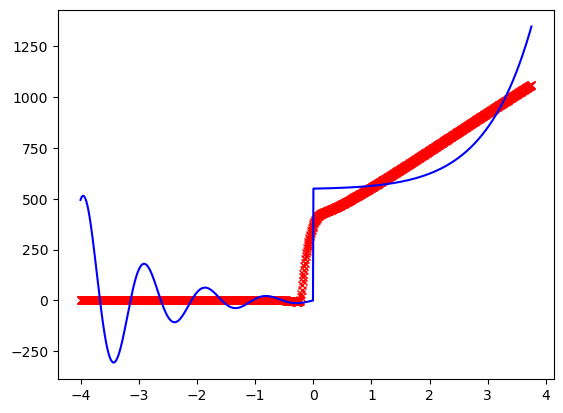

In [12]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [13]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.17826711759783126


In [14]:
import scipy.io as sio
import numpy as np

for tune_reps in range(5):
    label = "Regr_disc_swish_tune"+str(tune_reps)+".mat"
    data = sio.loadmat(label)
    re = np.array(data["test_re"])
    print(tune_reps," ",np.mean(re[:,-1]))

0   0.9999043661461956
1   0.9723030462388038
2   0.2918499264471592
3   0.20043071552900082
4   0.17826711759783126


In [15]:
lr_tune[4]

0.08